# 1. Idealised experiments
- all currently used idealised experiment figures are shown here

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook') 
import xarray as xr
import salem
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias
# OGGM options
oggm.cfg.initialize(logging_level='WARNING')

2024-08-02 16:56:35: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-02 16:56:35: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-02 16:56:35: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [3]:
### find the driest melt months
# this takes a while, so it got precomputed
load_dry_melt_months = False
if load_dry_melt_months:
    odf = pd.read_hdf(oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
    w5e5_path_pr = '/home/www/lschuster/w5e5v2.0/_script/pr_W5E5v2.0_*'
    ds_pr = xr.open_mfdataset(w5e5_path_pr)
    ds_pr = ds_pr.sel(time=slice('1989-11',str('2019-12'))) # want to have full consecutive months of three years
    # create monthly seasonal statistics
    ds_pr = ds_pr.resample(time='1M').mean()*60*60*24  # seconds to minutes to hours to days 
    ds_pr = ds_pr.pr.load()
    ds_pr_3m_sum = ds_pr.rolling(time=3, min_periods=3).sum().dropna(dim='time')
    # mostly the largest glaciers of different RGI regions
    sel_rgi_ids = ['RGI60-11.01450',
                   'RGI60-13.54431', 
                   'RGI60-16.01251', 
                   'RGI60-01.13696', 
                   'RGI60-03.01710',  
                   'RGI60-04.06187',
                   'RGI60-15.11693',
                   'RGI60-11.00897',
                   'RGI60-17.05181']
    dry_last_month_glacier_d = {}
    for r in sel_rgi_ids:
        ##### let's first compute the melt months
        rreg = r[6:8]
        f_rgi_path =f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/A_runs_pre_postprocessing/output/RGI{rreg}/'
        f_name = 'run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_stab_T15_endyr_2500_bc_1980_2019'
        ds = xr.open_mfdataset(f'{f_rgi_path}{f_name}_rgi{rreg}_*.nc')[['melt_off_glacier_monthly','melt_on_glacier_monthly',
                                                                        'liq_prcp_off_glacier_monthly','liq_prcp_on_glacier_monthly']]
        ds = ds.sel(rgi_id = r).load()
        # runoff is the sum of the four components
        ds['runoff_monthly'] = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly']  + ds['liq_prcp_off_glacier_monthly'] + ds['liq_prcp_on_glacier_monthly']
        # both melt components are used to select the melt months
        ds['melt_off_on_monthly'] = ds['melt_off_glacier_monthly'] + ds['melt_on_glacier_monthly'] 
        ds_drymonths = ds[['runoff_monthly','melt_off_on_monthly']].copy()
        ds_drymonths.coords['year'] = ds_drymonths.coords['time'].astype(int)
        ds_drymonths.coords['month'] = ds_drymonths.month_2d
        ds_drymonths = ds_drymonths.stack(year_month = ("time","month_2d"))
        ds_drymonths['year_month'] = ds_drymonths.year + (ds_drymonths.month-1)/12
        ds_drymonths['melt_off_on_monthly'] = ds_drymonths['melt_off_on_monthly'].rolling(year_month=3, min_periods=3).mean()
        ds_drymonths['melt_off_on_monthly'] = ds_drymonths['melt_off_on_monthly'].dropna(dim='year_month')
        _sel = ds_drymonths.melt_off_on_monthly.sel(year_month=slice(2000 + 2/12,2020 + 1/12))
        _rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last = _sel.groupby('month').mean()

        # compute the median monthly melt amount
        _rgi_median_past_seasonal_avg_melt_off_on_monthly_3mavg_last = _rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last.median(dim='month')
        # now, just take those months of every basin where melt is equal or above the median
        _rgi_sel_pd_months_w_melt_above_eq_median = _rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last.where(_rgi_past_seasonal_avg_melt_off_on_monthly_3mavg_last>=_rgi_median_past_seasonal_avg_melt_off_on_monthly_3mavg_last).to_dataframe().reset_index()
        _rgi_sel_pd_months_w_melt_above_eq_median = _rgi_sel_pd_months_w_melt_above_eq_median.dropna()
        assert len(_rgi_sel_pd_months_w_melt_above_eq_median) == 6
        _rgi_sel_pd_months_w_melt_above_eq_median = _rgi_sel_pd_months_w_melt_above_eq_median.reset_index(drop=True)
        melt_months = _rgi_sel_pd_months_w_melt_above_eq_median.month.values
        ##########################

        ###### now select the neares precipitation coordinate for that glacier
        lon, lat = odf.loc[r]['CenLon'], odf.loc[r]['CenLat']
        rgi_id_pr_sel = ds_pr_3m_sum.sel(lon=lon, lat = lat, method='nearest')
        rgi_id_pr_sel.coords['month'] = rgi_id_pr_sel['time.month']
        rgi_id_pr_sel.coords['year'] = rgi_id_pr_sel['time.year']
        # select this seasonal precipiation estimate
        df_rgi_id_pr_sel = rgi_id_pr_sel.to_dataframe('pr_3m_sum')
        df_rgi_id_pr_sel.index = df_rgi_id_pr_sel.month
        #  only choose the melt months
        df_rgi_id_pr_sel = df_rgi_id_pr_sel.loc[melt_months]
        df_rgi_id_pr_sel = df_rgi_id_pr_sel.reset_index(drop=True)
        # group it 
        rgi_id_pr_sel = df_rgi_id_pr_sel.groupby(['month','year']).sum().to_xarray()
        # and average over the year to select the three melt months with the least precipitation
        last_month_3m_driest_mean = rgi_id_pr_sel.mean(dim='year').idxmin(dim='month')['pr_3m_sum'].values.astype(int)

        print(r, last_month_3m_driest_mean)
        # save the last month of that period in a dictionary
        dry_last_month_glacier_d[r] = int(last_month_3m_driest_mean)

    with open('../data/idealised_exps_preprocessing/dry_last_melt_months_sel_rgi_ids.json', 'w') as outfile:
        json_string = json.dumps(dry_last_month_glacier_d)
        outfile.write(json_string)
else:
    # load the precomputed dictionary that give the last month of the three-month dry melt period
    with open('../data/idealised_exps_preprocessing/dry_last_melt_months_sel_rgi_ids.json') as json_file:
        dry_last_month_glacier_d = json.load(json_file)
        print(dry_last_month_glacier_d)

{'RGI60-11.01450': 9, 'RGI60-13.54431': 9, 'RGI60-16.01251': 11, 'RGI60-01.13696': 7, 'RGI60-03.01710': 6, 'RGI60-04.06187': 6, 'RGI60-15.11693': 11, 'RGI60-11.00897': 6}


In [4]:
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

In [5]:
rgi_ids = []
# chosen largest glaciers for Fig. 1 and suppl. idealised figures:
for rreg in ['11','13','16','01','03','04']:
    _r_id = odf.loc[odf.O1Region==rreg].sort_values(by='Area', ascending=False).index[0]
    rgi_ids.append(_r_id)
print(rgi_ids)
### other potential largest glaciers of regions:
# RGI60-17.05181

['RGI60-11.01450', 'RGI60-13.54431', 'RGI60-16.01251', 'RGI60-01.13696', 'RGI60-03.01710', 'RGI60-04.06187']


Load the preprocessed glaciers and show their outline 

2024-08-02 16:56:43: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2024-08-02 16:56:43: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2024-08-02 16:56:43: oggm.workflow: Execute entity tasks [GlacierDirectory] on 6 glaciers
2024-08-02 16:56:43: oggm.workflow: WARNING: you are trying to run an entity task on 6 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.



Su5X14308A001 Fedchenko

Seward Glacier
Wykeham Glacier South
Barnes Ice Cap South Dome N Slope


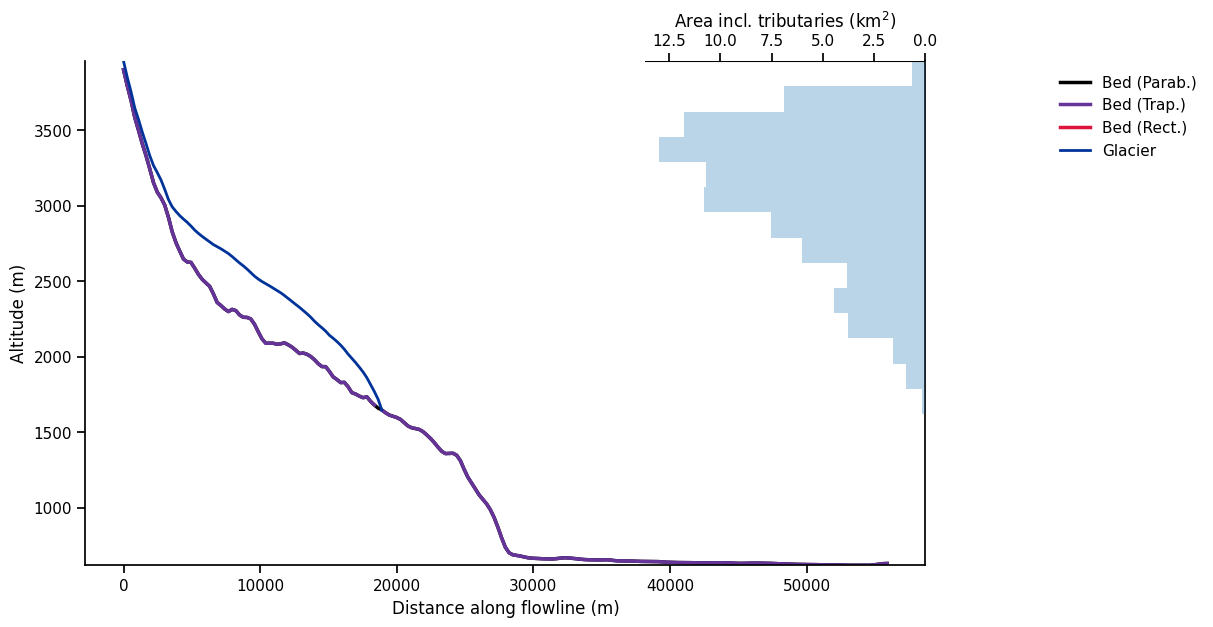

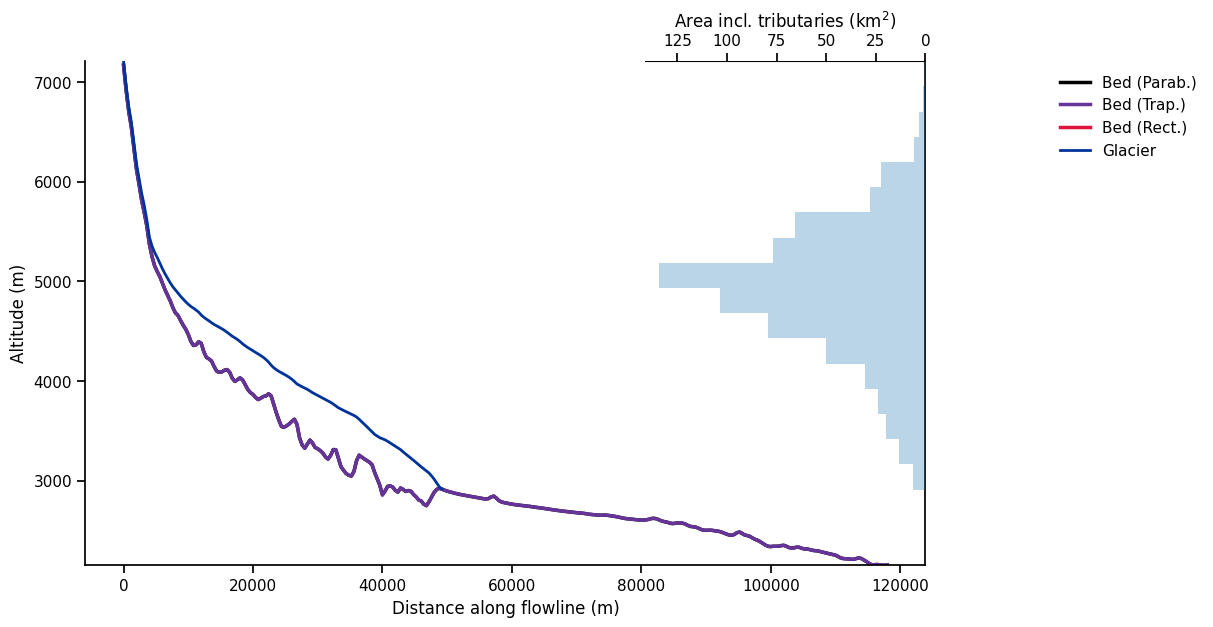

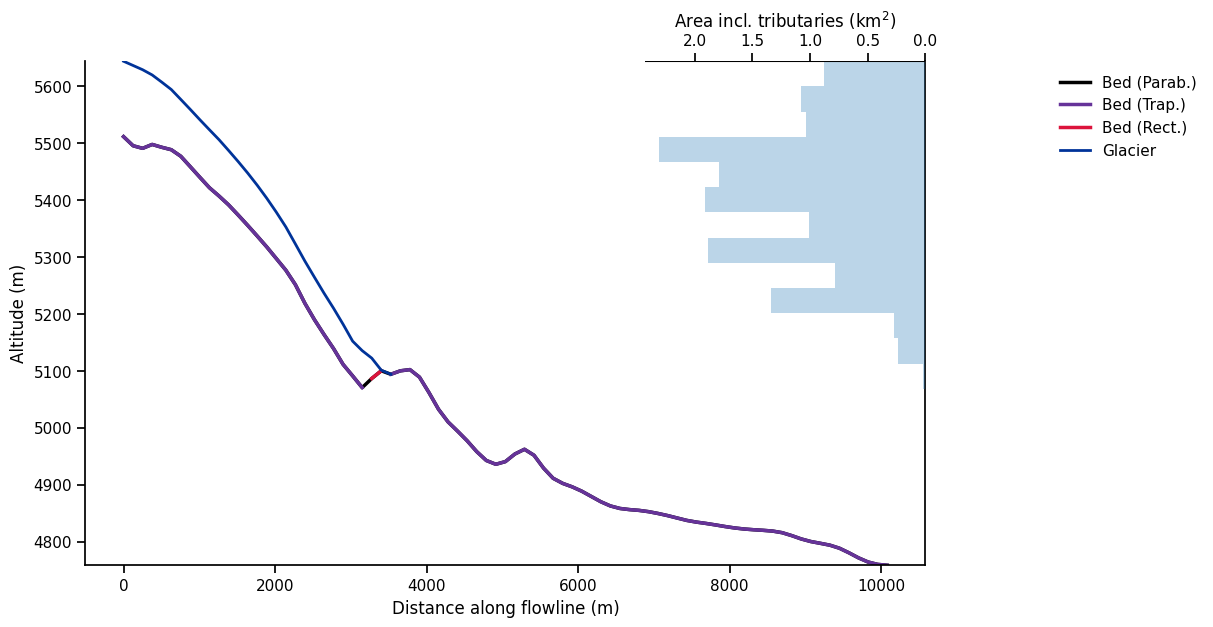

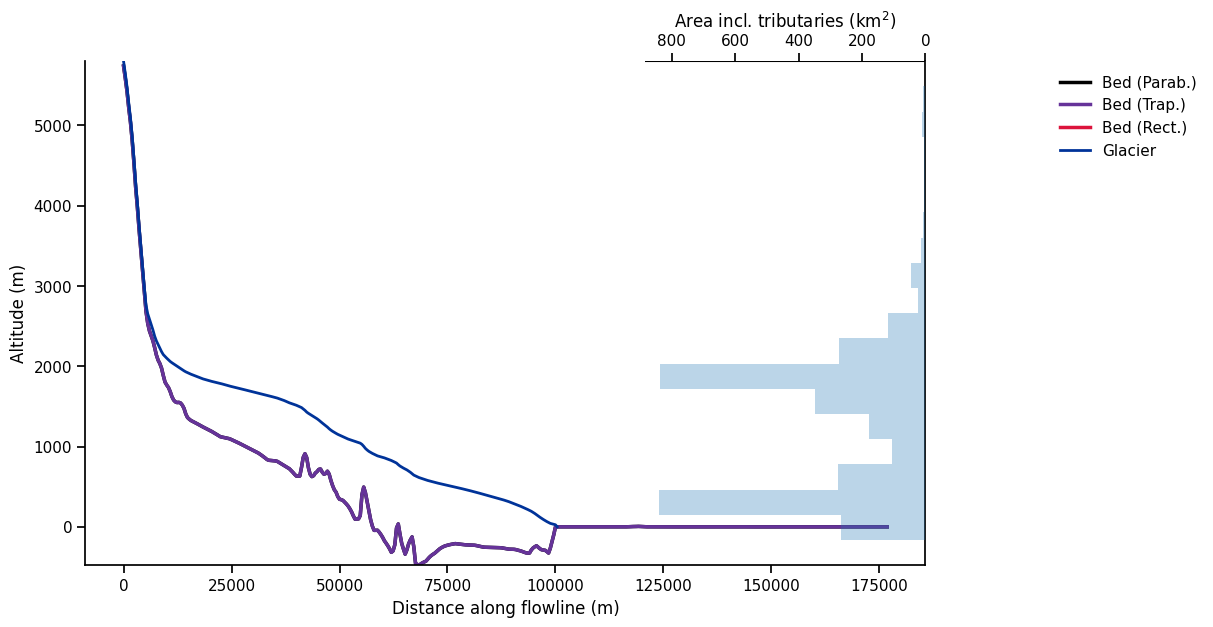

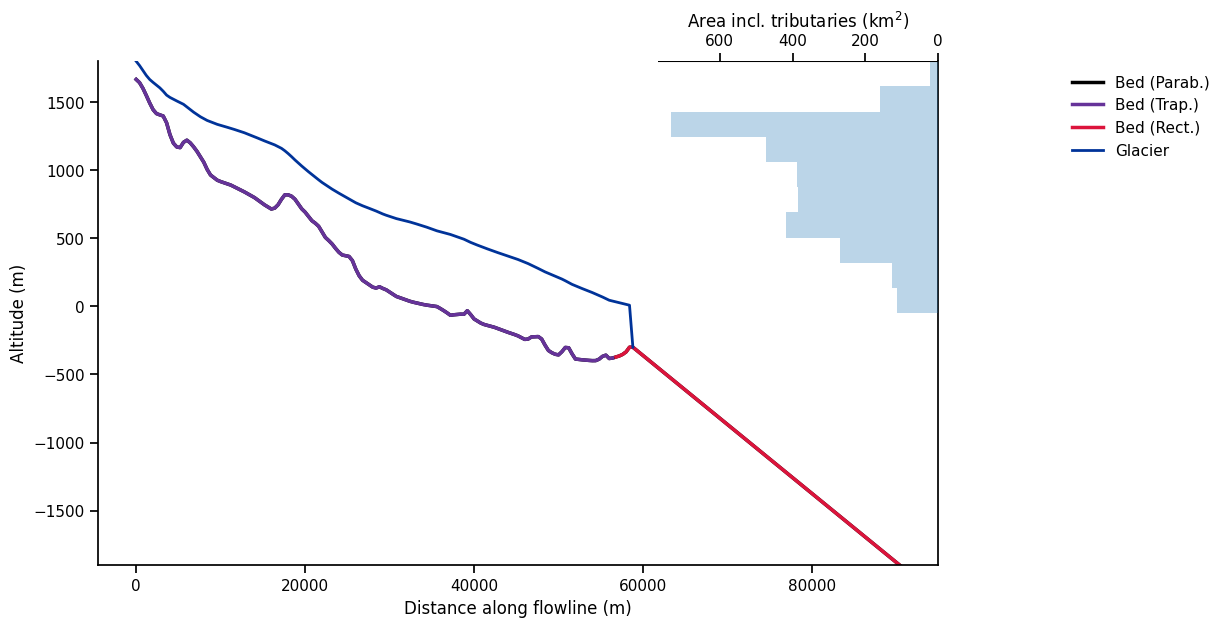

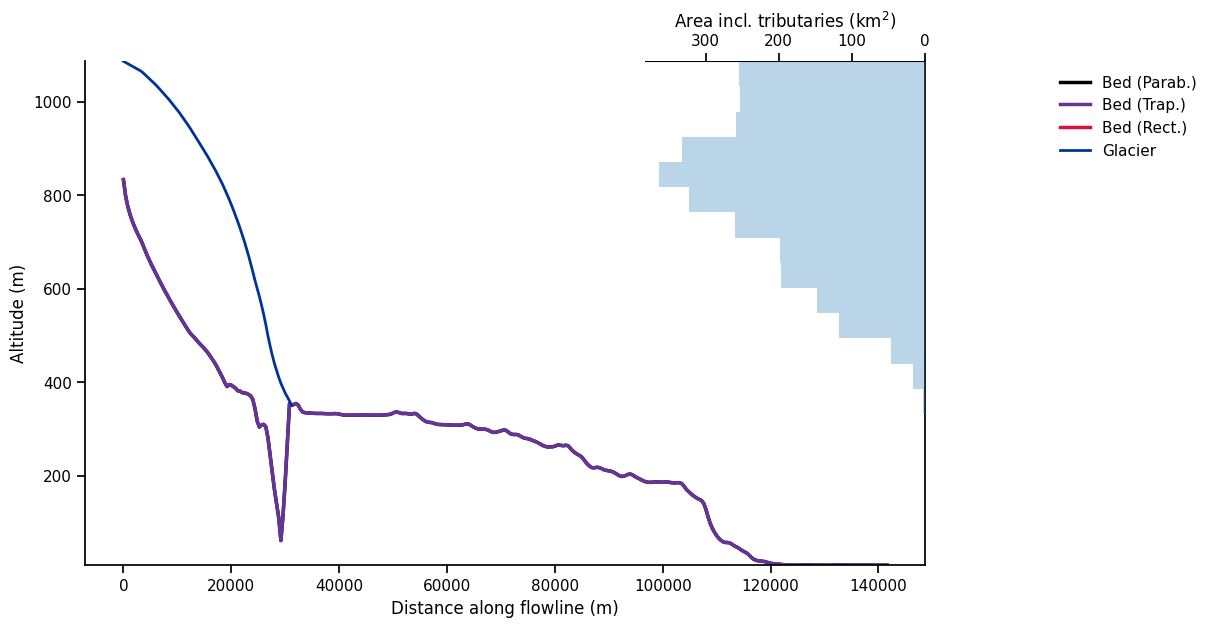

In [6]:
# We pick the same preprocessed gdirs as we will use for the actual projections later
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup'

# utils.gettempdir(dirname='WaterResources')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is defined when ice is thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True
run = False
run_spinup = False
# this loads a bit faster the figures... as we use the preprocessed files (specifically if later run_spinup is set to False)
# (if you run for the first time, you have to set run=True and run_spinup to True and then create your own directory ...)
folder_path = '/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/data/idealised_exps_preprocessing'
oggm.cfg.PATHS['working_dir'] = f'{folder_path}/oggm_dir_idealised'
if run and run_spinup: 
    gdirs= workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_border=160, prepro_base_url=base_url)
else:
    gdirs= workflow.init_glacier_directories(rgi_ids)

for gdir in gdirs:
    fls = gdir.read_pickle('model_flowlines')
    graphics.plot_modeloutput_section(fls);
    print(gdir.name)

Finds a temperature bias to the climate 2009+/-10 years where the glacier has roughly a similar volume/mass as at inventory date (i.e. near to the year 2000), and then applied that temperature bias to get in steady state with the climate 2009 +/- 10 while maintaining a glacier mass near to the inventory date

In [7]:
# this takes very long!!!
if run_spinup: 
    dict_delta_t_rgi_eq = {}
    file_id = f'_spinup'
    # it does not need to be in perfect equilibrium to select the delta_t, but can still take up to 2000 years for the very slow glacier
    years = np.arange(2000) 

    for gdir, _r in zip(gdirs, rgi_ids):
        dict_delta_t = {}
        print(gdir.rgi_id)
        for delta_t in np.arange(-2.4,0.3,0.05): # this might need to be adapted for other glaciers 
            # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
            try:
                temp_bias_ts = pd.Series(years * 0. + delta_t, index=years)
                tasks.run_with_hydro(gdir,  # Run on the selected glacier
                                     temp_bias_ts=temp_bias_ts,  # applied temp.bias on top of the applied climate
                                     run_task=run_constant_climate_with_bias,  # which climate scenario? 
                                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                     store_monthly_hydro=True,  # Monthly outputs provide additional information
                                     output_filesuffix=file_id);  # an identifier for the output file, to read it later
                with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
                    # The last step of hydrological output is NaN (we can't compute it for this year)
                    # at year 0, the volume is near to the inventory date
                    ds = ds.isel(time=slice(0, -1)).load()
                    ratio = np.abs(1 - ds.volume_m3.isel(time=-1)/ds.volume_m3.isel(time=0)).values
                    if ds.isel(time=-1).volume_m3<0.7*ds.volume_m3.isel(time=0):
                        # we can stop, we don't need to look for even warmer temperatures... 
                        print(gdir.rgi_id, delta_t)
                        break 
                print(delta_t)
            except:
                ratio = 100000
            dict_delta_t[delta_t.round(2)] = ratio
        pd_delta_t = pd.DataFrame(dict_delta_t, index = ['rel_diff_v1/v0']).T
        print(pd_delta_t.min())
        delta_t_eq = pd_delta_t.idxmin().values[0]
        dict_delta_t_rgi_eq[gdir.rgi_id] = delta_t_eq
    
    
    ### spinup 
    for gdir in gdirs:
        print(gdir.rgi_id)
        delta_t_eq = dict_delta_t_rgi_eq[gdir.rgi_id]
        print(f'{gdir.rgi_id} - {gdir.name} need temperature bias of {delta_t_eq}°C to get into steady state with similar'
              'volume as volume from inventory date')
        #with plt.xkcd():
        delta_t = delta_t_eq
        years = np.arange(2000) # 1000 use longer time series to make sure it is in steady-state ... 
        temp_bias_ts = pd.Series(years * 0. + delta_t, index=years)
        temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)');

        # file identifier where the model output is saved
        file_id = '_spinup'

        # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
        tasks.run_with_hydro(gdir,  # Run on the selected glacier
                             temp_bias_ts=temp_bias_ts,  # the temperature bias to apply to the average climate
                             run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                             y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                             store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                             output_filesuffix=file_id);  # an identifier for the output file, to read it later
    # save temperature bias for steady states of the glaciers in JSON string
    with open('../data/idealised_exps_preprocessing/idealised_equilibrium_temp_bias.json', 'w') as outfile:
        json_string = json.dumps(dict_delta_t_rgi_eq)
        outfile.write(json_string)
else:
    # necessary temperature bias for steady states of the glaciers
    with open('../data/idealised_exps_preprocessing/idealised_equilibrium_temp_bias.json') as json_file:
        dict_delta_t_rgi_eq = json.load(json_file)
        print(dict_delta_t_rgi_eq)

{'RGI60-11.01450': -1.15, 'RGI60-13.54431': -0.4, 'RGI60-03.01710': -0.25, 'RGI60-04.06187': -2.05, 'RGI60-16.01251': -0.1, 'RGI60-01.13696': -0.6}


-1.15 0.8464908800000002
-0.4 1.5964908800000002
-0.1 1.89649088
-0.6 1.39649088
-0.25 1.74649088
-2.05 -0.053509119999999744


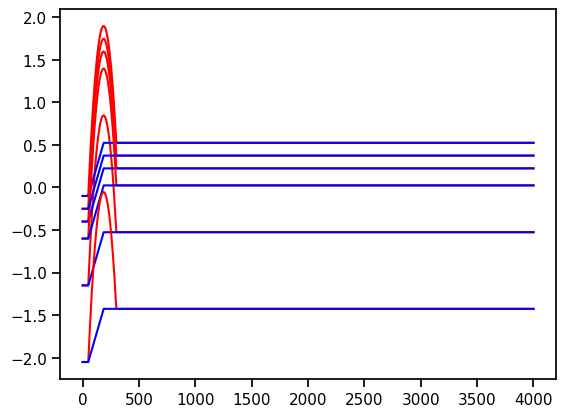

In [8]:
do_step_change = False
for gdir in gdirs: 
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    # let's define our overshoot (temperature bias series that we apply on th 2009+/-10 yr climate)
    x = np.arange(0,250,1)
    ny_s=50
    t0 = ny_s
    ny_e=250
    t1 = ny_e +ny_s
    a = -0.00010772
    b = 0.0024
    c = delta_t

    t = np.arange(t0, t1, 1)
    y = a * (t - t0) * (t - t1) + b * (t - t0) + c

    ys = np.concatenate([np.full(ny_s, y[0]), y, np.full(ny_e, y[-1])])
    temp_bias_ts = pd.Series(ys-(y[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
    temp_bias_ts = pd.concat([temp_bias_ts, pd.Series(index=np.arange(550,4002,1), dtype='float64')])
    temp_bias_ts.loc[550:] = temp_bias_ts.loc[549]
    temp_bias_ts.plot(color='red'); 

    yr_max_os = temp_bias_ts.idxmax() - 50 
    x = np.arange(0,yr_max_os,1)
    y2 = (y[-1]-y[0])/yr_max_os*x + y[0]
    ys2 = np.concatenate([np.full(ny_s, y2[0]), y2, np.full(ny_e+250-yr_max_os, y[-1])])

    # now create a stabilisation timeseries that stabilises at the same final temp. level as the overshoot experiment
    # (but without peaking and then declining). We define that it stabilised at the year where the overshoot peaks. 
    temp_bias_ts_lin = pd.Series(ys2-(y2[0]-delta_t), index=np.arange(0,yr_max_os+ny_s+ny_e+250-yr_max_os,1))
    #temp_bias_ts_lin = pd.Series(ys2-(y2[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
    temp_bias_ts_lin = pd.concat([temp_bias_ts_lin, pd.Series(index=np.arange(550,4002,1), dtype='float64')])
    temp_bias_ts_lin.loc[550:] = temp_bias_ts_lin.loc[549]
    temp_bias_ts_lin.plot(color='blue'); 

    if do_step_change:
        # we also create a step change experiment, but do not use it anymore in the main figures
        temp_bias_step = np.concatenate([np.repeat(temp_bias_ts_lin.iloc[0], ny_s),
                                 np.repeat(temp_bias_ts_lin.iloc[-1], ny_e+250)])
        temp_bias_step = pd.Series(temp_bias_step, index=np.arange(0,250+ny_s+ny_e,1))
        temp_bias_step = pd.concat([temp_bias_step, pd.Series(index=np.arange(550,4002,1), dtype='float64')])
        temp_bias_step.loc[550:] = temp_bias_step.loc[549]
        temp_bias_step.plot(color='grey'); plt.xlabel('Year'); plt.ylabel(r'Temperature bias (°C, $t_b$)');

    print(temp_bias_ts.min(), temp_bias_ts.max())
    if run: 
        # .... need to use the correct temp_bias_ts ... 
        for add in ['']:
            # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
            tasks.run_with_hydro(gdir,
                                 temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                                 run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                 y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                 store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                 init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                                 output_filesuffix=f'_oversh_temp{add}');  # an identifier for the output file, to read it later

            # linear temp. change
            tasks.run_with_hydro(gdir,
                                 temp_bias_ts=temp_bias_ts_lin,  # the temperature bias timeseries we just created
                                 run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                 y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                 store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                 init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                                 output_filesuffix= f'_lin_temp{add}');  # an identifier for the output file, to read it later
            if do_step_change:
                # step temp. change
                tasks.run_with_hydro(gdir,
                                     temp_bias_ts=temp_bias_step,  # the temperature bias timeseries we just created
                                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                                     init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                                     output_filesuffix= f'_step_temp{add}');  # an identifier for the output file, to read it later
        print(gdir.rgi_id)

In [9]:
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']

#labels_nice_dict = {'melt_off_glacier': 'melt off glacier',
#                    'melt_on_glacier': 'melt on glacier',
#                    'liq_prcp_off_glacier': 'liquid precipitation off glacier',
#                    'liq_prcp_on_glacier': 'liquid precipitation on glacier'}

runoff_vars_monthly = ['melt_off_glacier_monthly',
                       'melt_on_glacier_monthly',
                       'liq_prcp_off_glacier_monthly',
                       'liq_prcp_on_glacier_monthly']

labels_nice_dict = {'melt_off_glacier_monthly': 'melt off glacier',
                    'melt_on_glacier_monthly': 'melt on glacier',
                    'liq_prcp_off_glacier_monthly': 'liquid precipitation off glacier',
                    'liq_prcp_on_glacier_monthly': 'liquid precipitation on glacier'}

In [10]:
### save the data ... 
roll = 21

ds_d = {}
ds_lin_d = {}
#ds_step_d = {}

df_runoff_d = {}
df_lin_runoff_d = {}
#df_step_runoff_d = {}

df_runoff_d_dry = {}
df_lin_runoff_d_dry = {}
#df_step_runoff_d_dry = {}
#fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(30, 20), sharex=True)
#axs = axs.flatten()
#axs_s = axs[-6:]
for j,gdir in enumerate(gdirs):
    with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp')) as ds:
        # The last step of hydrological output is NaN (we can't compute it for this year)
        ds = ds.isel(time=slice(0, -1)).load()

    with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp')) as ds_lin:
        ds_lin = ds_lin.isel(time=slice(0, -1)).load()
    if do_step_change:
        with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_step_temp')) as ds_step:
            ds_step = ds_step.isel(time=slice(0, -1)).load()


    sel_vars_m = [v for v in ds.variables if 'month_2d' in ds[v].dims]
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]

    
    ds_lin_d[gdir.rgi_id] = ds_lin
    #ds_step_d[gdir.rgi_id] = ds_step
    ds_d[gdir.rgi_id] = ds
    
    for _d,_f in zip([ds,ds_lin], #,ds_step],
                     [df_runoff_d,df_lin_runoff_d]): #,df_lin_runoff_d_dry]):
                      
                                          
        df_annual = _d[runoff_vars].to_dataframe()
        # Select only the runoff variables
        # Convert them to megatonnes (instead of kg)
        df_runoff = df_annual[runoff_vars] * 1e-9
        # We smooth the output, which is otherwize noisy because of area discretization
        df_runoff = df_runoff.rolling(roll, center=True, min_periods=1).mean()
        df_runoff = df_runoff.rename(columns=labels_nice_dict)
                      
        _f[gdir.rgi_id] = df_runoff

    for _d,_f in zip([ds,ds_lin], #,ds_step],
                 [df_runoff_d_dry,df_lin_runoff_d_dry]): #,df_lin_runoff_d_dry]):   
        # todo change the numbers 
        m_last = dry_last_month_glacier_d[gdir.rgi_id]
        m_first = m_last-2
        print(gdir.rgi_id, m_first, m_last)
        df_summer = _d[runoff_vars_monthly].sel(month_2d=slice(m_first,m_last)).sum(dim='month_2d').to_dataframe()
        # Convert them to megatonnes (instead of kg)
        df_runoff_sum = df_summer[runoff_vars_monthly] * 1e-9
        # We smooth the output, which is otherwize noisy because of area discretization
        df_runoff_sum = df_runoff_sum.rolling(roll, center=True, min_periods=1).mean()
        _f[gdir.rgi_id] = df_runoff_sum#.sum(axis=1)


RGI60-11.01450 7 9
RGI60-11.01450 7 9
RGI60-13.54431 7 9
RGI60-13.54431 7 9
RGI60-16.01251 9 11
RGI60-16.01251 9 11
RGI60-01.13696 5 7
RGI60-01.13696 5 7
RGI60-03.01710 4 6
RGI60-03.01710 4 6
RGI60-04.06187 4 6
RGI60-04.06187 4 6


In [11]:
num_dict = {
    0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j',
    10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's',
    19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'
}

**Important --> trough water definition:**
- We define "trough water" to occur if the 21 or 51-year average annual or seasonal glacier runoff from an overshoot scenario is at least 5\% smaller than in a stabilisation scenario for at least 20 years and if the runoff from the overshoot scenario stays below the baseline period (initial steady state for the idealised experiments, 2000--2020 or 2000--2050 climate for the projections with the ESM).

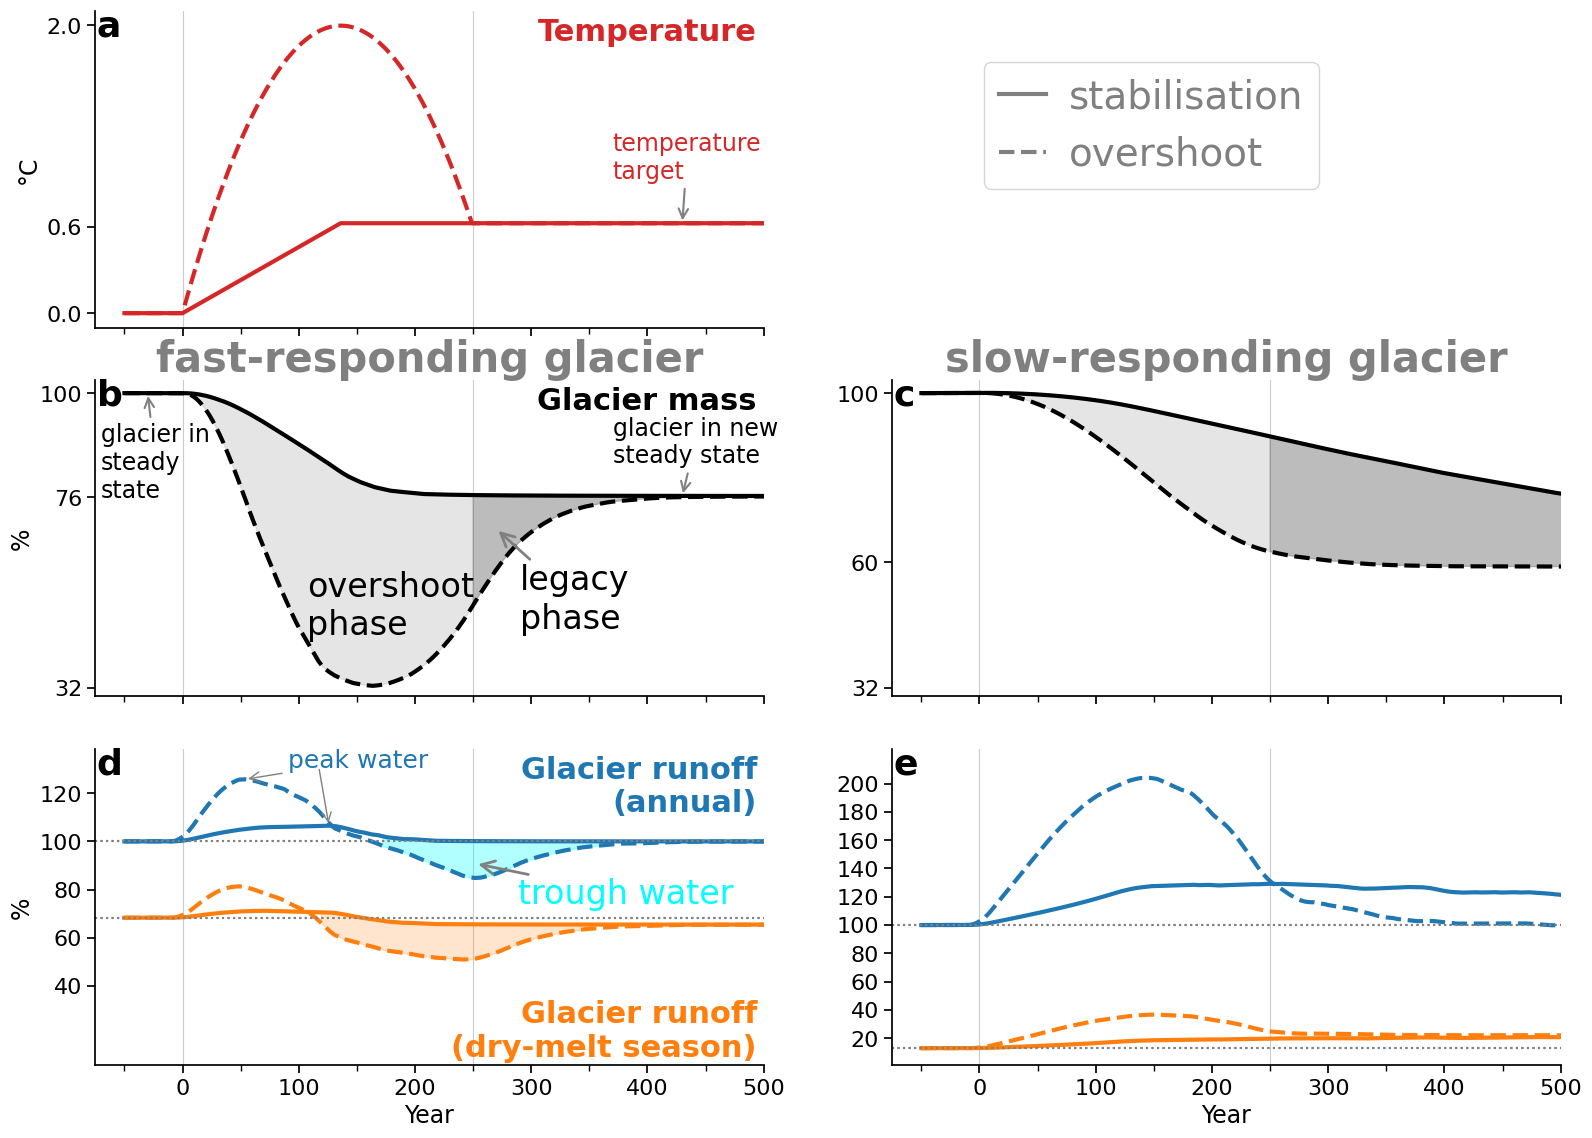

In [13]:
# for Fig. 1 we only show one fast responding glacier (Aletsch glacier) and one slower responding glacier (Wykeham Glacier South)
gdirs_sel_fig1 = [gdirs[0],gdirs[-2]]

with_step_ch = False
plt.rc('font', size=26)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16.5, 12), sharex=True)
axs = axs.flatten()

j = 0

if with_step_ch:
    temp_bias_step.plot(ax=axs[0], c='C3', ls=':', lw=3, label='step change');
(temp_bias_ts_lin-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', ls='-', lw=3, label='stabilisation');
(temp_bias_ts-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', label='overshoot', lw=3, ls='--');
axs[0].text(0.99, 0.98, 'Temperature', weight='bold',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=22, color='C3')

axs[0].set_xlabel(''); 
#axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

    

axs[0].annotate('temperature\ntarget',(480,temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0]),
                xytext=(420,(temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0])*1.5),
                color='C3',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

for j,gdir in enumerate(gdirs_sel_fig1): 
    ds = ds_d[gdir.rgi_id]
    ds_lin = ds_lin_d[gdir.rgi_id]

    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff_lin = df_lin_runoff_d[gdir.rgi_id]

    df_runoff_dry = df_runoff_d_dry[gdir.rgi_id]
    df_runoff_dry_lin = df_lin_runoff_d_dry[gdir.rgi_id]
    
    init_vol = ds_lin.volume_m3.isel(time=0)
    if j==0:
        axs[2+j].text(0.99, 0.98, 'Glacier mass',
                 ha='right', va='top', transform=axs[2+j].transAxes, 
                fontsize=22, color='black', weight='bold')
    if with_step_ch:
        (100*ds_lin.volume_m3/init_vol).plot(ax=axs[2+j], c='black', ls=':');

    (100*ds_lin.volume_m3/init_vol).plot(ax=axs[2+j], c='black', ls ='-' , lw=3);
    (100*ds.volume_m3/init_vol).plot(ax=axs[2+j], c='black', ls='--', lw=3);
    axs[2+j].set_ylabel('')
    #axs[1].set_title('Glacier mass', fontsize=22)
    eq0 = (100*ds.volume_m3/init_vol).isel(time=0)
    eq1 = (100*ds.volume_m3/init_vol).isel(time=-1)
    if j==0:
        axs[2+j].annotate('glacier in\nsteady\nstate',(20,eq0), xytext=(-20,eq0*0.76), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

        axs[2+j].annotate('glacier in new\nsteady state',(480,eq1), xytext=(420,eq1*1.1), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

    t = 0 #np.abs((temp_bias_ts-temp_bias_ts_lin.max())).iloc[:200].idxmin()
    axs[2+j].fill_between(ds_lin.time.sel(time=slice(t,ds_lin.time.values[-1])), (100*ds.sel(time=slice(t,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(t,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.2, color='grey')
    if j==0:
        axs[2+j].annotate('overshoot\nphase', # additional\nwarming\nreduces\nice',
                          (157,eq1*0.58),color='black',
                           fontsize=24)

    axs[2+j].fill_between(ds_lin.time.sel(time=slice(300,ds_lin.time.values[-1])), (100*ds.sel(time=slice(300,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(300,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.4, color='grey')
    if j==0:
        axs[2+j].annotate('legacy\nphase', # past warming reduces ice
                          (320,eq1*0.9), xytext=(340,eq1*0.6), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=24) 
        ### temporarily irreversible 
        axs[4+j].text(0.99, 0.98, 'Glacier runoff\n(annual)',
                 ha='right', va='top', transform=axs[4+j].transAxes, 
                fontsize=22, color='C0', weight='bold')
    init_runoff = df_runoff.sum(axis=1).iloc[0]
    if with_step_ch:
        (100*df_runoff_step.sum(axis=1)/init_runoff).plot(ax=axs[4+j], label = 'Annual runoff', c='C0', ls=':');
    (100*df_runoff_lin.sum(axis=1)/init_runoff).plot(ax=axs[4+j], label = 'Annual runoff', c='C0', ls='-', lw=3);
    (100*df_runoff.sum(axis=1)/init_runoff).plot(ax=axs[4+j], label = 'Annual runoff', c='C0', ls='--', lw=3);

    axs[4+j].axhline((100*df_runoff.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    axs[4+j].axhline((100*df_runoff_lin.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    #plt.ylabel('Runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');

    #axs[2].fill_between(df_runoff.index,
    #                 df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')
    # trough water condition, both diff hast to be <=-5% but also it needs to be smaller than the baseline (initial) 
    diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
    diff_initial = -df_runoff.sum(axis=1).iloc[0] + df_runoff.sum(axis=1) 
    axs[4+j].fill_between(df_runoff_lin.index, (100*df_runoff_lin.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff),
                                            (100*df_runoff.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff), alpha=0.3, color='cyan')
    pw = (100*df_runoff.sum(axis=1).max()/init_runoff)
    tw = (100*df_runoff.sum(axis=1).min()/init_runoff)
    axs[4+j].set_ylim([(100*df_runoff_sum.sum(axis=1).min()*0.95/init_runoff),pw*1.1])
    pw_ind = df_runoff.sum(axis=1).idxmax()
    m = 4+j

    if j==0:
        axs[4+j].annotate('peak water',(pw_ind,pw), xytext=(pw_ind*1.35,pw*1.1),
                        xycoords='data', textcoords='data', va ='top',
                        color='C0',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=18)
        pw_lin = (100*df_runoff_lin.sum(axis=1).max()/init_runoff)
        pw_ind_lin =  df_runoff_lin.sum(axis=1).idxmax()
        axs[4+j].annotate('',(pw_ind_lin,pw_lin), xytext=(pw_ind_lin*0.95,pw_lin*1.23),
                        xycoords='data', textcoords='data',
                        color='C0',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
        tw_ind = df_runoff.sum(axis=1).idxmin()

        axs[4+j].annotate('trough water',(tw_ind,tw*1.07), xytext=(tw_ind*1.12,tw*0.92),
                     xycoords='data', textcoords='data', color='cyan',
                        va='center',ha='left',
                   arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=24)

        #plt.legend()
        axs[m].text(0.99, 0.01, 'Glacier runoff\n(dry-melt season)', # here for Aletsch glacier (i.e., driest months of entire RHONE basin)
                 ha='right', va='bottom', transform=axs[m].transAxes, 
                fontsize=22, color='tab:orange', weight='bold')
    if with_step_ch:
        (100*df_runoff_dry_step/init_runoff).sum(axis=1).plot(ax=axs[m], c='tab:orange', ls=':');
    (100*df_runoff_dry_lin.sum(axis=1)/init_runoff).plot(ax=axs[m],  c='tab:orange', ls='-',lw=3);
    (100*df_runoff_dry.sum(axis=1)/init_runoff).plot(ax=axs[m], c='tab:orange', ls='--', lw=3);
    axs[m].axhline((100*df_runoff_dry.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')
    axs[m].axhline((100*df_runoff_dry_lin.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')

    #tw_ind_dry = df_runoff_dry.sum(axis=1).idxmin()
    #axs[m].annotate('',(tw_ind_dry,tw_ind_dry*1.01), xytext=(tw_ind_dry*1.2,tw_ind_dry*1.3),
    #             xycoords='data', textcoords='data', color='cyan',
    #                va='bottom',ha='left',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=20)

    #axs[m].fill_between(df_runoff_dry.sum(axis=1).index,
    #                    df_runoff_dry.sum(axis=1).iloc[0],
    #                    df_runoff_dry.sum(axis=1).values, alpha = 0.3, color='tab:orange')

    diff = (-df_runoff_dry_lin.sum(axis=1)+df_runoff_dry.sum(axis=1))
    diff_initial = -df_runoff_dry_lin.sum(axis=1).iloc[0] + df_runoff_dry.sum(axis=1) 
    axs[4+j].fill_between(df_runoff_dry_lin.index, (100*df_runoff_dry_lin.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff),
                                                  (100*df_runoff_dry.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff), alpha=0.2, color='tab:orange') #, label='')


    #leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
    #leg.get_title().set_color('C4')

    axs[m].set_ylim([axs[m].get_ylim()[0]*0.6, axs[m].get_ylim()[1]])
    #plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
    #plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
    #         c='cyan', ls='-.',lw=0.4)
    #ax.set_xticks([])
    num_text_x = 0.005
    num_text_y = 0.92
    fs_ticks=16
    axs[0].set_yticks([(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      [(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      fontsize=fs_ticks)
    axs[0].set_ylabel('°C', fontsize=fs_ticks+1)
    if j==0:
        axs[2+j].set_yticks([int((100*ds.volume_m3/init_vol).min().round(0).values),
                             int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                          [int((100*ds.volume_m3/init_vol).min().round(0).values), int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                            fontsize=fs_ticks)
    else:
        axs[2+j].set_yticks([int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                             int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                          [int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                           int((100*ds.volume_m3/init_vol).min().round(0).values), 100],
                            fontsize=fs_ticks)
    axs[2+j].set_ylim([30,103])
    
    axs[2+j].set_ylabel('%', fontsize=fs_ticks+1)
    axs[4+j].set_ylabel('%', fontsize=fs_ticks+1)
    if j==0:
        axs[4+0].set_yticks([40,60,80,100,120],[40,60,80,100,120], fontsize=fs_ticks)
    else:
        axs[4+1].set_yticks([20,40,60,80,100,120,140,160,180, 200],
                            [20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)


    #plt.tight_layout();
    axs[4+j].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
    axs[4+j].set_xlabel('Years', fontsize=fs_ticks+1); #axs[0].set_ylabel('Temperature bias (°C)');
# reset the time axis to start at zero when the temp. changes are applied
for jj,ax in enumerate([axs[0], axs[2], axs[3], axs[4], axs[5]]):
    #ax.set_yticks([]);
    ax.set_xticks([],[])
    ax.text(num_text_x-0.003, num_text_y,
            num_dict[jj], fontsize=26, transform=ax.transAxes, weight='bold')
    ax.axvline(300, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlim([-25,525])
for j in [0,1]:
    axs[4+j].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
    axs[4+j].set_xlabel('Year', fontsize=fs_ticks+1); #axs[0].set_ylabel('Temperature bias (°C)');


fig.delaxes(axs[1])
for ax in [axs[3], axs[5]]:
    ax.set_ylabel('')
plt.tight_layout()

#name = 'Aletsch Glacier'
name = 'fast-responding glacier'
axs[2].set_title(name, weight='bold', fontsize=30, color = 'grey')

j = 1
name = gdirs_sel_fig1[j].name
name= 'slow-responding glacier'
axs[2+1].set_title(name, weight='bold', fontsize=30, color = 'grey')
leg = axs[0].legend(fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6,
                    loc = 'upper left', bbox_to_anchor=(1.3,0.9), ncol=1)
for jj in np.arange(0,len(leg.get_lines()),1):
    leg.get_lines()[jj].set_color('grey')
    leg.get_texts()[jj].set_color('grey')

plt.savefig('../figures/fig_1.pdf')
plt.savefig('../figures/fig_1.png')

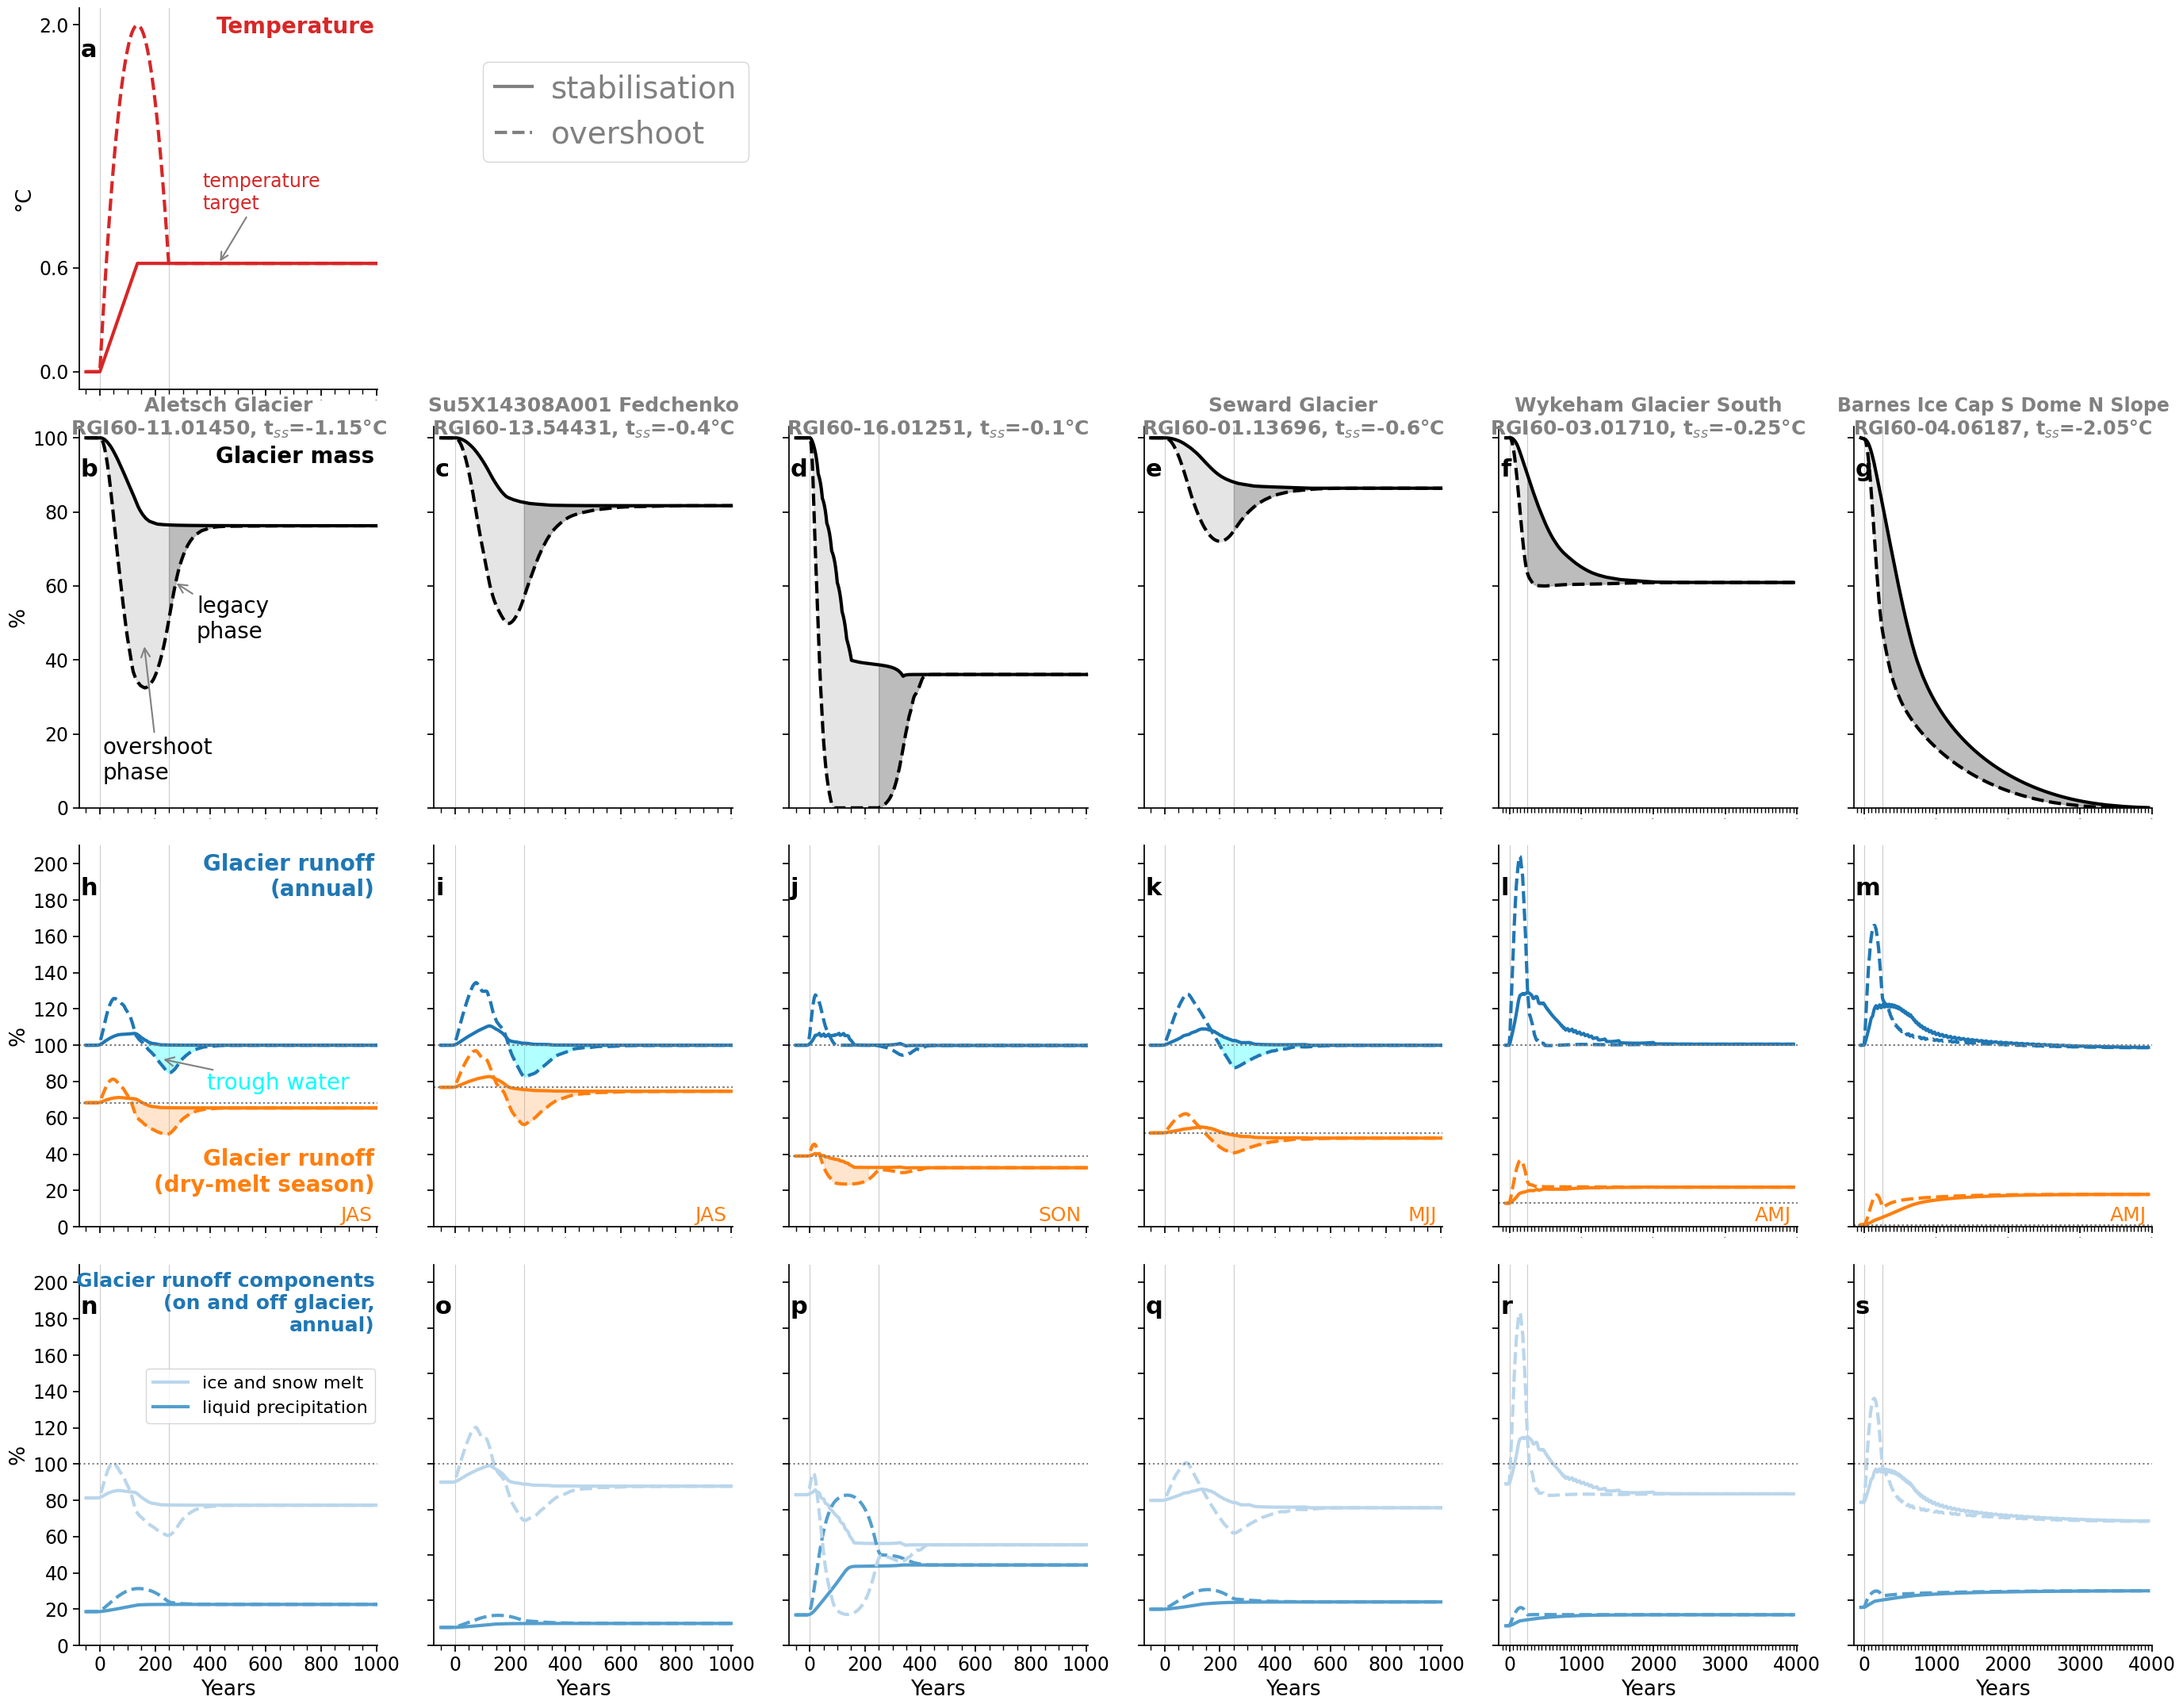

In [14]:
with_step_ch = False
fig_1_opt = False

plt.rc('font', size=22)
fs_ticks=17

ncols=6

fig, axs = plt.subplots(nrows=4, ncols=ncols, figsize=(28, 22)) #, sharex=True)
axs = axs.flatten()

j = 0

#ds.length_m.plot(ax=axs[1]);
if with_step_ch:
    temp_bias_step.plot(ax=axs[0], c='C3', ls=':', lw=3, label='step change');
(temp_bias_ts_lin-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', ls='-', lw=3, label='stabilisation');
(temp_bias_ts-temp_bias_ts.iloc[0]).plot(ax=axs[0], c='C3', label='overshoot', lw=3, ls='--');
axs[0].text(0.99, 0.98, 'Temperature', weight='bold',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=20, color='C3')
handles, labels = axs[0].get_legend_handles_labels()
#axs[0].get_legend().remove()

axs[0].set_xlabel(''); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

axs[0].annotate('temperature\ntarget',(480,temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0]),
                xytext=(420,(temp_bias_ts_lin.iloc[-1]-temp_bias_ts.iloc[0])*1.5),
                color='C3',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

##
for j,gdir in enumerate(gdirs): 
    ds = ds_d[gdir.rgi_id]
    ds_lin = ds_lin_d[gdir.rgi_id]

    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff = df_runoff_d[gdir.rgi_id]
    df_runoff_lin = df_lin_runoff_d[gdir.rgi_id]

    df_runoff_dry = df_runoff_d_dry[gdir.rgi_id]
    df_runoff_dry_lin = df_lin_runoff_d_dry[gdir.rgi_id]
    
    init_vol = ds_lin.volume_m3.isel(time=0)
    if j==0:
        axs[ncols+j].text(0.99, 0.95, 'Glacier mass',
                 ha='right', va='top', transform=axs[ncols+j].transAxes, 
                fontsize=20, color='black', weight='bold')
    if with_step_ch:
        (100*ds_lin.volume_m3/init_vol).plot(ax=axs[ncols+j], c='black', ls=':');

    (100*ds_lin.volume_m3/init_vol).plot(ax=axs[ncols+j], c='black', ls ='-' , lw=3);
    (100*ds.volume_m3/init_vol).plot(ax=axs[ncols+j], c='black', ls='--', lw=3);
    axs[ncols+j].set_ylabel('')
    #axs[1].set_title('Glacier mass', fontsize=22)
    eq0 = (100*ds.volume_m3/init_vol).isel(time=0)
    eq1 = (100*ds.volume_m3/init_vol).isel(time=-1)
    if j==0 and fig_1_opt:
        axs[ncols+j].annotate('glacier in\nsteady\nstate',(20,eq0), xytext=(-20,eq0*0.76), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

        axs[ncols+j].annotate('glacier in new\nsteady state',(480,eq1), xytext=(420,eq1*1.1), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

    t = 0 #np.abs((temp_bias_ts-temp_bias_ts_lin.max())).iloc[:200].idxmin()
    axs[ncols+j].fill_between(ds_lin.time.sel(time=slice(t,ds_lin.time.values[-1])), (100*ds.sel(time=slice(t,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(t,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.2, color='grey')
    if j==0:
        axs[ncols+j].annotate('overshoot\nphase', #additional\nwarming\nreduces\nice',
                          (210,eq1*0.58), xytext=(60,eq1*0.1),color='black',
                              arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5},
                           fontsize=20)

    axs[ncols+j].fill_between(ds_lin.time.sel(time=slice(300,ds_lin.time.values[-1])), (100*ds.sel(time=slice(300,ds.time.values[-1])).volume_m3/init_vol),
                         (100*ds_lin.sel(time=slice(300,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.4, color='grey')
    m = ncols*2+j

    if j==0:
        #if fig_1_opt:
        axs[ncols+j].annotate('legacy\nphase', # past warming reduces ice
                          (320,eq1*0.8), xytext=(400,eq1*0.6), color='black',
                   arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=20) 
        ### temporarily irreversible 
        axs[m].text(0.99, 0.98, 'Glacier runoff\n(annual)',
                 ha='right', va='top', transform=axs[m].transAxes, 
                fontsize=20, color='C0', weight='bold')
    init_runoff = df_runoff.sum(axis=1).iloc[0]
    if with_step_ch:
        (100*df_runoff_step.sum(axis=1)/init_runoff).plot(ax=axs[m], label = 'Annual runoff', c='C0', ls=':');
    (100*df_runoff_lin.sum(axis=1)/init_runoff).plot(ax=axs[m], label = 'Annual runoff', c='C0', ls='-', lw=3);
    (100*df_runoff.sum(axis=1)/init_runoff).plot(ax=axs[m], label = 'Annual runoff', c='C0', ls='--', lw=3);

    axs[m].axhline((100*df_runoff.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    axs[m].axhline((100*df_runoff_lin.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
    #plt.ylabel('Runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');

    #axs[2].fill_between(df_runoff.index,
    #                 df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')

    diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
    diff_initial = -df_runoff.sum(axis=1).iloc[0] + df_runoff.sum(axis=1) 
    axs[m].fill_between(df_runoff_lin.index, (100*df_runoff_lin.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff),
                                            (100*df_runoff.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff), alpha=0.3, color='cyan')
    pw = (100*df_runoff.sum(axis=1).max()/init_runoff)
    tw = (100*df_runoff.sum(axis=1).min()/init_runoff)
    axs[m].set_ylim([(100*df_runoff_sum.sum(axis=1).min()*0.95/init_runoff),pw*1.1])
    pw_ind = df_runoff.sum(axis=1).idxmax()

    if j==0:
        if fig_1_opt:
            axs[m].annotate('peak water',(pw_ind,pw), xytext=(pw_ind*1.35,pw*1.1),
                            xycoords='data', textcoords='data', va ='top',
                            color='C0',
                       arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
            pw_lin = (100*df_runoff_lin.sum(axis=1).max()/init_runoff)
            pw_ind_lin =  df_runoff_lin.sum(axis=1).idxmax()
            axs[m].annotate('',(pw_ind_lin,pw_lin), xytext=(pw_ind_lin*0.95,pw_lin*1.23),
                            xycoords='data', textcoords='data',
                            color='C0',
                       arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
            tw_ind = df_runoff.sum(axis=1).idxmin()

        axs[m].annotate('trough water',(tw_ind*0.9,tw*1.09), xytext=(tw_ind*1.45,tw*0.93),
                     xycoords='data', textcoords='data', color='cyan',
                        va='center',ha='left',
                   arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 1.5}, fontsize=20)
            
        axs[m].text(0.99, 0.08, 'Glacier runoff\n(dry-melt season)', # here for Aletsch glacier (i.e., driest months of entire RHONE basin)
                 ha='right', va='bottom', transform=axs[m].transAxes, 
                fontsize=20, color='tab:orange', weight='bold')
    if with_step_ch:
        (100*df_runoff_dry_step/init_runoff).sum(axis=1).plot(ax=axs[m], c='tab:orange', ls=':');
        
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    if m_last == 9:
        ms = 'JAS'
    elif m_last == 6:
        ms = 'AMJ'
    elif m_last == 11:
        ms = 'SON'
    elif m_last == 7:
        ms = 'MJJ'
    else:
        print ('sth. wrong')
    axs[m].text(0.98, 0.005, f'{ms}',
             ha='right', va='bottom', transform=axs[m].transAxes, 
            fontsize=18, color='tab:orange')
    (100*df_runoff_dry_lin.sum(axis=1)/init_runoff).plot(ax=axs[m],  c='tab:orange', ls='-',lw=3);
    (100*df_runoff_dry.sum(axis=1)/init_runoff).plot(ax=axs[m], c='tab:orange', ls='--', lw=3);
    axs[m].axhline((100*df_runoff_dry.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')
    axs[m].axhline((100*df_runoff_dry_lin.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')

    #tw_ind_dry = df_runoff_dry.sum(axis=1).idxmin()
    #axs[m].annotate('',(tw_ind_dry,tw_ind_dry*1.01), xytext=(tw_ind_dry*1.2,tw_ind_dry*1.3),
    #             xycoords='data', textcoords='data', color='cyan',
    #                va='bottom',ha='left',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=20)

    #axs[m].fill_between(df_runoff_dry.sum(axis=1).index,
    #                    df_runoff_dry.sum(axis=1).iloc[0],
    #                    df_runoff_dry.sum(axis=1).values, alpha = 0.3, color='tab:orange')

    diff = (-df_runoff_dry_lin.sum(axis=1)+df_runoff_dry.sum(axis=1))
    diff_initial = -df_runoff_dry_lin.sum(axis=1).iloc[0] + df_runoff_dry.sum(axis=1) 
    axs[m].fill_between(df_runoff_dry_lin.index, (100*df_runoff_dry_lin.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff),
                                                  (100*df_runoff_dry.sum(axis=1).where((diff<=-5)&(diff_initial<=-5))/init_runoff), alpha=0.2, color='tab:orange') #, label='')


    #leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
    #leg.get_title().set_color('C4')

    axs[m].set_ylim([0, axs[m].get_ylim()[1]])
    #plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
    #plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
    #         c='cyan', ls='-.',lw=0.4)
    #ax.set_xticks([])
    num_text_x = 0.005
    num_text_y = 0.92
    axs[0].set_yticks([(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      [(temp_bias_ts.values.min()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts.values.max()-temp_bias_ts.iloc[0]).round(1),
                       (temp_bias_ts_lin.values.max()-temp_bias_ts.iloc[0]).round(1)],
                      fontsize=fs_ticks)
    axs[0].set_ylabel('°C', fontsize=fs_ticks+2)
    if fig_1_opt: 
        if j==0:
            axs[ncols+j].set_yticks([int((100*ds.volume_m3/init_vol).min().round(0).values),
                                 int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                              [int((100*ds.volume_m3/init_vol).min().round(0).values), int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                                fontsize=fs_ticks)
        else:
            axs[ncols+j].set_yticks([int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                                 int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                              [int((100*ds_d[gdirs[0].rgi_id].volume_m3/ds_d[gdirs[0].rgi_id].volume_m3.isel(time=0)).min().round(0).values),
                               int((100*ds.volume_m3/init_vol).min().round(0).values), 100],
                                fontsize=fs_ticks)
    axs[ncols+j].set_ylim([0,103])
    axs[ncols+j].set_yticks(np.arange(0,105,20), np.arange(0,105,20),fontsize=fs_ticks)
    
    axs[ncols+j].set_ylabel('%', fontsize=fs_ticks+2)
    axs[m].set_ylabel('%', fontsize=fs_ticks+2)
    
    if fig_1_opt:
        if j==0:
            axs[ncols*2+0].set_yticks([40,60,80,100,120],[40,60,80,100,120], fontsize=fs_ticks)
        else:
            axs[ncols*2+1].set_yticks([20,40,60,80,100,120,140,160,180, 200],
                                [20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)

    axs[ncols*2+j].set_yticks([0,20,40,60,80,100,120,140,160,180, 200],
                                [0,20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)
    #plt.tight_layout();
    #axs[4+j].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
    # reset the time axis to start at zero when the temp. changes are applied
    axs[m].set_ylim([0,210])
    if j!=0:
        axs[m].set_ylabel('')
        axs[ncols+j].set_yticklabels([])
        axs[m].set_yticklabels([])
        axs[ncols+j].set_ylabel('')
        
        
    
    ###
    m_c = ncols*3+j

    if j == 0: 
        axs[m_c].text(0.99, 0.98, 'Glacier runoff components\n(on and off glacier,\nannual)',
                     ha='right', va='top', transform=axs[m_c].transAxes, 
                    fontsize=18, color='C0', weight='bold')
    roll=21
    ds_lin_r = ds_lin.rolling(time=roll, center=True, min_periods=1).mean().dropna(dim='time')
    ds_r = ds.rolling(time=roll, center=True, min_periods=1).mean().dropna(dim='time')

    axs[m_c].plot(100*(ds_lin_r.melt_off_glacier + ds_lin_r.melt_on_glacier)/ds_lin_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[0], 
                  label='ice and snow melt', lw=3,  ls='-', color=sns.color_palette('Blues')[1])
    axs[m_c].plot(100*((ds_lin_r.liq_prcp_on_glacier + ds_lin_r.liq_prcp_off_glacier))/ds_lin_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[0],
                  label='liquid precipitation', ls='-', color=sns.color_palette('Blues')[-3], lw=3)
    #axs[m_c].set_title(gdir.rgi_id)
    if j==0:
        axs[m_c].legend(loc='upper right', fontsize=16, bbox_to_anchor=(1.02,0.75))
        axs[m_c].set_ylabel('%', fontsize=fs_ticks+2)
        axs[m_c].set_yticks([0,20,40,60,80,100,120,140,160,180, 200],
                                [0,20,40,60,80,100,120,140,160,180,200], fontsize=fs_ticks)
    else:
        axs[m_c].set_ylabel('')
        axs[m_c].set_yticklabels([])


    # title='runoff components\n(on and off glacier):
    axs[m_c].plot(100*((ds_r.liq_prcp_on_glacier + ds_r.liq_prcp_off_glacier))/ds_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10],
                  label='liquid precipitation', ls='--', color=sns.color_palette('Blues')[-3], lw=3)
    axs[m_c].plot(100*(ds_r.melt_off_glacier + ds_r.melt_on_glacier)/ds_r[runoff_vars].to_dataframe()[runoff_vars].sum(axis=1).iloc[10], 
                  label='ice and snow melt', lw=3,  ls='--', color=sns.color_palette('Blues')[1])
    axs[m_c].set_ylim([0,210])
    axs[m_c].axhline(100, color='grey', ls=':')
    axs[m_c].set_xlabel('Years', fontsize=fs_ticks+2); #axs[0].set_ylabel('Temperature bias (°C)');
    if j in [4,5]:
        axs[m_c].set_xticks(np.arange(50,4051,1000), np.arange(50,4051,1000)-50,  fontsize=fs_ticks)
        axs[m].set_xticks(np.arange(50,4051,1000), np.arange(50,4051,1000)-50,  fontsize=0)
        axs[ncols+j].set_xticks(np.arange(50,4051,1000), np.arange(50,4051,1000)-50,  fontsize=0)
    else:
        axs[m_c].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=fs_ticks)
        axs[m].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=0)
        axs[ncols+j].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=0)
        axs[0].set_xticks(np.arange(50,1051,200), np.arange(50,1051,200)-50,  fontsize=0)
    axs[m].set_xlabel('')
    axs[ncols+j].set_xlabel('')
    axs[0].set_xlabel('')



for jj,ax in enumerate(axs):
    #ax.set_yticks([]);
    #if jj < ncols*2:
    #ax.set_xticks([],[])
    if jj < ncols:
        jj0 = jj
    else:
        jj0 = jj-ncols+1
    ax.text(num_text_x, num_text_y-0.05,
            num_dict[jj0], fontsize=22, transform=ax.transAxes, weight='bold')
    ax.axvline(300, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.spines[['right', 'top']].set_visible(False)
    if jj in [10,11,10+6,11+6,10+2*6,11+2*6]:
        ax.set_xlim([-99,4055])
    else:
        ax.set_xlim([-25,1055])

    from matplotlib.ticker import MultipleLocator
    ax.xaxis.set_minor_locator(MultipleLocator(50))

for j in np.arange(1,6):
    fig.delaxes(axs[j])
plt.tight_layout()
for j,gdir in enumerate(gdirs):
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    if gdirs[j].rgi_id == 'RGI60-11.01450':
        name = f'Aletsch Glacier\n{gdir.rgi_id}, '+r't$_{ss}$='+f'{delta_t}°C'
        axs[ncols+j].set_title(name, weight='bold', fontsize=18, color = 'grey',y=0.96)
    elif gdirs[j].rgi_id == 'RGI60-04.06187':
        name = f'Barnes Ice Cap S Dome N Slope\n{gdir.rgi_id}, ' +r't$_{ss}$='+f'{delta_t}°C'
        axs[ncols+j].set_title(name, weight='bold', fontsize=17, color = 'grey',y=0.96)
    else:
        axs[ncols+j].set_title(f'{gdir.name}\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C',
                               weight='bold', fontsize=18, color = 'grey',y=0.96)



leg = axs[0].legend(handles, labels, fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6,
                    loc = 'upper left', bbox_to_anchor=(1.3,0.9), ncol=1)
for jj in np.arange(0,len(leg.get_lines()),1):
    leg.get_lines()[jj].set_color('grey')
    leg.get_texts()[jj].set_color('grey')
plt.savefig('../figures/suppl_idealised_exps_other_glaciers.pdf')
plt.savefig('../figures/suppl_idealised_exps_other_glaciers.png')

## Idealised experiments with precipitation dependence... 
- here we only use Aletsch glacier 

In [15]:
m_s, m_e = 7, 9  # Aletsch glacier driest melt months

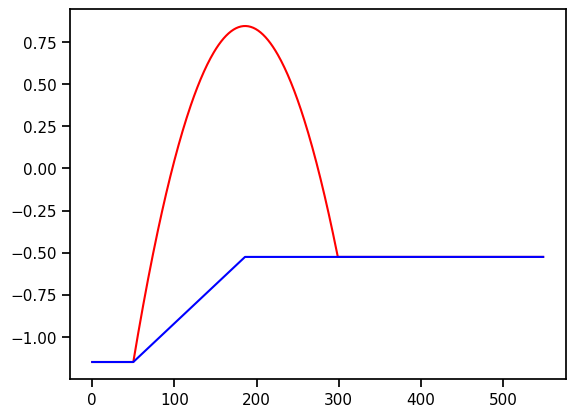

In [16]:
gdir = gdirs[0] # Aletsch
delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

# let's define our overshoot (temperature bias series that we apply on th 2009+/-10 yr climate)
x = np.arange(0,250,1)
ny_s=50
t0 = ny_s
ny_e=250
t1 = ny_e +ny_s
a = -0.00010772
b = 0.0024
c = delta_t

t = np.arange(t0, t1, 1)
y = a * (t - t0) * (t - t1) + b * (t - t0) + c

ys = np.concatenate([np.full(ny_s, y[0]), y, np.full(ny_e, y[-1])])
temp_bias_ts = pd.Series(ys-(y[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
temp_bias_ts = pd.concat([temp_bias_ts, pd.Series(index=np.arange(550,250+ny_s+ny_e,1), dtype='float64')])
temp_bias_ts.loc[550:] = temp_bias_ts.loc[549]
temp_bias_ts.plot(color='red'); 

yr_max_os = temp_bias_ts.idxmax() - 50 
x = np.arange(0,yr_max_os,1)
y2 = (y[-1]-y[0])/yr_max_os*x + y[0]
ys2 = np.concatenate([np.full(ny_s, y2[0]), y2, np.full(ny_e+250-yr_max_os, y[-1])])

# now create a stabilisation timeseries that stabilises at the same final temp. level as the overshoot experiment
# (but without peaking and then declining). We define that it stabilised at the year where the overshoot peaks. 
temp_bias_ts_lin = pd.Series(ys2-(y2[0]-delta_t), index=np.arange(0,yr_max_os+ny_s+ny_e+250-yr_max_os,1))
#temp_bias_ts_lin = pd.Series(ys2-(y2[0]-delta_t), index=np.arange(0,250+ny_s+ny_e,1))
temp_bias_ts_lin = pd.concat([temp_bias_ts_lin, pd.Series(index=np.arange(550,250+ny_s+ny_e,1), dtype='float64')])
temp_bias_ts_lin.loc[550:] = temp_bias_ts_lin.loc[549]
temp_bias_ts_lin.plot(color='blue'); 




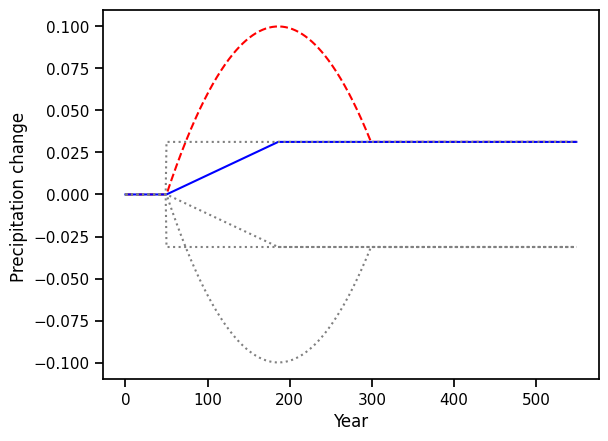

In [17]:
#f = np.array([-4.36202118e-12,  5.34151857e-09, -2.03858079e-06,
#              1.76227795e-04, 2.0097832e-02, -6.39048239e-01])
#y= f[5] + f[4]*x + f[3]*x**2+f[2]*x**3+f[1]*x**4 + f[0]*x**5
# yr_max_os = 250 # this was before 
# -50 because of the first 50 years that are added later
yr_max_os = temp_bias_ts.idxmax() - 50 

delta_p = -0.452
ys = np.concatenate([np.full(ny_s, y[0]), y, np.full(ny_e, y[-1])])
delta_all = -(ys*0.05-y[0])[0]

prcp_fac_os = pd.Series(ys*0.05-y[0] + delta_all,
                                 #delta_p)-0.64,
                        index=np.arange(0,250+ny_s+ny_e,1))
#prcp_fac_os = pd.Series(ys*0.1-(y[0]-delta_p)-0.58, index=np.arange(0,250+ny_s+ny_e,1))

prcp_fac_os.plot(color='red',ls='--'); 


y2 = (y[-1]-y[0])/yr_max_os*x + y[0]
ys2 = np.concatenate([np.full(ny_s, y2[0]), y2, np.full(ny_e+250-yr_max_os, y[-1])])

prcp_fac_lin = pd.Series(ys2*0.05-y2[0]+ delta_all, index=np.arange(0,yr_max_os+ny_s+ny_e+250-yr_max_os,1))
prcp_fac_lin.plot(color='blue'); 

prcp_fac_step = np.concatenate([np.repeat(prcp_fac_lin.iloc[0], ny_s),
                                 np.repeat(prcp_fac_lin.iloc[-1], ny_e+250)])
prcp_fac_step = pd.Series(prcp_fac_step, index=np.arange(0,250+ny_s+ny_e,1))
prcp_fac_step.plot(color='grey', ls=':'); plt.xlabel('Year'); plt.ylabel('Precipitation factor change');
(-prcp_fac_step).plot(color='grey',ls=':'); plt.xlabel('Year'); plt.ylabel('Precipitation change change');
(-prcp_fac_lin).plot(color='grey',ls=':'); plt.xlabel('Year'); plt.ylabel('Precipitation change change');
(-prcp_fac_os).plot(color='grey',ls=':'); plt.xlabel('Year'); plt.ylabel('Precipitation change ');


In [18]:
add = ''
# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix=f'_oversh_temp{add}_short');  # an identifier for the output file, to read it later

# linear temp. change
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts_lin,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix=f'_spinup{add}',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix= f'_lin_temp{add}_short');  # an identifier for the output file, to read it later

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                    prcp_fac_ts = prcp_fac_os,
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix='_oversh_temp_prcp_inc');  # an identifier for the output file, to read it later

# linear temp. change
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts_lin,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     prcp_fac_ts = prcp_fac_lin,
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix= '_lin_temp_prcp_inc');  # an identifier for the output file, to read it later

# We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
                    prcp_fac_ts = -prcp_fac_os,
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix='_oversh_temp_prcp_dec');  # an identifier for the output file, to read it later

# linear temp. change
tasks.run_with_hydro(gdir,
                     temp_bias_ts=temp_bias_ts_lin,  # the temperature bias timeseries we just created
                     run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
                     prcp_fac_ts = -prcp_fac_lin,
                     y0=2009, halfsize=10,  # Period which we will average and constantly repeat
                     store_monthly_hydro=True,  # Monthly ouptuts provide additional information
                     init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
                     output_filesuffix= '_lin_temp_prcp_dec');  # an identifier for the output file, to read it later

In [19]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp_short')) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()
    
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp_short')) as ds_lin:
    ds_lin = ds_lin.isel(time=slice(0, -1)).load()

sel_vars_m = [v for v in ds.variables if 'month_2d' in ds[v].dims]


with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp_prcp_inc')) as _ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds_prcp_ch_inc = _ds.isel(time=slice(0, -1)).load()
    
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp_prcp_inc')) as ds_lin_prcp_ch:
    ds_lin_prcp_ch_inc = ds_lin_prcp_ch.isel(time=slice(0, -1)).load()

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp_prcp_dec')) as _ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds_prcp_ch_dec = _ds.isel(time=slice(0, -1)).load()
    
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp_prcp_dec')) as ds_lin_prcp_ch:
    ds_lin_prcp_ch_dec = ds_lin_prcp_ch.isel(time=slice(0, -1)).load()


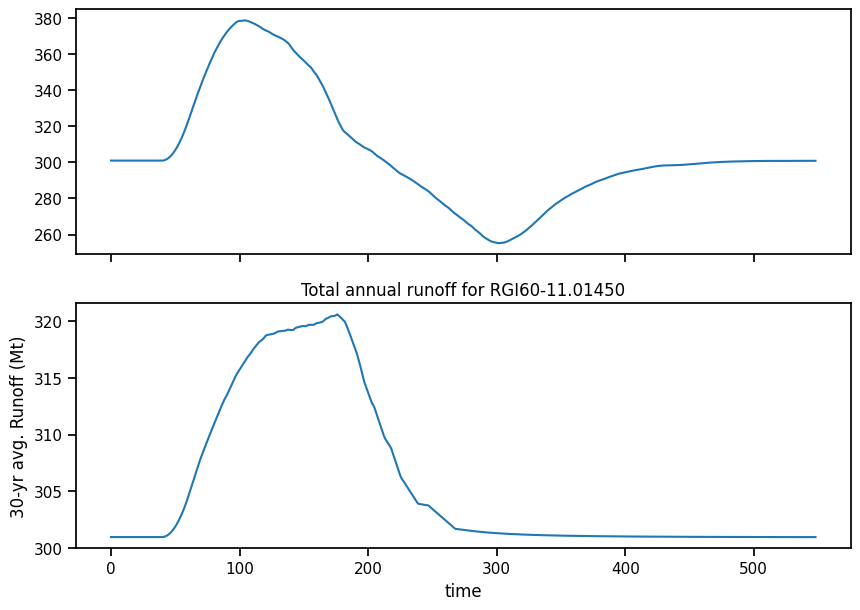

In [20]:
rgi_id = gdir.rgi_id
fig, axs = plt.subplots(2,1, figsize=(10, 7), sharex=True)
ax = axs[0]
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()

# Select only the runoff variables
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
# Convert them to megatonnes (instead of kg)
df_runoff = df_annual[runoff_vars] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff = df_runoff.rolling(roll, center=True, min_periods=1).mean()

labels_nice_dict = {'melt_off_glacier': 'melt off glacier',
 'melt_on_glacier': 'melt on glacier',
 'liq_prcp_off_glacier': 'liquid precipitation off glacier',
 'liq_prcp_on_glacier': 'liquid precipitation on glacier'}

df_runoff = df_runoff.rename(columns=labels_nice_dict)
df_runoff.sum(axis=1).plot(ax=ax);
plt.ylabel('30-yr avg. Runoff (Mt)'); plt.xlabel('Years'); plt.title(f'Total annual runoff for {rgi_id}');


df_annual_prcp_ch_inc = ds_prcp_ch_inc[sel_vars].to_dataframe()
df_runoff_prcp_ch_inc = df_annual_prcp_ch_inc[runoff_vars] * 1e-9
df_runoff_prcp_ch_inc = df_runoff_prcp_ch_inc.rolling(roll, center=True, min_periods=1).mean()
df_runoff_prcp_ch_inc = df_runoff_prcp_ch_inc.rename(columns=labels_nice_dict)

df_annual_prcp_ch_dec = ds_prcp_ch_dec[sel_vars].to_dataframe()
df_runoff_prcp_ch_dec = df_annual_prcp_ch_dec[runoff_vars] * 1e-9
df_runoff_prcp_ch_dec = df_runoff_prcp_ch_dec.rolling(roll, center=True, min_periods=1).mean()
df_runoff_prcp_ch_dec = df_runoff_prcp_ch_dec.rename(columns=labels_nice_dict)

##############_
ax = axs[1]
sel_vars = [v for v in ds_lin.variables if 'month_2d' not in ds_lin[v].dims]
df_annual_lin = ds_lin[sel_vars].to_dataframe()

# Convert them to megatonnes (instead of kg)
df_runoff_lin = df_annual_lin[runoff_vars] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff_lin = df_runoff_lin.rolling(roll, center=True, min_periods=1).mean()

df_runoff_lin = df_runoff_lin.rename(columns=labels_nice_dict)
df_runoff_lin.sum(axis=1).plot(ax=ax);

df_annual_lin_prcp_ch_inc = ds_lin_prcp_ch_inc[sel_vars].to_dataframe()
df_runoff_lin_prcp_ch_inc = df_annual_lin_prcp_ch_inc[runoff_vars] * 1e-9
df_runoff_lin_prcp_ch_inc = df_runoff_lin_prcp_ch_inc.rolling(roll, center=True, min_periods=1).mean()
df_runoff_lin_prcp_ch_inc = df_runoff_lin_prcp_ch_inc.rename(columns=labels_nice_dict)

df_annual_lin_prcp_ch_dec = ds_lin_prcp_ch_dec[sel_vars].to_dataframe()
df_runoff_lin_prcp_ch_dec = df_annual_lin_prcp_ch_dec[runoff_vars] * 1e-9
df_runoff_lin_prcp_ch_dec = df_runoff_lin_prcp_ch_dec.rolling(roll, center=True, min_periods=1).mean()
df_runoff_lin_prcp_ch_dec = df_runoff_lin_prcp_ch_dec.rename(columns=labels_nice_dict)



In [21]:
#roll = 1 # just for suppl. fig. S1
roll = 21 #21 #21 # 21 #1 #31
if roll == 1:
    roll_info = '_no_rolling_average'
elif roll == 21:
    roll_info = '_21_year_rolling_average'

df_summer = ds[sel_vars_m].sel(month_2d=slice(m_s,m_e)).sum(dim='month_2d').to_dataframe()
# Convert them to megatonnes (instead of kg)
df_runoff_sum = df_summer[runoff_vars_monthly] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff_sum = df_runoff_sum.rolling(roll, center=True, min_periods=1).mean()
df_runoff_sum = df_runoff_sum.rename(columns=labels_nice_dict)


##############_
df_summer_lin = ds_lin[sel_vars_m].sel(month_2d=slice(m_s,m_e)).sum(dim='month_2d').to_dataframe()
# Convert them to megatonnes (instead of kg)
df_runoff_sum_lin = df_summer_lin[runoff_vars_monthly] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff_sum_lin = df_runoff_sum_lin.rolling(roll, center=True, min_periods=1).mean()
df_runoff_sum_lin = df_runoff_sum_lin.rename(columns=labels_nice_dict)


####
df_dry = ds[sel_vars_m].sel(month_2d=slice(m_s,m_e)).sum(dim='month_2d').to_dataframe()
# Convert them to megatonnes (instead of kg)
df_runoff_dry = df_dry[runoff_vars_monthly] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff_dry = df_runoff_dry.rolling(roll, center=True, min_periods=1).mean()
df_runoff_dry = df_runoff_dry.rename(columns=labels_nice_dict)

##############_
df_dry_lin = ds_lin[sel_vars_m].sel(month_2d=slice(m_s,m_e)).sum(dim='month_2d').to_dataframe()
# Convert them to megatonnes (instead of kg)
df_runoff_dry_lin = df_dry_lin[runoff_vars_monthly] * 1e-9
# We smooth the output, which is otherwize noisy because of area discretization
df_runoff_dry_lin = df_runoff_dry_lin.rolling(roll, center=True, min_periods=1).mean()
df_runoff_dry_lin = df_runoff_dry_lin.rename(columns=labels_nice_dict)


/tmp/ipykernel_2659775/3372020488.py:379: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


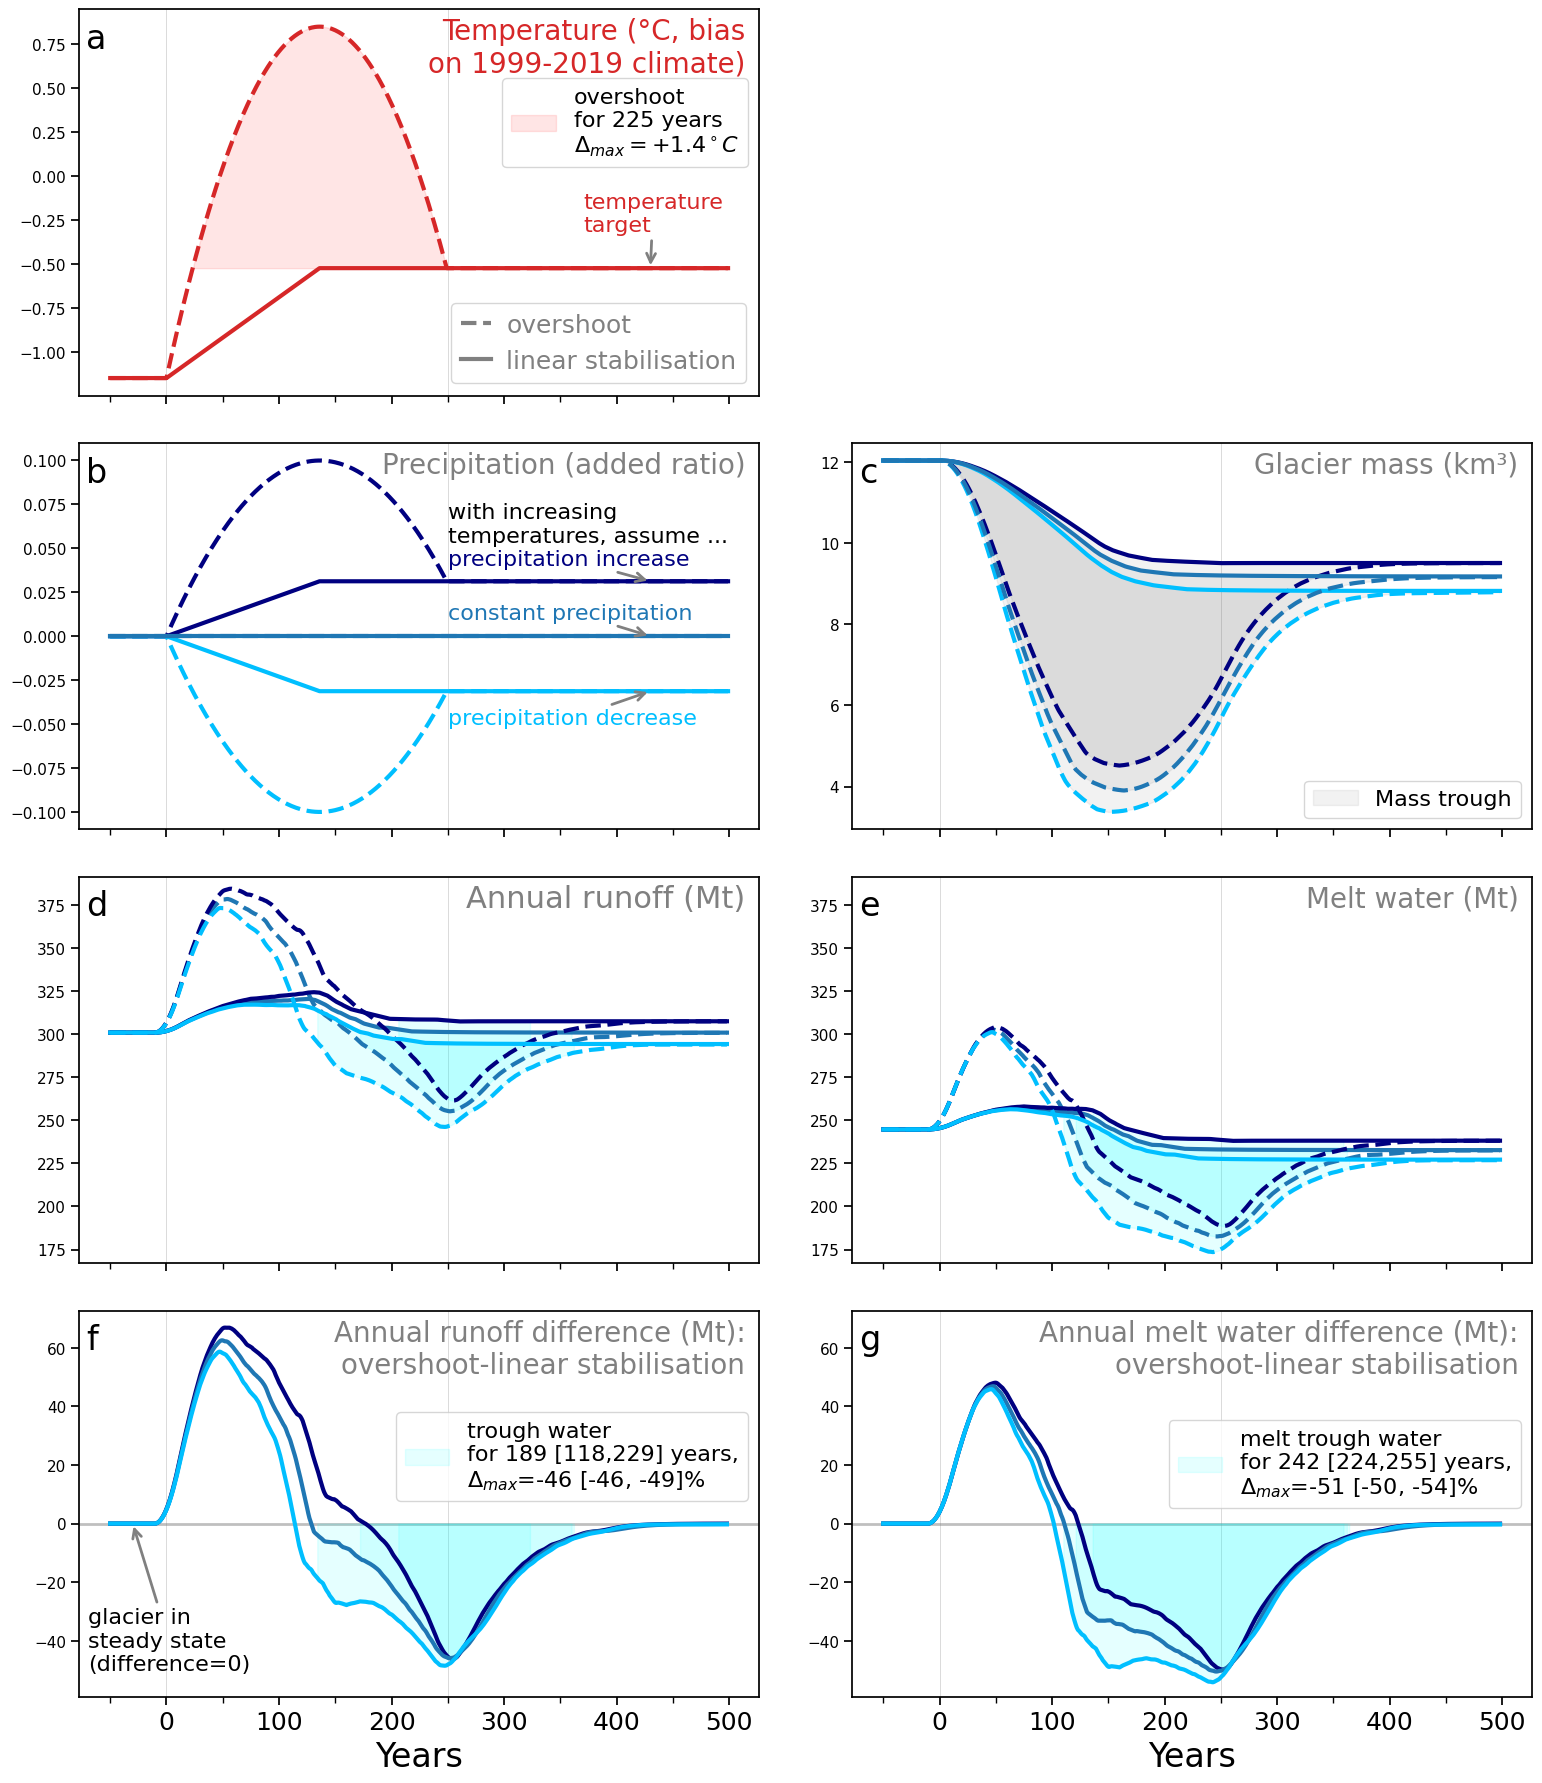

In [22]:
plt.rc('font', size=26)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 18), sharex=True)
axs = axs.flatten()
#ds.length_m.plot(ax=axs[1]);
#temp_bias_step.plot(ax=axs[0], c='C3', ls=':', label='step change');
temp_bias_ts.plot(ax=axs[0], c='C3', label='overshoot', lw=3, ls='--');
temp_bias_ts_lin.plot(ax=axs[0], c='C3', label='linear stabilisation', lw=3,ls='-');


#(temp_bias_ts-temp_bias_ts_lin).plot(ax=axs[0], c='C3', label='overshoot', lw=3);
axs[0].text(0.98, 0.98, 'Temperature (°C, bias\non 1999-2019 climate)',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=20, color='C3')
leg = axs[0].legend(fontsize=18, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6,
                    loc = 'lower right', ncol=1) # bbox_to_anchor=(0,1.01), ncol=3)
axs[0].set_xlabel(''); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

for j in np.arange(0,2,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')


axs[0].annotate('temperature\ntarget',(480,temp_bias_ts_lin.iloc[-1]), xytext=(420,temp_bias_ts_lin.iloc[-1]*0.6),
                color='C3',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=16)

diff_temp = temp_bias_ts - temp_bias_ts_lin.max()
nyears_temp = len(diff_temp.where(diff_temp >0.01).dropna())
axs[0].fill_between(temp_bias_ts.index, np.repeat(temp_bias_ts_lin.max(), 550), #temp_bias_ts_lin.where(diff_temp >0.01),
                temp_bias_ts.where(diff_temp >0.01), alpha=0.1, color='red',
                    label='overshoot\n'+f'for {nyears_temp} years\n'+r'$\Delta_{max}=$+'+f'{np.round(diff_temp.max(),1)}'+r'$^\circ C$')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend([handles[-1]], [labels[-1]], loc = 'upper right', bbox_to_anchor=(1,0.85), fontsize=16)
axs[0].add_artist(leg)


#ds.length_m.plot(ax=axs[1]);
ax = axs[2]
prcp_fac_lin.plot(ax=ax, c='navy', ls='-', label='linear change',lw=3);
prcp_fac_os.plot(ax=ax, c='navy', ls='--',label='overshoot', lw=3);

ax.text(300,prcp_fac_step.iloc[-1]*1.72,'with increasing\ntemperatures, assume ...', fontsize=16, color='black')
ax.annotate('precipitation increase',(480,prcp_fac_step.iloc[-1]), xytext=(300,prcp_fac_step.iloc[-1]*1.3),
                color='navy',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=16)


(-prcp_fac_lin).plot(ax=ax, c='deepskyblue', ls='-', label='linear change',lw=3);
(-prcp_fac_os).plot(ax=ax, c='deepskyblue', ls='--',label='overshoot', lw=3);
ax.annotate('precipitation decrease',(480,-prcp_fac_step.iloc[-1]), xytext=(300,-prcp_fac_step.iloc[-1]*1.6),
                color='deepskyblue',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=16)


(-prcp_fac_lin*0).plot(ax=ax, c='C0', ls='-', label='linear change',lw=3);
(-prcp_fac_os*0).plot(ax=ax, c='C0', ls='--',label='overshoot', lw=3);
ax.annotate('constant precipitation ',(480,0), xytext=(300,0.01),
                color='C0',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=16)


ax.text(0.98, 0.98, 'Precipitation (added ratio)',
         ha='right', va='top', transform=ax.transAxes, 
        fontsize=20, color='grey')
#leg = ax.legend(fontsize=18, frameon=True,handlelength=1.2, columnspacing=1,
#                    handletextpad=0.6,
#                    loc = 'lower left', bbox_to_anchor=(0,1.01), ncol=3)
ax.set_xlabel(''); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

#for j in np.arange(0,3,1):
#    leg.get_lines()[j].set_color('grey')
#    leg.get_texts()[j].set_color('grey')



###
ax = axs[3]
ax.text(0.98, 0.98, 'Glacier mass (km³)',
         ha='right', va='top', transform=ax.transAxes, 
        fontsize=20, color='grey')
#(ds_step_prcp_ch_inc.volume_m3/1e9).plot(ax=ax, c='navy', ls=':');
(ds_lin_prcp_ch_inc.volume_m3/1e9).plot(ax=ax, c='navy', ls ='-' ,lw=3);
(ds_prcp_ch_inc.volume_m3/1e9).plot(ax=ax, c='navy', ls='--', lw=3);

diff = (-ds_lin_prcp_ch_inc.volume_m3.min()/1e9+ds_prcp_ch_inc.volume_m3/1e9)
vol_perc_min_inc = int(np.round(100*diff.min() / (ds_lin_prcp_ch_inc.volume_m3.min()/1e9), 0))

diff_scen = (-ds_lin_prcp_ch_inc.volume_m3+ds_prcp_ch_inc.volume_m3)

ax.fill_between(ds.time, (ds_lin_prcp_ch_inc.volume_m3/1e9).where(diff_scen<-0.01), # (ds_lin_prcp_ch_inc.volume_m3.min()/1e9).where(diff<-0.01),
                (ds_prcp_ch_inc.volume_m3/1e9).where(diff_scen <-0.01), alpha=0.1, color='grey')    


#(ds_step_prcp_ch_dec.volume_m3/1e9).plot(ax=ax, c='deepskyblue', ls=':');
(ds_lin_prcp_ch_dec.volume_m3/1e9).plot(ax=ax, c='deepskyblue', ls ='-' ,lw=3);
(ds_prcp_ch_dec.volume_m3/1e9).plot(ax=ax, c='deepskyblue', ls='--', lw=3);
diff = (-ds_lin_prcp_ch_dec.volume_m3.min()/1e9+ds_prcp_ch_dec.volume_m3/1e9)
vol_perc_min_dec = int(np.round(100*diff.min() / (ds_lin_prcp_ch_dec.volume_m3.min()/1e9), 0))
diff_scen = (-ds_lin_prcp_ch_dec.volume_m3+ds_prcp_ch_dec.volume_m3)
ax.fill_between(ds.time, (ds_lin_prcp_ch_dec.volume_m3/1e9).where(diff_scen<-0.01), #(ds_lin_prcp_ch_dec.volume_m3.min()/1e9).where(diff<-0.01),
                (ds_prcp_ch_dec.volume_m3/1e9).where(diff_scen <-0.01), alpha=0.1, color='grey') #, label =f'Mass trough\n'+add_text)

#(ds_step.volume_m3/1e9).plot(ax=ax, c='C0', ls=':');
(ds_lin.volume_m3/1e9).plot(ax=ax, c='C0', ls ='-',lw=3);
(ds.volume_m3/1e9).plot(ax=ax, c='C0', ls='--', lw=3);
diff = (-ds_lin.volume_m3.min()/1e9+ds.volume_m3/1e9)
# how do you define it .. 

#diff.where(diff<-0.01).dropna(dim='time')
diff_scen = (-ds_lin.volume_m3+ds.volume_m3)
vol_perc_min = int(np.round(100*diff.min() / (ds_lin.volume_m3.min()/1e9), 0))
add_text = r'$\Delta_{max}=$'+f'{vol_perc_min} [{vol_perc_min_inc}, {vol_perc_min_dec}]'+r'$\%$'

ax.fill_between(ds.time, (ds_lin.volume_m3/1e9).where(diff_scen<-0.01), #(ds_lin.volume_m3.min()/1e9).where(diff<-0.01), # (ds_lin.volume_m3.min()/1e9).where(diff<-0.01), not the minimum but all ... 
                (ds.volume_m3/1e9).where(diff_scen <-0.01), alpha=0.1, color='grey',
                label='Mass trough') 
# , label =f'Maximum mass difference\n(overshoot vs linear)\n'+add_text)
# this is just confusing
ax.legend(loc='lower right', fontsize=16)
ax.set_ylabel('')


###
ax = axs[4]
ax.text(0.98, 0.98, 'Annual runoff (Mt)',
         ha='right', va='top', transform=ax.transAxes, 
        fontsize=22, color='grey')
#df_runoff_step.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='C0', ls=':');
df_runoff_lin.sum(axis=1).plot(ax=ax, label = 'linear stabilisation', c='C0', ls='-',lw=3);
df_runoff.sum(axis=1).plot(ax=ax, label = 'overshoot', c='C0', ls='--', lw=3);
#leg = ax.legend(fontsize=18, frameon=True,handlelength=1.2, columnspacing=1,
#                    handletextpad=0.6,
#                    loc = 'lower left',  ncol=3)
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

for j in np.arange(0,2,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')


diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
diff_initial = -df_runoff_lin.sum(axis=1).iloc[0] + df_runoff.sum(axis=1) 

ax.fill_between(df_runoff_lin.index,
                df_runoff_lin.sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                df_runoff.sum(axis=1).where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')


#df_runoff_step_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='navy', ls=':');
df_runoff_lin_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='navy', ls='-',lw=3);
df_runoff_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='navy', ls='--', lw=3);
diff = (-df_runoff_lin_prcp_ch_inc.sum(axis=1)+df_runoff_prcp_ch_inc.sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_inc.sum(axis=1).iloc[0] + df_runoff_prcp_ch_inc.sum(axis=1) 

ax.fill_between(df_runoff_lin_prcp_ch_inc.index,
                df_runoff_lin_prcp_ch_inc.sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                df_runoff_prcp_ch_inc.sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                alpha=0.1, color='cyan')


#df_runoff_step_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='deepskyblue', ls=':');
df_runoff_lin_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='deepskyblue', ls='-', lw=3);
df_runoff_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='deepskyblue', ls='--', lw=3);


#plt.ylabel('Runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
#ax.fill_between(df_runoff.index,
#                 df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')
diff = (-df_runoff_lin_prcp_ch_dec.sum(axis=1)+df_runoff_prcp_ch_dec.sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_dec.sum(axis=1).iloc[0] + df_runoff_prcp_ch_dec.sum(axis=1) 

ax.fill_between(df_runoff_lin_prcp_ch_dec.index,
                df_runoff_lin_prcp_ch_dec.sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                df_runoff_prcp_ch_dec.sum(axis=1).where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')
ylim_4 = axs[4].get_ylim()





ax = axs[6]
ax.text(0.98, 0.98, 'Annual runoff difference (Mt):\novershoot-linear stabilisation',
         ha='right', va='top', transform=ax.transAxes, 
        fontsize=20, color='grey')



#df_runoff_step_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='C0', ls=':');
#df_runoff_lin_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='C0', ls='--');
(-df_runoff_lin_prcp_ch_inc.sum(axis=1)+df_runoff_prcp_ch_inc.sum(axis=1)).plot(ax=ax, label = 'precipitation increase', c='navy', ls='-', lw=3);
#(-df_runoff_step_prcp_ch_inc.sum(axis=1)+df_runoff_prcp_ch_inc.sum(axis=1)).plot(ax=ax, label = 'Annual runoff', c='C0', ls='-', lw=3);
diff = (-df_runoff_lin_prcp_ch_inc.sum(axis=1)+df_runoff_prcp_ch_inc.sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_inc.sum(axis=1).iloc[0] + df_runoff_prcp_ch_inc.sum(axis=1) 

nyears_inc = len(diff.where((diff<=-5)&(diff_initial<=-5)).dropna())
water_trough_max_diff_inc = np.round(diff.where((diff<=-5)&(diff_initial<=-5)).min(),0)
ax.fill_between(df_runoff_lin_prcp_ch_inc.index, np.repeat(0,549), diff.where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')

#df_runoff_step.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='black', ls=':');
#df_runoff_lin.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='black', ls='--');
(-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1)).plot(ax=ax, label = 'constant precipitation', c='C0', ls='-', lw=3);
diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
diff_initial = -df_runoff_lin.sum(axis=1).iloc[0] + df_runoff.sum(axis=1) 

nyears = len(diff.where((diff<=-5)&(diff_initial<=-5)).dropna())
water_trough_max_diff = np.round(diff.where((diff<=-5)&(diff_initial<=-5)).min(),0)
ax.fill_between(df_runoff_lin.index, np.repeat(0,549), diff.where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')
#(-df_runoff_step.sum(axis=1)+df_runoff.sum(axis=1)).plot(ax=ax, label = 'Annual runoff', c='black', ls='-', lw=3);

#df_runoff_step_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='brown', ls=':');
#df_runoff_lin_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='brown', ls='--');
(-df_runoff_lin_prcp_ch_dec.sum(axis=1)+df_runoff_prcp_ch_dec.sum(axis=1)).plot(ax=ax, label = 'precipitation decrease', c='deepskyblue',
                                                                                ls='-', lw=3);
diff = (-df_runoff_lin_prcp_ch_dec.sum(axis=1)+df_runoff_prcp_ch_dec.sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_dec.sum(axis=1).iloc[0] + df_runoff_prcp_ch_dec.sum(axis=1) 

nyears_dec = len(diff.where((diff<=-5)&(diff_initial<=-5)).dropna())
water_trough_max_diff_dec = np.round(diff.where((diff<=-5)&(diff_initial<=-5)).min(),0)
add_text = f'for {int(nyears)} [{nyears_inc},{nyears_dec}] years,\n' + r'$\Delta_{max}$='+f'{int(water_trough_max_diff)} [{int(water_trough_max_diff_inc)}, {int(water_trough_max_diff_dec)}]'+r'$\%$'
ax.fill_between(df_runoff_lin_prcp_ch_dec.index, np.repeat(0,549), 
                diff.where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan', label='trough water\n'+add_text)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1]], [labels[-1]], loc='lower right', fontsize=16, bbox_to_anchor=(1,0.48))
#(-df_runoff_step_prcp_ch_dec.sum(axis=1)+df_runoff_prcp_ch_dec.sum(axis=1)).plot(ax=ax, label = 'Annual runoff', c='brown', ls='-', lw=3);
ax.axhline(0,lw=2,color='grey', zorder=-1, alpha =0.5)
#plt.legend(title='with increasing temperature, \nassume that...', loc='lower right')



# Melt water\n(off and on glacier)
melt_cols = ['melt off glacier','melt on glacier']
ax = axs[5]
ax.text(0.98, 0.98, 'Melt water (Mt)', #':\non and off glacier',
         ha='right', va='top', transform=ax.transAxes, 
        fontsize=20, color='grey')
df_runoff_lin[melt_cols].sum(axis=1).plot(ax=ax, label = 'linear stabilisation', c='C0', ls='-',lw=3);
df_runoff[melt_cols].sum(axis=1).plot(ax=ax, label = 'overshoot', c='C0', ls='--', lw=3);

for j in np.arange(0,2,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')


diff = (-df_runoff_lin[melt_cols].sum(axis=1)+df_runoff[melt_cols].sum(axis=1))
diff_initial = -df_runoff_lin[melt_cols].sum(axis=1).iloc[0] + df_runoff[melt_cols].sum(axis=1) 

ax.fill_between(df_runoff_lin.index,
                df_runoff_lin[melt_cols].sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                df_runoff[melt_cols].sum(axis=1).where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')

df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1).plot(ax=ax,label = 'Melt water', c='navy', ls='-',lw=3);
df_runoff_prcp_ch_inc[melt_cols].sum(axis=1).plot(ax=ax,label = 'Melt water', c='navy', ls='--', lw=3);

diff = (-df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1)+df_runoff_prcp_ch_inc[melt_cols].sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1).iloc[0] + df_runoff_prcp_ch_inc[melt_cols].sum(axis=1) 

ax.fill_between(df_runoff_lin_prcp_ch_inc.index,
                df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                df_runoff_prcp_ch_inc[melt_cols].sum(axis=1).where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')


df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1).plot(ax=ax, label = 'Melt water', c='deepskyblue', ls='-',lw=3);
df_runoff_prcp_ch_dec[melt_cols].sum(axis=1).plot(ax=ax, label = 'Melt water', c='deepskyblue', ls='--', lw=3);

diff = (-df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1)+df_runoff_prcp_ch_dec[melt_cols].sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1).iloc[0] + df_runoff_prcp_ch_dec[melt_cols].sum(axis=1) 

ax.fill_between(df_runoff_lin_prcp_ch_dec.index,
                df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1).where((diff<=-5)&(diff_initial<=-5)),
                df_runoff_prcp_ch_dec[melt_cols].sum(axis=1).where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')
ylim_5 = axs[5].get_ylim()


####################
ax = axs[7]
ax.text(0.98, 0.98, 'Annual melt water difference (Mt):\novershoot-linear stabilisation',
         ha='right', va='top', transform=ax.transAxes, 
        fontsize=20, color='grey')



#df_runoff_step_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='C0', ls=':');
#df_runoff_lin_prcp_ch_inc.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='C0', ls='--');
(-df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1)+df_runoff_prcp_ch_inc[melt_cols].sum(axis=1)).plot(ax=ax, label = 'precipitation increase', c='navy', ls='-', lw=3);
#(-df_runoff_step_prcp_ch_inc.sum(axis=1)+df_runoff_prcp_ch_inc.sum(axis=1)).plot(ax=ax, label = 'Annual runoff', c='C0', ls='-', lw=3);
diff = (-df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1)+df_runoff_prcp_ch_inc[melt_cols].sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_inc[melt_cols].sum(axis=1).iloc[0] + df_runoff_prcp_ch_inc[melt_cols].sum(axis=1) 

ax.fill_between(df_runoff_lin_prcp_ch_inc.index, np.repeat(0,549), diff.where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')
#ax.axvline(diff.idxmax(), alpha=0.1, ls='-', c='navy', zorder=-1)
#ax.axvline(diff.idxmin(), alpha=0.1, ls='-', c='navy', zorder=-1)
nyears_inc = len(diff.where((diff<=-5)&(diff_initial<=-5)).dropna())
water_trough_max_diff_inc = np.round(diff.where((diff<=-5)&(diff_initial<=-5)).min(),0)

#df_runoff_step.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='black', ls=':');
#df_runoff_lin.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='black', ls='--');
(-df_runoff_lin[melt_cols].sum(axis=1)+df_runoff[melt_cols].sum(axis=1)).plot(ax=ax, label = 'constant precipitation', c='C0', ls='-', lw=3);
diff = (-df_runoff_lin[melt_cols].sum(axis=1)+df_runoff[melt_cols].sum(axis=1))
diff_initial = -df_runoff_lin[melt_cols].sum(axis=1).iloc[0] + df_runoff[melt_cols].sum(axis=1) 

ax.fill_between(df_runoff_lin.index, np.repeat(0,549), diff.where((diff<=-5)&(diff_initial<=-5)), alpha=0.1, color='cyan')
#ax.axvline(diff.idxmax(), alpha=0.1, ls='-', c='C0', zorder=-1)
#ax.axvline(diff.idxmin(), alpha=0.1, ls='-', c='C0', zorder=-1)
nyears = len(diff.where((diff<=-5)&(diff_initial<=-5)).dropna())
water_trough_max_diff = np.round(diff.where((diff<=-5)&(diff_initial<=-5)).min(),0)

#df_runoff_step_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='brown', ls=':');
#df_runoff_lin_prcp_ch_dec.sum(axis=1).plot(ax=ax, label = 'Annual runoff', c='brown', ls='--');
(-df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1)+df_runoff_prcp_ch_dec[melt_cols].sum(axis=1)).plot(ax=ax,
                                                                                                      label = 'precipitation decrease',
                                                                                                      c='deepskyblue', ls='-', lw=3);
diff = (-df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1)+df_runoff_prcp_ch_dec[melt_cols].sum(axis=1))
diff_initial = -df_runoff_lin_prcp_ch_dec[melt_cols].sum(axis=1).iloc[0] + df_runoff_prcp_ch_dec[melt_cols].sum(axis=1) 

nyears_dec = len(diff.where((diff<=-5)&(diff_initial<=-5)).dropna())
water_trough_max_diff_dec = np.round(diff.where((diff<=-5)&(diff_initial<=-5)).min(),0)

add_text = f'for {int(nyears)} [{nyears_inc},{nyears_dec}] years,\n' + r'$\Delta_{max}$='+f'{int(water_trough_max_diff)} [{int(water_trough_max_diff_inc)}, {int(water_trough_max_diff_dec)}]'+r'$\%$'
ax.fill_between(df_runoff_lin_prcp_ch_dec.index, np.repeat(0,549), diff.where((diff<=-5)&(diff_initial<=-5)),
                alpha=0.1, color='cyan', label='melt trough water\n'+add_text)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1]], [labels[-1]], loc='lower right', fontsize=16, bbox_to_anchor=(1,0.46))
#ax.axvline(diff.idxmax(), alpha=0.1, ls='-', c='deepskyblue', zorder=-1)
#ax.axvline(diff.idxmin(), alpha=0.1, ls='-', c='deepskyblue', zorder=-1)

#(-df_runoff_step_prcp_ch_dec.sum(axis=1)+df_runoff_prcp_ch_dec.sum(axis=1)).plot(ax=ax, label = 'Annual runoff', c='brown', ls='-', lw=3);
ax.axhline(0,lw=2,color='grey', zorder=-1, alpha =0.5)
#plt.legend(title='with increasing temperature, \nassume that...', loc='lower right')

for j,ax in enumerate(axs):
    #ax.set_yticks([]);
    ax.set_xticks([],[])
    ax.axvline(300, ls='-', lw=0.5, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.5, alpha =0.4, color='grey', zorder=0)
#axs[2].set_xlabel('Time', fontsize=22); #axs[0].set_ylabel('Temperature bias (°C)');


axs[6].annotate('glacier in\nsteady state\n(difference=0)',(20,0), xytext=(-20,0-50), color='black',
       arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=16)


ylim_4_5 = [np.array([ylim_4[0], ylim_5[0]]).min(), np.array([ylim_4[1], ylim_5[1]]).max()]
axs[4].set_ylim(ylim_4_5)
axs[5].set_ylim(ylim_4_5)

ylim_6 = axs[6].get_ylim()
ylim_7 = axs[7].get_ylim()
ylim_6_7 = [np.array([ylim_6, ylim_7]).min(), np.array([ylim_6, ylim_7]).max()]
axs[6].set_ylim(ylim_6_7)
axs[7].set_ylim(ylim_6_7)


fig.delaxes(axs[1])

num_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4: 'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m'} 

plt.tight_layout();


num_text_x = 0.01
num_text_y = 0.9  
ax.text(num_text_x, num_text_y,
    num_dict[0], fontsize=24, transform=axs[0].transAxes)
for j,ax in enumerate(axs[2:]):
    ax.text(num_text_x, num_text_y,
            num_dict[j+1], fontsize=24, transform=ax.transAxes)

axs[-2].set_xlabel('Years', fontsize=24); #axs[0].set_ylabel('Temperature bias (°C)');
axs[-1].set_xlabel('Years', fontsize=24); #axs[0].set_ylabel('Temperature bias (°C)');
axs[-2].set_xticks(np.arange(50,551,100), np.arange(50,551,100)-50, fontsize=18)
axs[-1].set_xticks(np.arange(50,551,100), np.arange(50,551,100)-50, fontsize=18)

plt.tight_layout()
plt.savefig('../figures/suppl_conceptual_model_w_prcp_ch_w_melt_no_xkcd.png')
plt.savefig('../figures/suppl_conceptual_model_w_prcp_ch_w_melt_no_xkcd.pdf')

# OLD --> REMOVE from here onwards ...

### Older figure variants

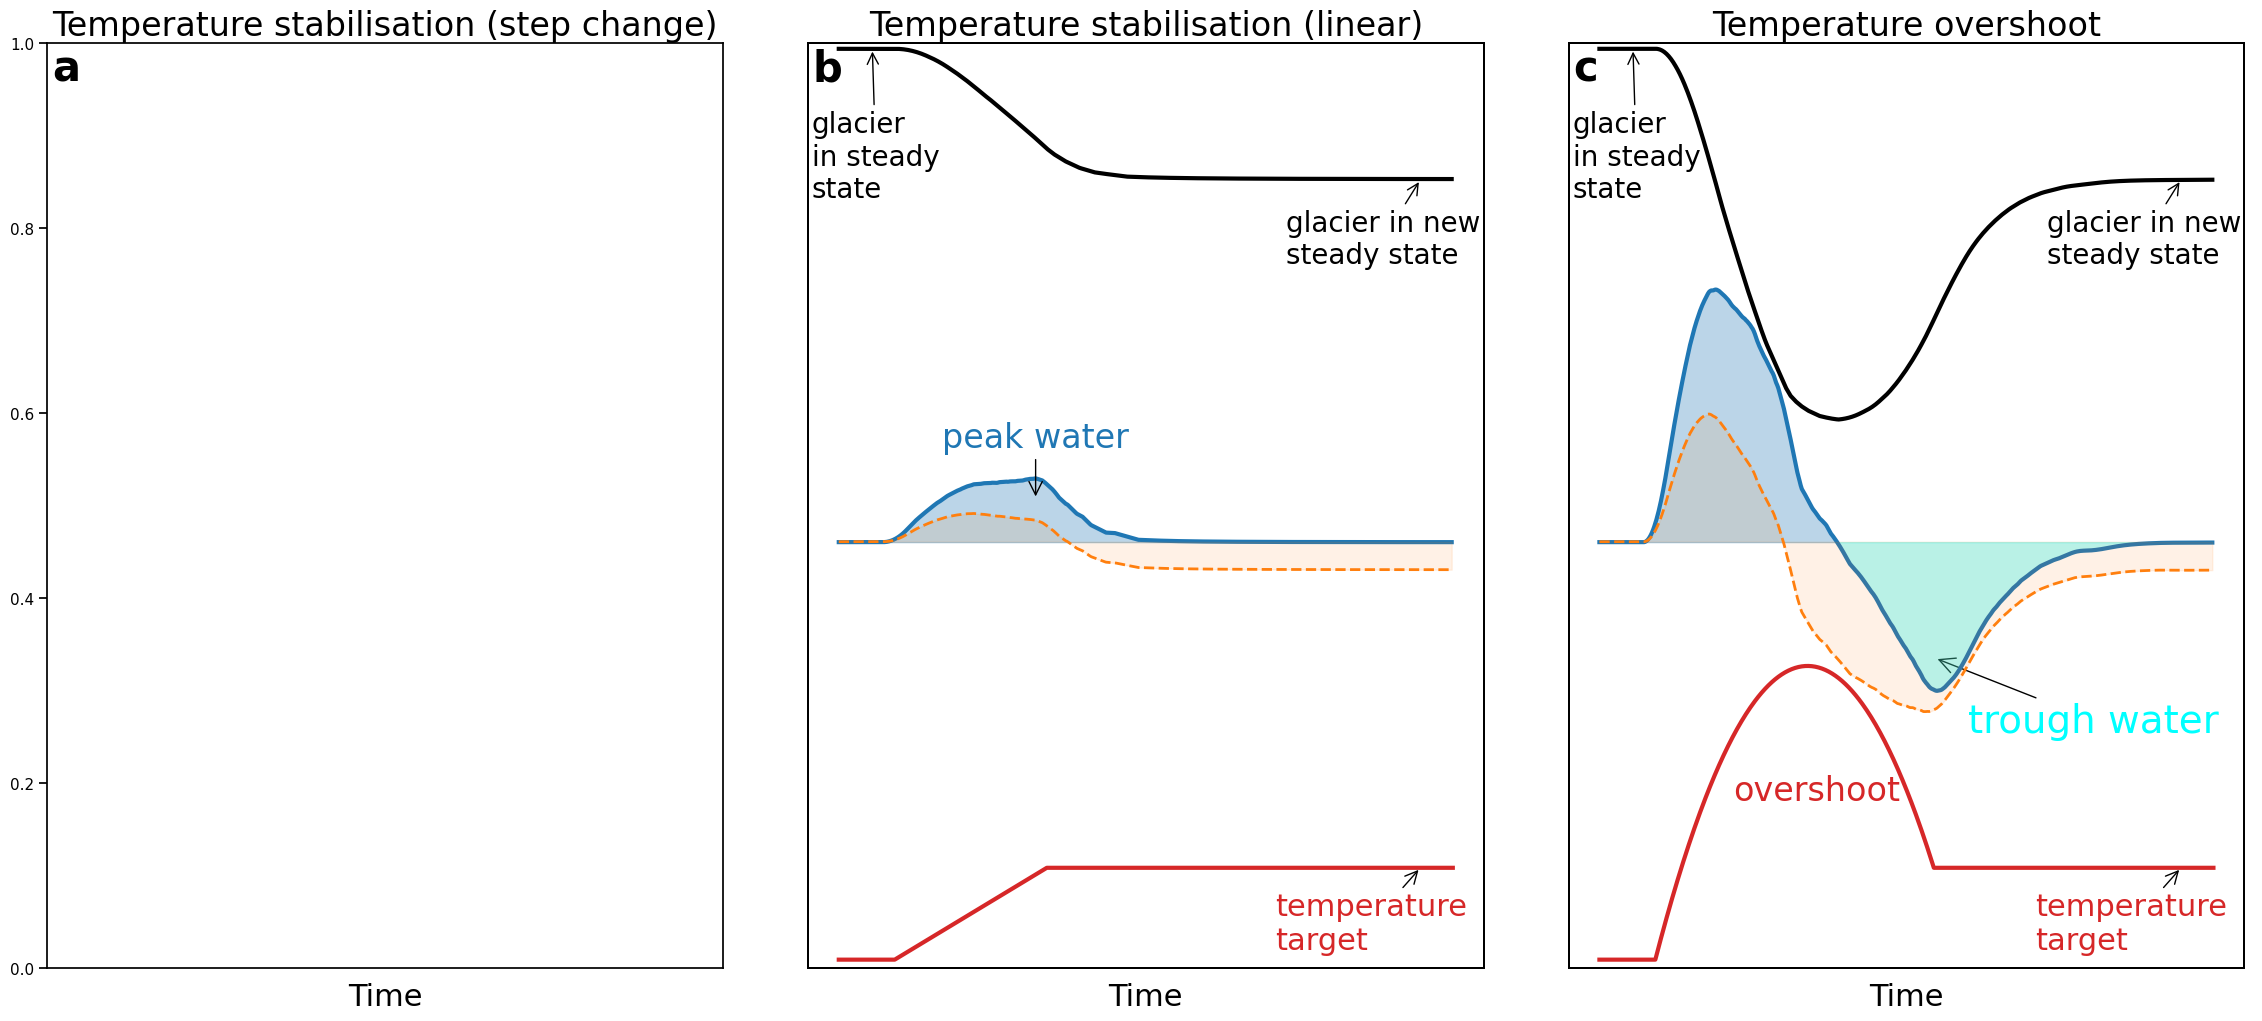

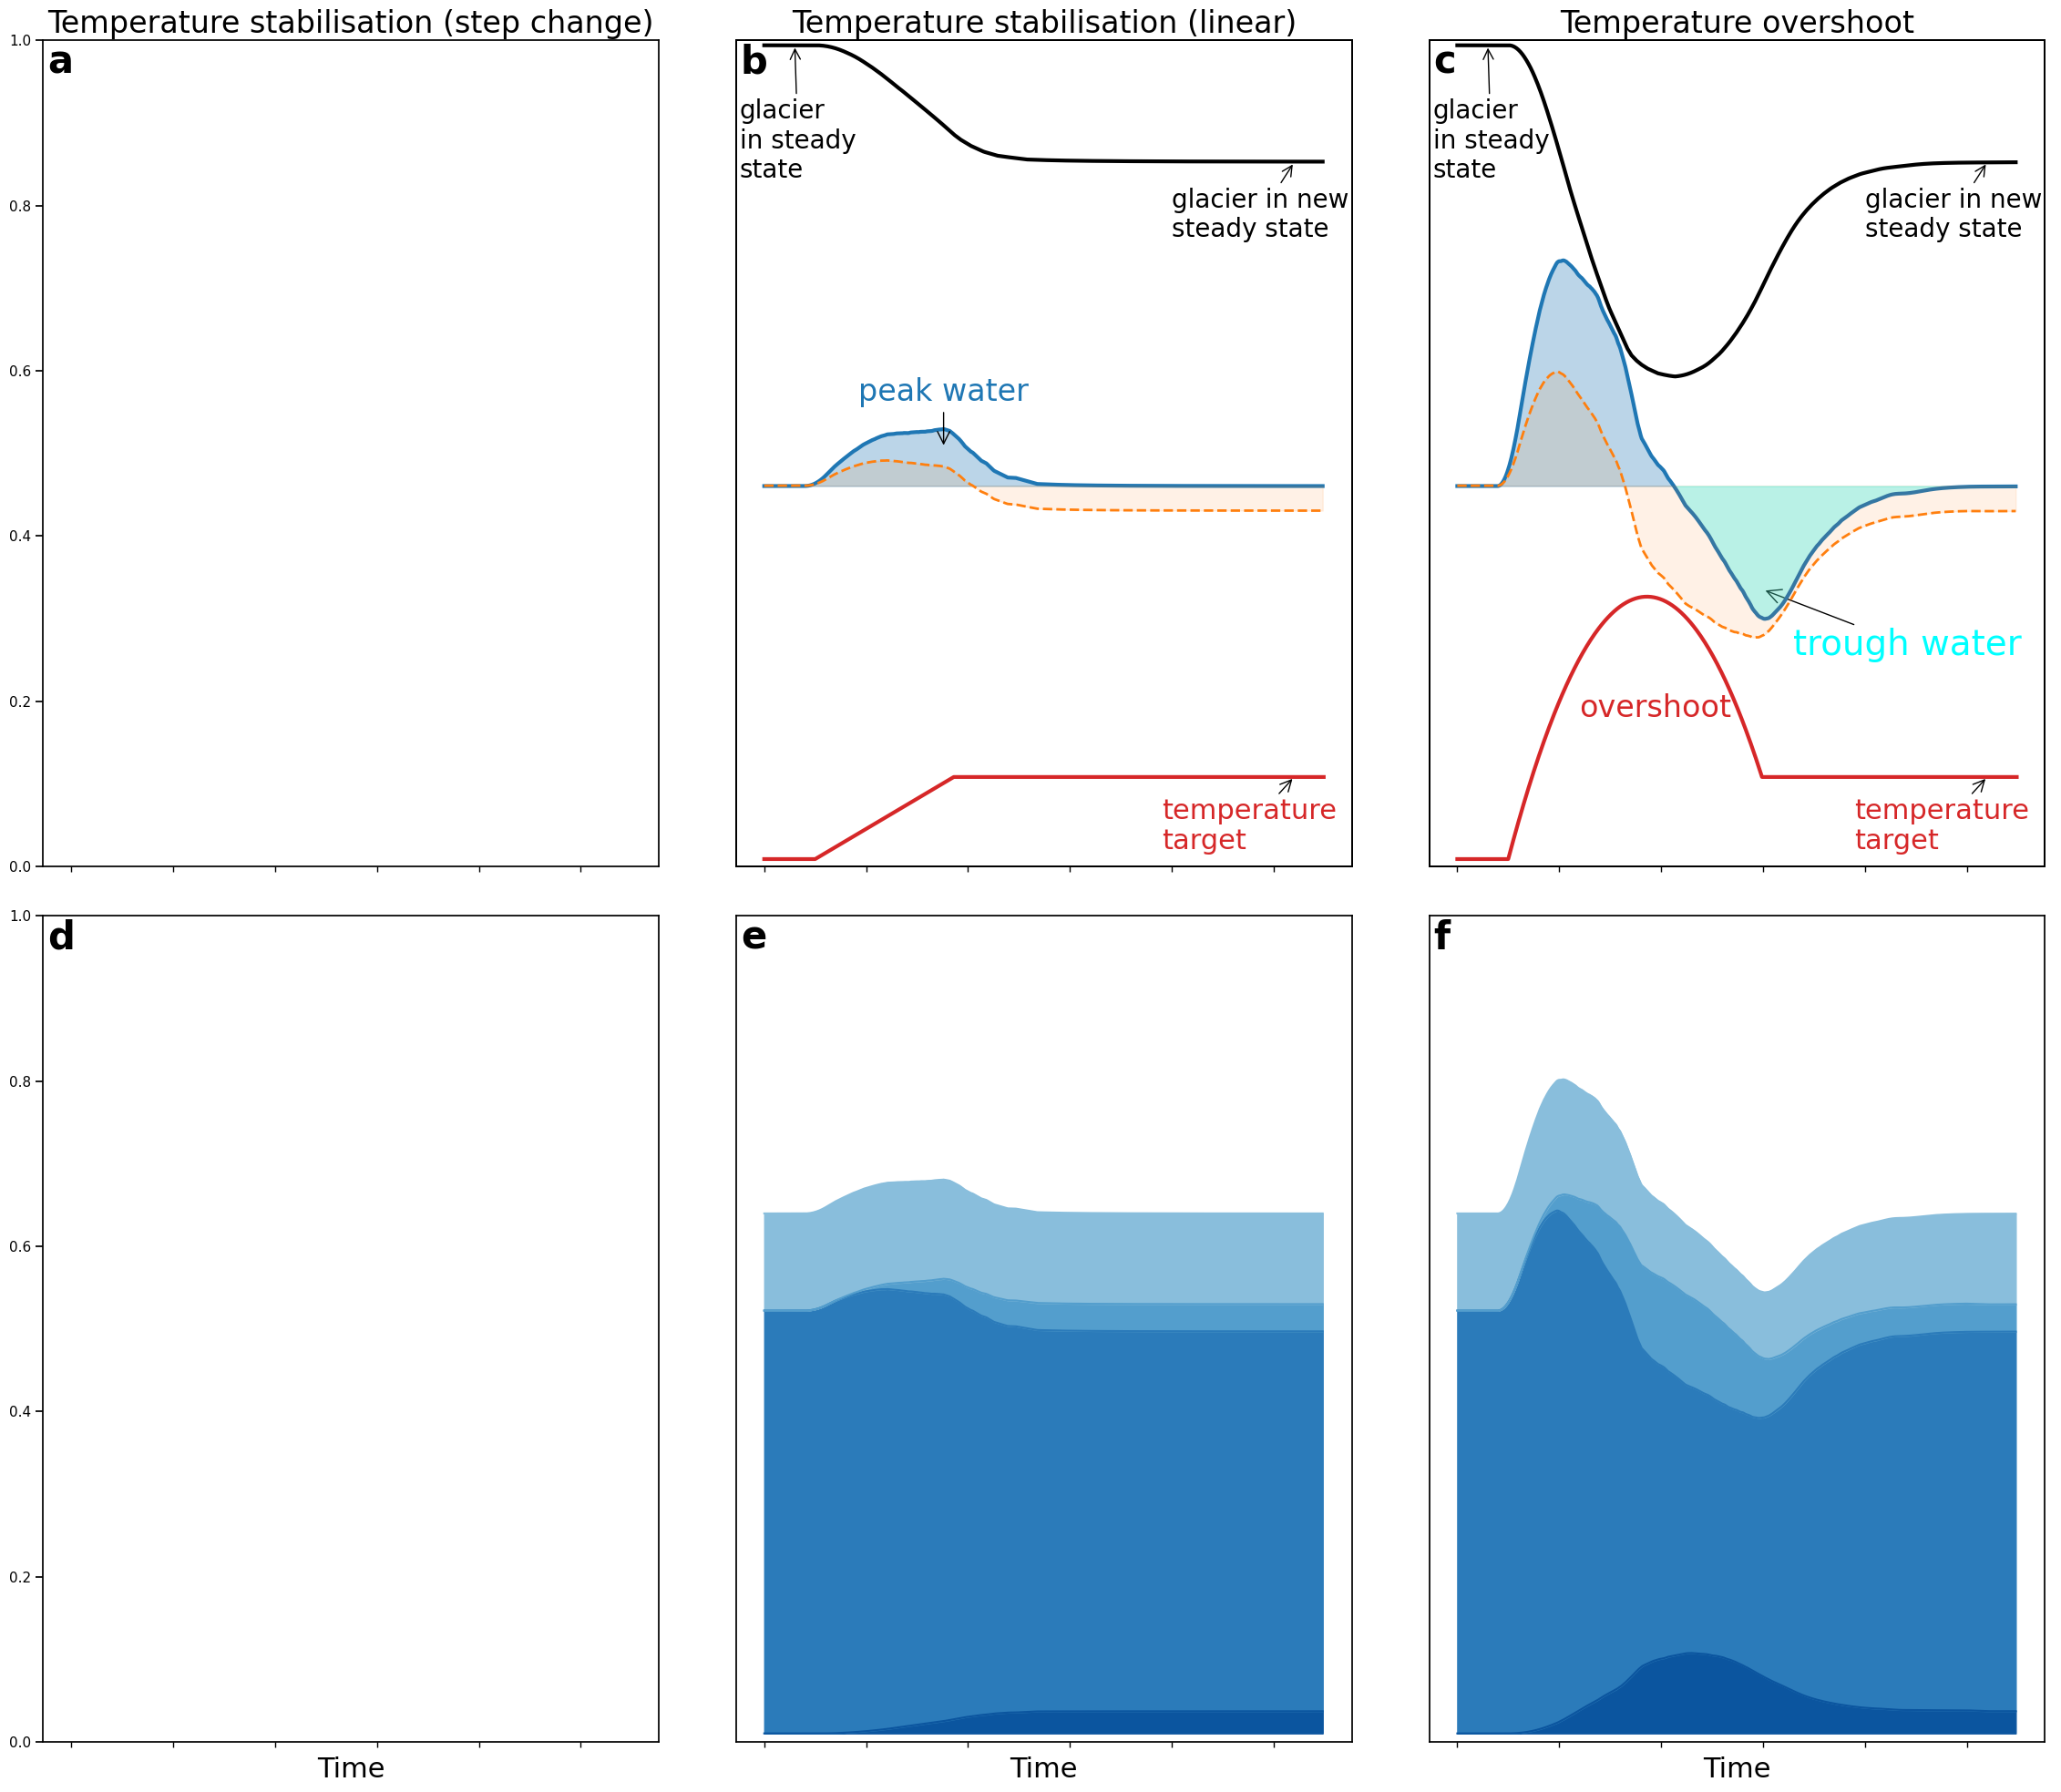

In [92]:
fac = 1.35
delta_runoff = -95.5# 60# -80
dry_season = True

eq1=(ds.volume_m3/1e9).isel(time=-1)
eq0=(ds.volume_m3/1e9).isel(time=0)

eq1_ind = 520
eq0_ind = 30

runoff_dry_sum_lim = [(df_runoff.sum(axis=1).min()/1.35 )+ delta_runoff-19, (df_runoff.sum(axis=1).max()*1.25) + delta_runoff-19]
runoff_lim = [df_runoff.sum(axis=1).min()/1.35-19, df_runoff.sum(axis=1).max()*1.25-19]
volume_lim = [#(ds.volume_m3/1e9).min()- ,   #/1.05,
              (ds.volume_m3/1e9).min() - 1*(ds.volume_m3/1e9).max(),
              (ds.volume_m3/1e9).max()*1.01]
temp_lim = [temp_bias_ts.values.min()*1.05, 
            temp_bias_ts.values.max()*6 #1.5
           ] #1.25

plt.rc('font', size=26)

#with plt.xkcd():
for only_upper_plots in [True,False]:

    if only_upper_plots:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23.5, 8*fac), sharex=True)
        add = '_only_upper_plots'
    else:
        fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(23.5, 15*fac), sharex=True)
        add = ''

    ###################
    # step change
    if do_step_change:
        if only_upper_plots:
            ax = axs[0]
        else:
            ax = axs[0][0]
        temp_bias_step.plot(ax=ax, c='C3', label = 'Temperature',ls='-', lw=3);
        ax2 = ax.twinx()

        (ds_step.volume_m3/1e9).plot(ax=ax2, c='black', label ='Glacier mass', lw=3);
        ax.set_ylabel('')
        #ds.length_m.plot(ax=axs[1]);

        ax3 = ax2.twinx()
        df_runoff_step.sum(axis=1).plot(ax=ax3, label =  'Glacier runoff\n(annual)', c='C0', lw=3);
        ax4 = ax3.twinx()
        if dry_season:
            df_runoff_sum_step.sum(axis=1).plot(ax=ax4, label = 'Glacier runoff\n(dry-melt season)',
                                                #\n(JJA for Aletsch glacier)',
                                                c='tab:orange', lw=2, ls='--');
        else:
            df_runoff_sum_step.sum(axis=1).plot(ax=ax4, label = 'Glacier runoff (melt season)', c='tab:orange', lw=2, ls='--');

        plt.ylabel(''); #plt.xlabel('Time'); #plt.title(f'Total annual runoff for {rgi_id}');
        #ax.set_title(f'{rgi_id}');
        ax2.set_ylabel('')
        ax.set_xticks([],[])
        ax.set_yticks([])
        ax2.set_yticks([])
        ax3.set_yticks([])
        ax4.set_yticks([])


        handles = []
        labels = []
        for axi in [ax2,ax3,ax4,ax]:
            handi, labeli = axi.get_legend_handles_labels()
            #if axi == ax3:
            #    handles.append(handi[0])
            #    handles.append(handi[1])
            #    labels.append(labeli[0])
            #    labels.append(labeli[1])
            #else:
            handles.append(handi[0])
            labels.append(labeli[0])

        plt.legend(handles, labels,fontsize=22, loc = 'upper right', bbox_to_anchor=(1.009,0.76))
        #ax.legend(loc='upper left', bbox_to_anchor=(0.65,1))
        #ax2.legend(loc='upper left', bbox_to_anchor=(0.65,0.95))
        #ax3.legend(loc='upper left', bbox_to_anchor=(0.65,0.9))
        #ax3.axhline(df_runoff.iloc[0].sum(), c='C0', ls=':', lw=3)
        if dry_season:
            ax4.fill_between(df_runoff_dry_step.index,
                         df_runoff_dry_step.iloc[0].sum(), df_runoff_dry_step.sum(axis=1).values,  alpha = 0.1, color='tab:orange')    
        else:
            ax4.fill_between(df_runoff_sum_step.index,
                             df_runoff_sum_step.iloc[0].sum(), df_runoff_sum_step.sum(axis=1).values,  alpha = 0.1, color='tab:orange')
        ax3.fill_between(df_runoff_step.index,
                         df_runoff_step.iloc[0].sum(), df_runoff_step.sum(axis=1).values, alpha = 0.3, color='C0')
        #ax3.fill_between(df_runoff_sum_step.index,
        #                 df_runoff_sum_step.iloc[0].sum(), df_runoff_sum_step.sum(axis=1).values, alpha = 0.1, color='C4')
        # this is the same for all
        ax4.set_ylim(runoff_dry_sum_lim)

        ax3.set_ylim(runoff_lim)
        ax2.set_ylim(volume_lim) 
        ax.set_ylim(temp_lim)

        ax3.annotate('peak water',(df_runoff_step.sum(axis=1).idxmax(),df_runoff_step.sum(axis=1).max()*0.97),
                    xytext=(df_runoff_step.sum(axis=1).idxmax()*1.05,df_runoff_step.sum(axis=1).max()*1.05),
                     color='C0',
                   arrowprops={'arrowstyle':'->'}, fontsize=24)



        ax2.annotate('glacier\nin steady\nstate',(eq0_ind,eq0), xytext=(-24,eq0*0.73), color='black',
                   arrowprops={'arrowstyle':'->'}, fontsize=20)

        ax2.annotate('glacier in new\nsteady state',(eq1_ind,eq1), xytext=(400,eq1*0.8), color='black',
                   arrowprops={'arrowstyle':'->'}, fontsize=20)

        ax.annotate('temperature\ntarget',(eq1_ind,temp_bias_ts.values[-1]), xytext=(390,temp_bias_ts.values[-1]*2.05), color='C3',
               arrowprops={'arrowstyle':'->'}, fontsize=22)

        ax.set_xlabel('Time', fontsize=24); 

        if only_upper_plots:
            pass
        else:
            ax = axs[1][0]
            df_runoff_step.plot.area(ax=ax, color=sns.color_palette('Blues_r')); 
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[::-1], labels[::-1],
                      title='Annual glacier runoff:\nsum of 4 components',
                      loc='upper right', fontsize=16,
                      title_fontsize=18, framealpha = 0.6)
            #ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]*1.12])
            ax.set_ylim([-5, df_runoff.sum(axis=1).max()*1.25])
            #plt.xlabel('Years'); 
            #plt.ylabel('Runoff (Mt)');
            ax.set_ylabel('');
            ax.set_xlabel('Time', fontsize=22);
            #ax.set_xticks([])
            ax.set_yticks([]);
            ax.set_xticks([],[])

    ###################
    # linear temp change
    if only_upper_plots:
        ax = axs[1]
    else:
        ax = axs[0][1]
    temp_bias_ts_lin.plot(ax=ax, c='C3', label = 'Temperature',ls='-', lw=3);
    ax2 = ax.twinx()

    (ds_lin.volume_m3/1e9).plot(ax=ax2, c='black', label ='Mass', lw=3);
    ax.set_ylabel('')
    #ds.length_m.plot(ax=axs[1]);

    ax3 = ax2.twinx()
    df_runoff_lin.sum(axis=1).plot(ax=ax3, label = 'Annual glacier runoff', c='C0', lw=3);
    
    ax4 = ax3.twinx()
    if dry_season:
        df_runoff_dry_lin.sum(axis=1).plot(ax=ax4, label = 'Dry-season glacier runoff', #\n(JJA for Aletsch glacier)',
                                       c='tab:orange', lw=2, ls='--');
    else:
        df_runoff_sum_lin.sum(axis=1).plot(ax=ax4, label = 'Melt-season glacier runoff',
                                       c='tab:orange', lw=2, ls='--');

    plt.ylabel(''); #plt.xlabel('Time'); #plt.title(f'Total annual runoff for {rgi_id}');
    #ax.set_title(f'{rgi_id}');
    ax2.set_ylabel('')
    ax.set_xticks([],[])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax4.set_yticks([])
    
    #handles = []
    #labels = []
    #for axi in [ax,ax2,ax3]:
    #    handi, labeli = axi.get_legend_handles_labels()
    #    handles.append(handi[0])
    #    labels.append(labeli[0])

    #plt.legend(handles, labels,fontsize=18)
    #ax.legend(loc='upper left', bbox_to_anchor=(0.65,1))
    #ax2.legend(loc='upper left', bbox_to_anchor=(0.65,0.95))
    #ax3.legend(loc='upper left', bbox_to_anchor=(0.65,0.9))
    #ax3.axhline(df_runoff.iloc[0].sum(), c='C0', ls=':', lw=3)
    if dry_season:
        ax4.fill_between(df_runoff_dry_lin.index,
                     df_runoff_dry_lin.iloc[0].sum(), df_runoff_dry_lin.sum(axis=1).values,  alpha = 0.1, color='tab:orange')
    else:
        ax4.fill_between(df_runoff_sum_lin.index,
                         df_runoff_sum_lin.iloc[0].sum(), df_runoff_sum_lin.sum(axis=1).values,  alpha = 0.1, color='tab:orange')
    ax3.fill_between(df_runoff_lin.index,
                     df_runoff_lin.iloc[0].sum(), df_runoff_lin.sum(axis=1).values, alpha = 0.3, color='C0')

    ax4.set_ylim(runoff_dry_sum_lim)
    ax3.set_ylim(runoff_lim)
    ax2.set_ylim(volume_lim) 
    ax.set_ylim(temp_lim)

    #ax.annotate('peak water',(220,-0.09), xytext=(140,0.15), color='C0',
    #           arrowprops={'arrowstyle':'->'}, fontsize=22)
    ax3.annotate('peak water',(df_runoff_lin.sum(axis=1).idxmax(),df_runoff_lin.sum(axis=1).max()*0.98),
                    xytext=(df_runoff_lin.sum(axis=1).idxmax(),df_runoff_lin.sum(axis=1).max()*1.03),
                     color='C0', ha='center',
                   arrowprops={'arrowstyle':'->'}, fontsize=24)
    
    
    ax2.annotate('glacier\nin steady\nstate',(eq0_ind,eq0), xytext=(-24,eq0*0.73), color='black',
               arrowprops={'arrowstyle':'->'}, fontsize=20)

    ax2.annotate('glacier in new\nsteady state',(eq1_ind,eq1), xytext=(400,eq1*0.8), color='black',
               arrowprops={'arrowstyle':'->'}, fontsize=20)

    ax.annotate('temperature\ntarget',(eq1_ind,temp_bias_ts.values[-1]), xytext=(390,temp_bias_ts.values[-1]*2.05), color='C3',
           arrowprops={'arrowstyle':'->'}, fontsize=22)

    ax.set_xlabel('Time', fontsize=24); 

    if not only_upper_plots:
        ax = axs[1][1]
        df_runoff_lin.plot.area(ax=ax, color=sns.color_palette('Blues_r'), legend=False); 
        #handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles[::-1], labels[::-1], title='Annual glacier runoff: sum of 4 components', loc='upper right', fontsize=16,
        #         title_fontsize=18, framealpha = 0.6)
        #ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]*1.12])
        ax.set_ylim([-5, df_runoff.sum(axis=1).max()*1.25])
        #plt.xlabel('Years'); 
        #plt.ylabel('Runoff (Mt)');
        ax.set_ylabel('');
        ax.set_xlabel('Time', fontsize=22);
        #ax.set_xticks([])
        ax.set_yticks([]);
        ax.set_xticks([],[])



    ####################
    if only_upper_plots:
        ax = axs[2]
    else:
        ax = axs[0][2]
    temp_bias_ts.plot(ax=ax, c='C3', label = 'Temperature',ls='-', lw=3);
    ax2 = ax.twinx()

    (ds.volume_m3/1e9).plot(ax=ax2, c='black', label ='Mass', lw=3);
    ax.set_ylabel('')
    #ds.length_m.plot(ax=axs[1]);

    ax3 = ax2.twinx()
    df_runoff.sum(axis=1).plot(ax=ax3, label = 'Annual glacier runoff', c='C0', lw=3);
    ax4 = ax3.twinx()

    df_runoff_sum.sum(axis=1).plot(ax=ax4, label = 'Melt-season glacier runoff',
                                       c='tab:orange', lw=2, ls='--');
    
    plt.ylabel(''); #plt.xlabel('Time'); #plt.title(f'Total annual runoff for {rgi_id}');
    #ax.set_title(f'{rgi_id}');
    ax2.set_ylabel('')
    ax.set_xticks([],[])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax4.set_yticks([])

    handles = []
    labels = []
    for axi in [ax,ax2,ax3]:
        handi, labeli = axi.get_legend_handles_labels()
        handles.append(handi[0])
        labels.append(labeli[0])

    leg=plt.legend(handles, labels,fontsize=20)
    leg.remove()
    #ax.legend(loc='upper left', bbox_to_anchor=(0.65,1))
    #ax2.legend(loc='upper left', bbox_to_anchor=(0.65,0.95))
    #ax3.legend(loc='upper left', bbox_to_anchor=(0.65,0.9))
    #ax3.axhline(df_runoff.iloc[0].sum(), c='C0', ls=':', lw=3)
    ax4.fill_between(df_runoff_sum.index,
                     df_runoff_sum.iloc[0].sum(), df_runoff_sum.sum(axis=1).values, alpha = 0.1, color='tab:orange')

    ##########NEW 
    diff = df_runoff.sum(axis=1) - df_runoff.sum(axis=1).iloc[0]
    ax3.fill_between(df_runoff.index,
                     df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).where(diff<0).values, alpha=0.3, color='cyan')
    ax3.fill_between(df_runoff.index,
                     df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).where(diff>=0).values, alpha=0.3, color='C0')
    
    #ax.fill_between(df_runoff.index, np.repeat(0,549), diff.where(diff <-5), alpha=0.1, color='cyan')
    #ax3.set_ylim([ax3.get_ylim()[0], ax3.get_ylim()[1]*1.025])
    #ax2.set_ylim([ax2.get_ylim()[0], ax2.get_ylim()[1]*1.03])
    #ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]*1.03])


    #ax.annotate('peak water',(140,1.23), xytext=(68,1.7), color='C0',
    #           arrowprops={'arrowstyle':'->'}, fontsize=20)

    ax.annotate('trough water',(300,0.5+0.4), xytext=(330,0.4), color='cyan',
               arrowprops={'arrowstyle':'->'}, fontsize=28)


    ax2.annotate('glacier\nin steady\nstate',(eq0_ind,eq0), xytext=(-24,eq0*0.73), color='black',
               arrowprops={'arrowstyle':'->'}, fontsize=20)

    ax2.annotate('glacier in new\nsteady state',(eq1_ind,eq1), xytext=(400,eq1*0.8), color='black',
               arrowprops={'arrowstyle':'->'}, fontsize=20)

    ax.annotate('temperature\ntarget',(eq1_ind,temp_bias_ts.values[-1]), xytext=(390,temp_bias_ts.values[-1]*2.05), color='C3',
           arrowprops={'arrowstyle':'->'}, fontsize=22)

    ax.annotate('overshoot',(173, temp_bias_ts.values.max()*0.9), xytext=(120,temp_bias_ts.values.max()*0.0), 
                color='C3', arrowprops={'arrowstyle':'->', 'alpha':0}, fontsize=24, va='center')
    ax.set_xlabel('Time', fontsize=24); 

    ax4.set_ylim(runoff_dry_sum_lim)
    ax3.set_ylim(runoff_lim)
    ax2.set_ylim(volume_lim) # max ds_lin???
    ax.set_ylim(temp_lim)

    
    if not only_upper_plots:
        ax = axs[1][2]
        df_runoff.plot.area(ax=ax, color=sns.color_palette('Blues_r'), legend=False); 
        #handles, labels = ax.get_legend_handles_labels()
        #ax.legend(handles[::-1], labels[::-1], title='Annual glacier runoff:\nsum of 4 components', loc='upper right', fontsize=16,
        #         title_fontsize=18, framealpha = 0.6)
        ax.set_ylim([-5, df_runoff.sum(axis=1).max()*1.25])

        #plt.xlabel('Years'); 
        #plt.ylabel('Runoff (Mt)');
        ax.set_ylabel('');
        #ax.set_xticks([])
        ax.set_yticks([]);
        ax.set_xticks([],[])

    #num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 
    #num_text_x = 0.007
    if only_upper_plots:
        axss = axs
    else:
        axss = [axs[0][0],axs[0][1], axs[0][2], 
                axs[1][0], axs[1][1],axs[1][2]]
    for j,axi in enumerate(axss):
        num_text_y = 1.01
        #axi.text(num_text_x, num_text_y,
        #         num_dict[j], fontsize=24, transform=axi.transAxes)
        if j ==1:
            axi.set_title('Temperature stabilisation (linear)', fontsize=24)
        elif j ==0:
            axi.set_title('Temperature stabilisation (step change)', fontsize=24)
        elif j==2:
            axi.set_title('Temperature overshoot', fontsize=24)
        axi.set_xlabel('Time', fontsize=22)

    plt.tight_layout();
    #ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')

    num_text_x = 0.007
    num_text_y = 0.96
    for j,axi in enumerate(axss):
        #print(axi)
        axi.text(num_text_x, num_text_y,
                num_dict[j], fontsize=30, transform=axi.transAxes, fontweight='bold')
        ax.set_xticks([],[])


    #if dry_season:
    #    plt.savefig(f'conceptual_model_1_no_xkcd_w_dry_season{add}{roll_info}_v2024-06_v1.png')
    #    plt.savefig(f'conceptual_model_1_no_xkcd_w_dry_season{add}{roll_info}_v2024-06_v1.pdf')
    #    plt.savefig(f'conceptual_model_1_no_xkcd_w_dry_season{add}{roll_info}_v2024-06_v1.svg')

    #else:
    #    plt.savefig(f'conceptual_model_1_no_xkcd{add}{roll_info}_v2024-06.png')
    #    plt.savefig(f'conceptual_model_1_no_xkcd{add}{roll_info}_v2024-06.pdf')

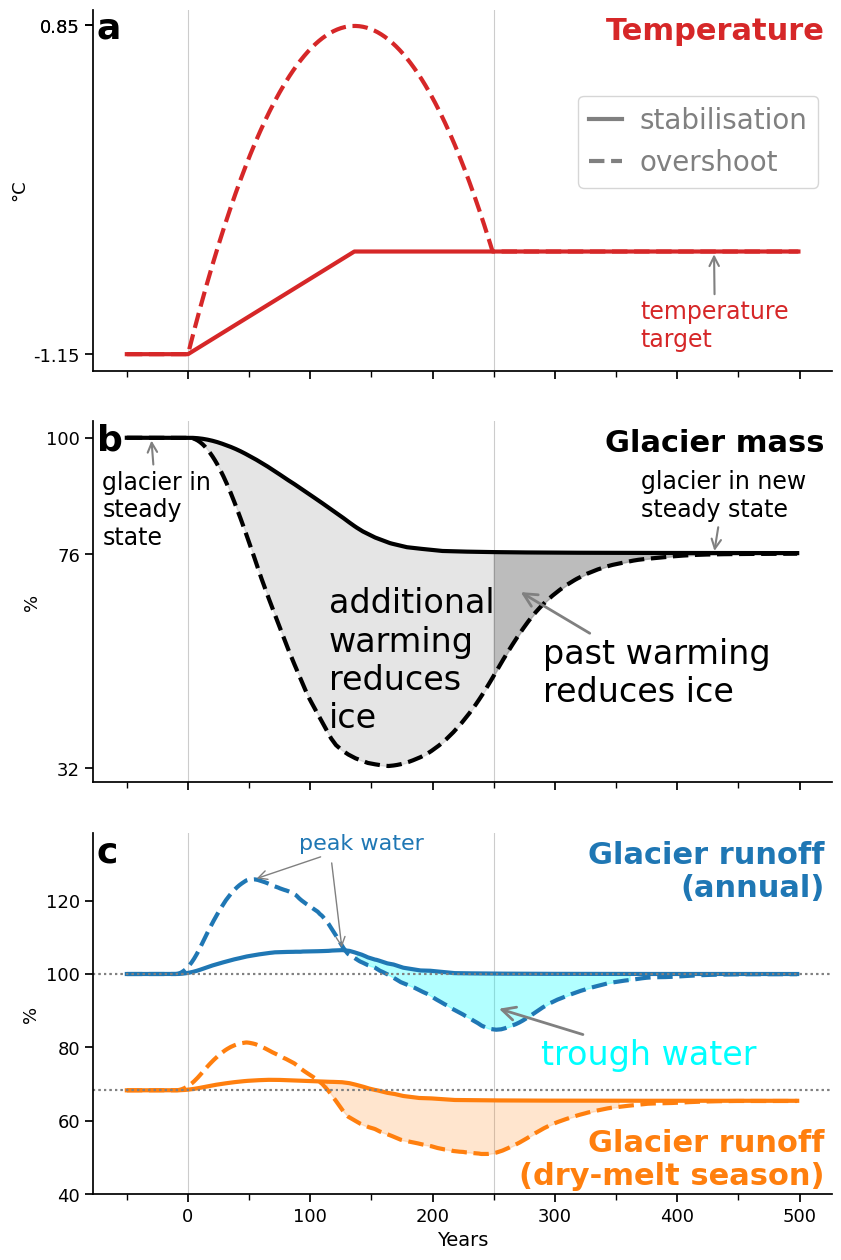

In [73]:
with_step_ch = False
plt.rc('font', size=26)
fig, axs = plt.subplots(nrows=3, figsize=(9, 13), sharex=True)

#ds.length_m.plot(ax=axs[1]);
if with_step_ch:
    temp_bias_step.plot(ax=axs[0], c='C3', ls=':', lw=3, label='step change');
temp_bias_ts_lin.plot(ax=axs[0], c='C3', ls='-', lw=3, label='stabilisation');
temp_bias_ts.plot(ax=axs[0], c='C3', label='overshoot', lw=3, ls='--');
axs[0].text(0.99, 0.98, 'Temperature', weight='bold',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=22, color='C3')
leg = axs[0].legend(fontsize=20, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6,
                    loc = 'upper right', bbox_to_anchor=(1,0.8), ncol=1)
axs[0].set_xlabel(''); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')

for j in np.arange(0,len(leg.get_lines()),1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')
    

axs[0].annotate('temperature\ntarget',(480,temp_bias_ts.iloc[-1]), xytext=(420,temp_bias_ts.iloc[-1]*2.1),
                color='C3',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

###
init_vol = ds_lin.volume_m3.isel(time=0)
axs[1].text(0.99, 0.98, 'Glacier mass',
         ha='right', va='top', transform=axs[1].transAxes, 
        fontsize=22, color='black', weight='bold')
if with_step_ch:
    (100*ds_step.volume_m3/init_vol).plot(ax=axs[1], c='black', ls=':');

(100*ds_lin.volume_m3/init_vol).plot(ax=axs[1], c='black', ls ='-' , lw=3);
(100*ds.volume_m3/init_vol).plot(ax=axs[1], c='black', ls='--', lw=3);
axs[1].set_ylabel('')
#axs[1].set_title('Glacier mass', fontsize=22)
eq0 = (100*ds.volume_m3/init_vol).isel(time=0)
eq1 = (100*ds.volume_m3/init_vol).isel(time=-1)
axs[1].annotate('glacier in\nsteady\nstate',(20,eq0), xytext=(-20,eq0*0.78), color='black',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

axs[1].annotate('glacier in new\nsteady state',(480,eq1), xytext=(420,eq1*1.1), color='black',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1.5}, fontsize=17)

t = 0 #np.abs((temp_bias_ts-temp_bias_ts_lin.max())).iloc[:200].idxmin()
axs[1].fill_between(ds_lin.time.sel(time=slice(t,ds_lin.time.values[-1])), (100*ds.sel(time=slice(t,ds.time.values[-1])).volume_m3/init_vol),
                     (100*ds_lin.sel(time=slice(t,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.2, color='grey')
axs[1].annotate( 'additional\nwarming\nreduces\nice', (165,eq1*0.53),color='black',
                   fontsize=24)

axs[1].fill_between(ds_lin.time.sel(time=slice(300,ds_lin.time.values[-1])), (100*ds.sel(time=slice(300,ds.time.values[-1])).volume_m3/init_vol),
                     (100*ds_lin.sel(time=slice(300,ds_lin.time.values[-1])).volume_m3/init_vol), alpha=0.4, color='grey')

axs[1].annotate('past warming\nreduces ice', (320,eq1*0.9), xytext=(340,eq1*0.6), color='black',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=24) 
### temporarily irreversible 
axs[2].text(0.99, 0.98, 'Glacier runoff\n(annual)',
         ha='right', va='top', transform=axs[2].transAxes, 
        fontsize=22, color='C0', weight='bold')
init_runoff = df_runoff.sum(axis=1).iloc[0]
if with_step_ch:
    (100*df_runoff_step.sum(axis=1)/init_runoff).plot(ax=axs[2], label = 'Annual runoff', c='C0', ls=':');
(100*df_runoff_lin.sum(axis=1)/init_runoff).plot(ax=axs[2], label = 'Annual runoff', c='C0', ls='-', lw=3);
(100*df_runoff.sum(axis=1)/init_runoff).plot(ax=axs[2], label = 'Annual runoff', c='C0', ls='--', lw=3);

axs[2].axhline((100*df_runoff.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
axs[2].axhline((100*df_runoff_lin.sum(axis=1).iloc[0]/init_runoff), color='grey', ls=':')
#plt.ylabel('Runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');

#axs[2].fill_between(df_runoff.index,
#                 df_runoff.iloc[0].sum(), df_runoff.sum(axis=1).values, alpha = 0.3, color='C0')

diff = (-df_runoff_lin.sum(axis=1)+df_runoff.sum(axis=1))
axs[2].fill_between(df_runoff_lin.index, (100*df_runoff_lin.sum(axis=1).where(diff<-5)/init_runoff),
                                        (100*df_runoff.sum(axis=1).where(diff <-5)/init_runoff), alpha=0.3, color='cyan')


pw = (100*df_runoff.sum(axis=1).max()/init_runoff)
tw = (100*df_runoff.sum(axis=1).min()/init_runoff)
axs[2].set_ylim([(100*df_runoff_sum.sum(axis=1).min()*0.95/init_runoff),pw*1.1])
pw_ind = df_runoff.sum(axis=1).idxmax()
axs[2].annotate('peak water',(pw_ind,pw), xytext=(pw_ind*1.35,pw*1.1),
                xycoords='data', textcoords='data', va ='top',
                color='C0',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
pw_lin = (100*df_runoff_lin.sum(axis=1).max()/init_runoff)
pw_ind_lin =  df_runoff_lin.sum(axis=1).idxmax()
axs[2].annotate('',(pw_ind_lin,pw_lin), xytext=(pw_ind_lin*0.95,pw_lin*1.23),
                xycoords='data', textcoords='data',
                color='C0',
           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 1}, fontsize=16)
tw_ind = df_runoff.sum(axis=1).idxmin()

axs[2].annotate('trough water',(tw_ind,tw*1.07), xytext=(tw_ind*1.12,tw*0.92),
             xycoords='data', textcoords='data', color='cyan',
                va='center',ha='left',
           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=24)

#plt.legend()
m = 2
axs[m].text(0.99, 0.01, 'Glacier runoff\n(dry-melt season)', # here for Aletsch glacier (i.e., driest months of entire RHONE basin)
         ha='right', va='bottom', transform=axs[m].transAxes, 
        fontsize=22, color='tab:orange', weight='bold')
if with_step_ch:
    (100*df_runoff_dry_step/init_runoff).sum(axis=1).plot(ax=axs[m], c='tab:orange', ls=':');
(100*df_runoff_dry_lin.sum(axis=1)/init_runoff).plot(ax=axs[m],  c='tab:orange', ls='-',lw=3);
(100*df_runoff_dry.sum(axis=1)/init_runoff).plot(ax=axs[m], c='tab:orange', ls='--', lw=3);
axs[m].axhline((100*df_runoff_dry.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')
axs[m].axhline((100*df_runoff_dry_lin.sum(axis=1)/init_runoff).iloc[0], color='grey', ls=':')

#tw_ind_dry = df_runoff_dry.sum(axis=1).idxmin()
#axs[m].annotate('',(tw_ind_dry,tw_ind_dry*1.01), xytext=(tw_ind_dry*1.2,tw_ind_dry*1.3),
#             xycoords='data', textcoords='data', color='cyan',
#                va='bottom',ha='left',
#           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=20)

#axs[m].fill_between(df_runoff_dry.sum(axis=1).index,
#                    df_runoff_dry.sum(axis=1).iloc[0],
#                    df_runoff_dry.sum(axis=1).values, alpha = 0.3, color='tab:orange')

diff = (-df_runoff_dry_lin.sum(axis=1)+df_runoff_dry.sum(axis=1))
axs[2].fill_between(df_runoff_dry_lin.index, (100*df_runoff_dry_lin.sum(axis=1).where(diff<-5)/init_runoff),
                                              (100*df_runoff_dry.sum(axis=1).where(diff <-5)/init_runoff), alpha=0.2, color='tab:orange') #, label='')


#leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
#leg.get_title().set_color('C4')

axs[m].set_ylim([axs[m].get_ylim()[0]*0.85, axs[m].get_ylim()[1]])
#plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
#plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
#         c='cyan', ls='-.',lw=0.4)
#ax.set_xticks([])
num_text_x = 0.005
num_text_y = 0.92
fs_ticks=13
axs[0].set_yticks([np.round(temp_bias_ts.min(),2), np.round(temp_bias_ts.max(),2),  np.round(temp_bias_ts.max(),2)],
                  [np.round(temp_bias_ts.min(),2), np.round(temp_bias_ts.max(),2), np.round(temp_bias_ts.max(),2)], fontsize=fs_ticks)
axs[0].set_ylabel('°C', fontsize=fs_ticks)
axs[1].set_yticks([int((100*ds.volume_m3/init_vol).min().round(0).values), int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100],
                  [int((100*ds.volume_m3/init_vol).min().round(0).values), int((100*ds_lin.volume_m3/init_vol).min().round(0).values), 100], fontsize=fs_ticks)
axs[1].set_ylabel('%', fontsize=fs_ticks)
axs[2].set_ylabel('%', fontsize=fs_ticks)
axs[2].set_yticks([40,60,80,100,120],[40,60,80,100,120], fontsize=fs_ticks)
# reset the time axis to start at zero when the temp. changes are applied
for j,ax in enumerate(axs):
    #ax.set_yticks([]);
    ax.set_xticks([],[])
    ax.text(num_text_x, num_text_y,
            num_dict[j], fontsize=26, transform=ax.transAxes, weight='bold')
    ax.axvline(300, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.8, alpha =0.4, color='grey', zorder=0)
    ax.spines[['right', 'top']].set_visible(False)
    #ax.set_xlim([0-20,550+50+5])
plt.tight_layout();
axs[2].set_xticks([50,150,250,350,450,550], [0,100,200,300,400,500], fontsize=fs_ticks)
axs[2].set_xlabel('Years', fontsize=fs_ticks+1); #axs[0].set_ylabel('Temperature bias (°C)');
#plt.savefig('overshoot_conceptual_model_variant_june_2024.pdf')
#plt.savefig('overshoot_conceptual_model_variant_june_2024.png')

# OLD

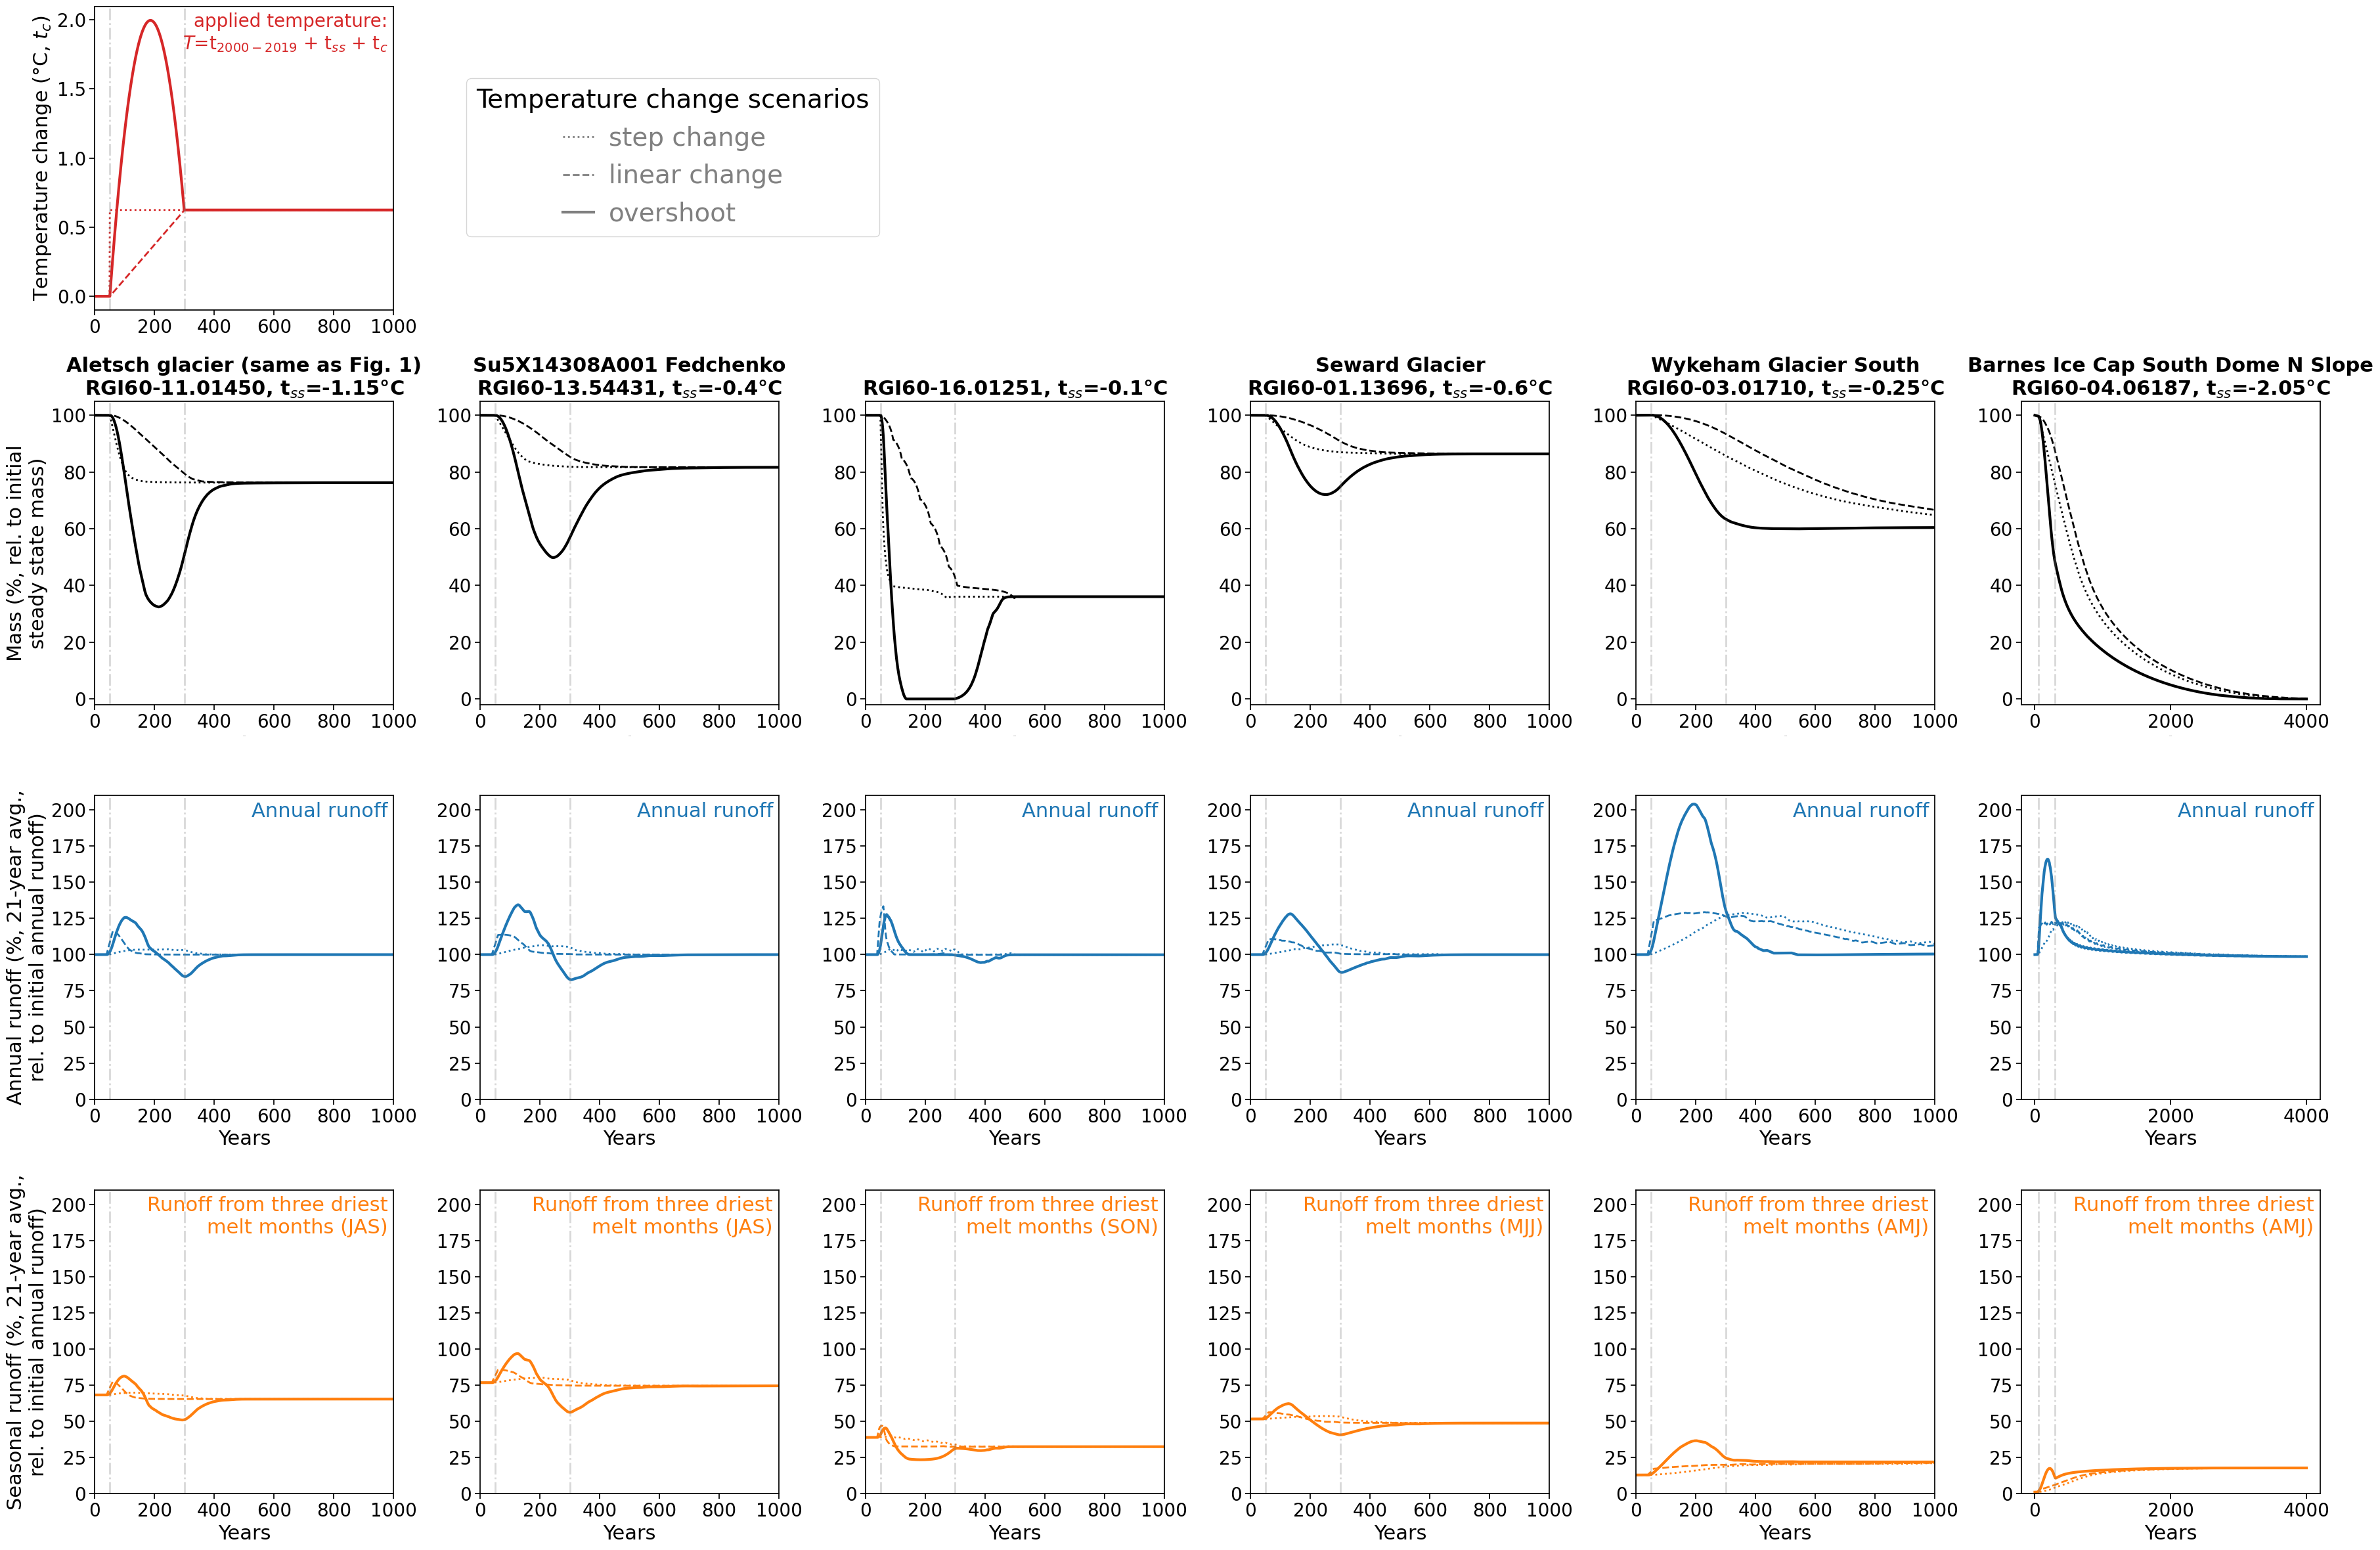

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(36, 24)) #sharex
plt.rc('font', size=20)

axs = axs.flatten()
#ds.length_m.plot(ax=axs[1]);
delta_t = dict_delta_t_rgi_eq[gdirs[-1].rgi_id]

(temp_bias_step-delta_t).plot(ax=axs[0], c='C3', ls=':', label='step change',lw=2);
(temp_bias_ts_lin-delta_t).plot(ax=axs[0], c='C3', ls='--', label='linear change',lw=2);
(temp_bias_ts-delta_t).plot(ax=axs[0], c='C3', label='overshoot', lw=3);
axs[0].text(0.98, 0.98, 'applied temperature:\n'+r'$T$=t$_{2000-2019}$ + t$_{ss}$ + t$_c$',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=20, color='C3')

axs[0].set_ylabel(r'Temperature change (°C, $t_c$)', fontsize=22); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')


    

#axs[0].annotate('temperature\ntarget',(480,temp_bias_step.iloc[-1]), xytext=(420,temp_bias_step.iloc[-1]*2.1),
#                color='C3',
#           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

fig.delaxes(axs[1])
fig.delaxes(axs[2])
fig.delaxes(axs[3])
fig.delaxes(axs[4])
fig.delaxes(axs[5])


###
n1 = 6
for j,gdir in enumerate(gdirs):
    _r = gdir.rgi_id
    ds = ds_d[_r]
    ds_lin = ds_lin_d[_r]
    ds_step = ds_step_d[_r]
    #axs[3+j].text(0.98, 0.98, 'Volume',
    #         ha='right', va='top', transform=axs[2+j].transAxes, 
    #        fontsize=22, color='black')
    (100*ds_step.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[6+j], c='black', ls=':',lw=2);
    (100*ds_lin.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[6+j], c='black', ls ='--',lw=2 );
    (100*ds.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[6+j], c='black', ls='-', lw=3);
    if j==0:
        axs[6+j].set_ylabel('Mass (%, rel. to initial\nsteady state mass)', fontsize=22)
    else:
        axs[6+j].set_ylabel('')
    
    #axs[1].set_title('Glacier volume', fontsize=22)
    eq0 = (ds.volume_m3/1e9).isel(time=0)
    eq1 = (ds.volume_m3/1e9).isel(time=-1)
    #axs[2+j].annotate('glacier in\nsteady-state',(20,eq0), xytext=(-20,eq0*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

    #axs[2+j].annotate('glacier in new\nsteady-state',(480,eq1), xytext=(420,eq1*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    #if j == 0:
    #    ylims = axs[4+j].get_ylim()
    #else:
    axs[6+j].set_ylim([-2,105])
        
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    if '1450' in gdir.rgi_id:
        axs[6+j].set_title(f'Aletsch glacier (same as Fig. 1)\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=22)
    else:
        axs[6+j].set_title(f'{gdir.name}\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=22)
    axs[6+j].set_xlabel('Years', fontsize=0);         

###
n2 = 12
for j,gdir in enumerate(gdirs):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d[_r]
    df_runoff_lin = df_lin_runoff_d[_r]
    df_runoff_step = df_step_runoff_d[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff.sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_runoff_lin.sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_runoff_step.sum(axis=1).iloc[0]

    axs[n2+j].text(0.98, 0.98, 'Annual runoff',
             ha='right', va='top', transform=axs[n2+j].transAxes, 
            fontsize=22, color='C0')
    df_runoff_sum_rel_step.plot(ax=axs[n2+j], label = 'Annual runoff', c='C0', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[n2+j], label = 'Annual runoff', c='C0', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[n2+j], label = 'Annual runoff', c='C0', ls='-', lw=3);
    if j == 0:
        axs[n2+j].set_ylabel(f'Annual runoff (%, {roll}-year avg.,\nrel. to initial annual runoff)', fontsize=22)
    else:
        axs[n2+j].set_ylabel('')
    axs[n2+j].set_xlabel('Years', fontsize=22); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[n2+j].set_ylim([70,210])
    #axs[8+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='C0')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[4+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()

    #axs[4+j].annotate('trough water?',(tw_ind,tw*1.04), xytext=(tw_ind*1.2,tw*0.92),
    #             xycoords='data', textcoords='data', color='C0',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=18)
    
n3 = 18   
for j,gdir in enumerate(gdirs):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d_dry[_r]
    df_runoff_lin = df_lin_runoff_d_dry[_r]
    df_runoff_step = df_step_runoff_d_dry[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_lin_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_step_runoff_d[_r].sum(axis=1).iloc[0]
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    if m_last == 9:
        ms = 'JAS'
    elif m_last == 6:
        ms = 'AMJ'
    elif m_last == 11:
        ms = 'SON'
    elif m_last == 7:
        ms = 'MJJ'
    else:
        print ('sth. wrong')
    axs[n3+j].text(0.98, 0.98, f'Runoff from three driest\nmelt months ({ms})',
             ha='right', va='top', transform=axs[n3+j].transAxes, 
            fontsize=22, color='tab:orange')
    df_runoff_sum_rel_step.plot(ax=axs[n3+j], label = 'Seasonal runoff', c='tab:orange', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[n3+j], label = 'Seasonal runoff', c='tab:orange', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[n3+j], label = 'Seasonal runoff', c='tab:orange', ls='-', lw=3);
    if j == 0:
        axs[n3+j].set_ylabel(f'Seasonal runoff (%, {roll}-year avg.,\nrel. to initial annual runoff)', fontsize=22)
    else:
        axs[n3+j].set_ylabel('')
    axs[n3+j].set_xlabel('Years', fontsize=22); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[n3+j].set_ylim([70,210])
    #axs[12+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='tab:orange')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()
    
for j,ax in enumerate(axs):
    yt = ax.get_yticks()
    xt = ax.get_xticks()
    ax.set_xticks(xt.astype(int)[1::2],xt.astype(int)[1::2] , fontsize=20)
    if j<n1:
        ax.set_yticks(yt[1::2],yt.round(1)[1::2], fontsize=20)
    elif j<n2:
        ax.set_yticks(np.arange(0,120,20), np.arange(0,120,20), fontsize=20)
    else:
        ax.set_yticks(np.arange(0,220,25), np.arange(0,220,25), fontsize=20)
    
    if j not in [n1+n1-1,n1+n1+n1-1,n1+n1+n1+n1-1]:
        ax.set_xlim([0,1000])
        ax.set_xticks(np.arange(0,1001,200),np.arange(0,1001,200) , fontsize=20)

    ax.axvline(300,color='grey',ls='-.', lw=2, alpha = 0.3)
    ax.axvline(50,color='grey',ls='-.', lw=2, alpha = 0.3)
    
plt.tight_layout()

leg = axs[0].legend(fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6, title='Temperature change scenarios', title_fontsize=28, 
                    #title_fontproperties = {'textcolor':'grey', 'fontsize':28},
                    loc = 'lower left', bbox_to_anchor=(1.2,0.2), ncol=1)

for j in np.arange(0,3,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')

plt.savefig('figures/suppl_fig_idealised_1000.png')

### Same plot just with selected glaciers ... (not used in manuscript)... Basically old!

In [ ]:
gdirs_sel = [gdirs[0], 
            gdirs[2],
             gdirs[3],
             gdirs[4]]

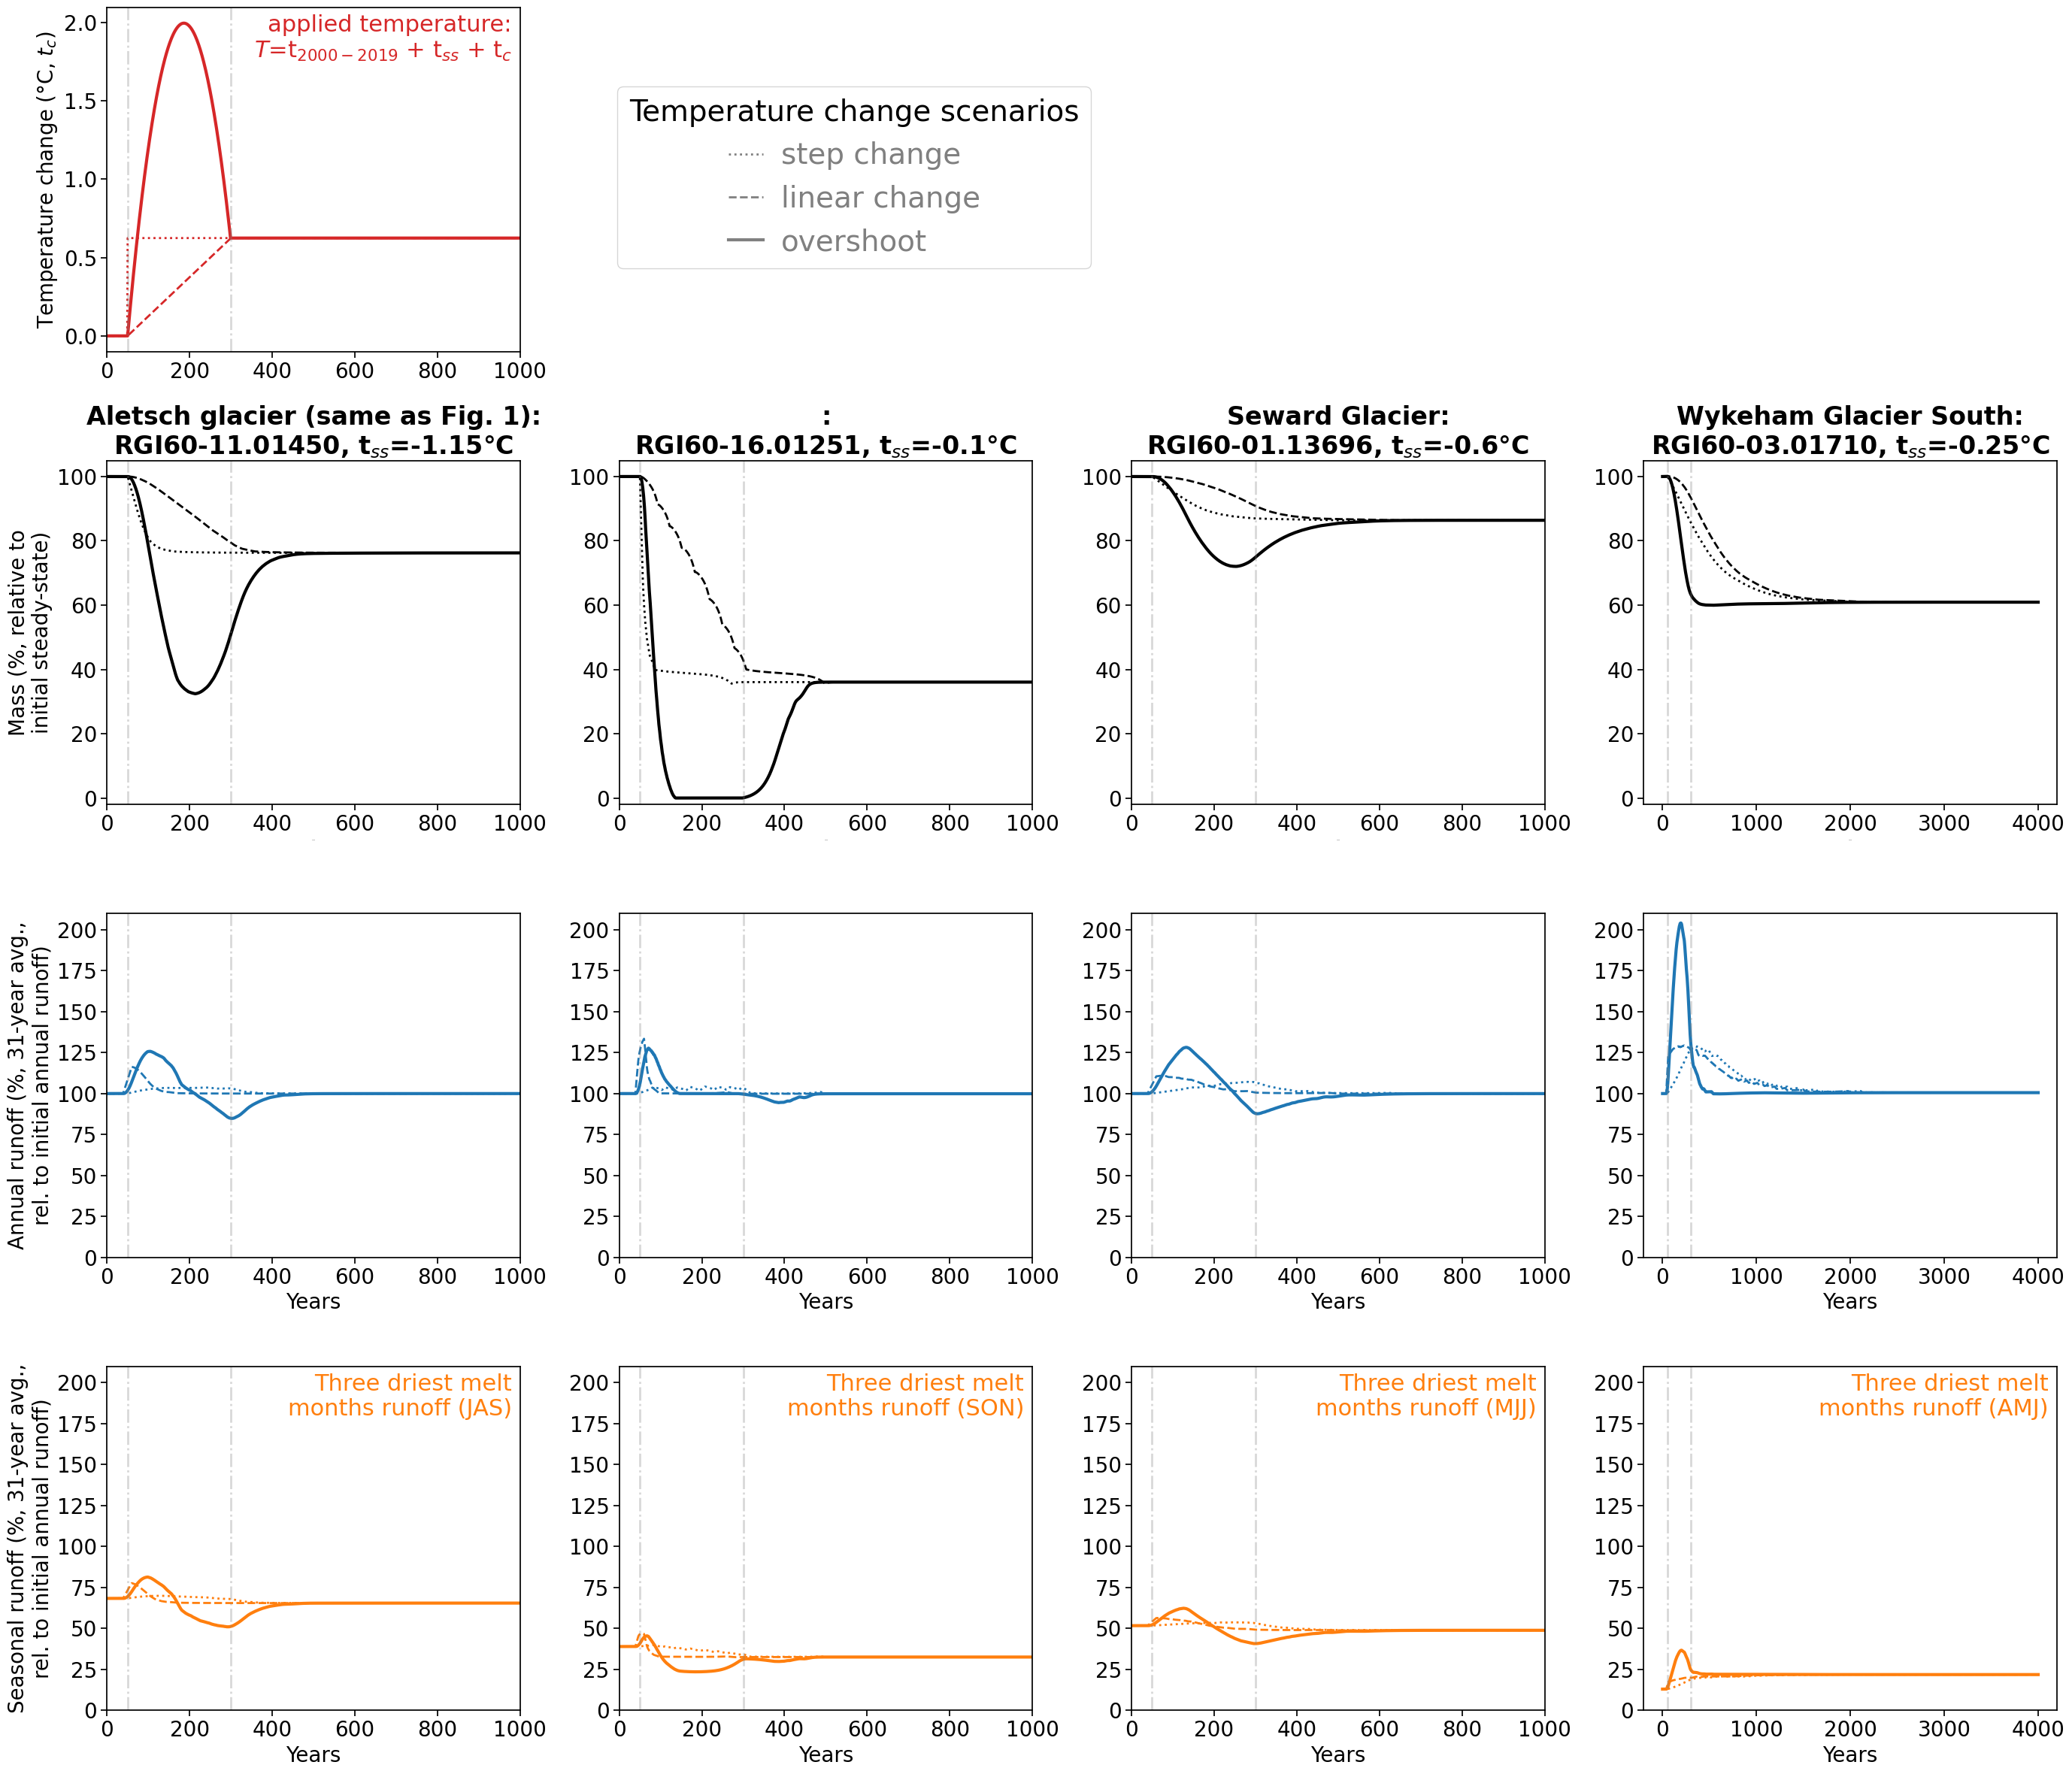

In [25]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(28, 24)) #sharex
plt.rc('font', size=20)

axs = axs.flatten()
#ds.length_m.plot(ax=axs[1]);
delta_t = dict_delta_t_rgi_eq[gdirs[-1].rgi_id]

(temp_bias_step-delta_t).plot(ax=axs[0], c='C3', ls=':', label='step change',lw=2);
(temp_bias_ts_lin-delta_t).plot(ax=axs[0], c='C3', ls='--', label='linear change',lw=2);
(temp_bias_ts-delta_t).plot(ax=axs[0], c='C3', label='overshoot', lw=3);
axs[0].text(0.98, 0.98, 'applied temperature:\n'+r'$T$=t$_{2000-2019}$ + t$_{ss}$ + t$_c$',
         ha='right', va='top', transform=axs[0].transAxes, 
        fontsize=22, color='C3')

axs[0].set_ylabel(r'Temperature change (°C, $t_c$)', fontsize=20); #axs[0].set_title(f'{rgi_id}'); axs[0].set_xlabel('');
#axs[0].set_title('Temperature', fontsize=22)
#leg.get_title().set_color('C3')


    

#axs[0].annotate('temperature\ntarget',(480,temp_bias_step.iloc[-1]), xytext=(420,temp_bias_step.iloc[-1]*2.1),
#                color='C3',
#           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

fig.delaxes(axs[1])
fig.delaxes(axs[2])
fig.delaxes(axs[3])

###
for j,gdir in enumerate(gdirs_sel):
    _r = gdir.rgi_id
    ds = ds_d[_r]
    ds_lin = ds_lin_d[_r]
    ds_step = ds_step_d[_r]
    #axs[3+j].text(0.98, 0.98, 'Volume',
    #         ha='right', va='top', transform=axs[2+j].transAxes, 
    #        fontsize=22, color='black')
    (100*ds_step.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[4+j], c='black', ls=':',lw=2);
    (100*ds_lin.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[4+j], c='black', ls ='--',lw=2 );
    (100*ds.volume_m3/ds_step.volume_m3.isel(time=0)).plot(ax=axs[4+j], c='black', ls='-', lw=3);
    if j==0:
        axs[4+j].set_ylabel('Mass (%, relative to\ninitial steady-state)', fontsize=20)
    else:
        axs[4+j].set_ylabel('')
    
    #axs[1].set_title('Glacier volume', fontsize=22)
    eq0 = (ds.volume_m3/1e9).isel(time=0)
    eq1 = (ds.volume_m3/1e9).isel(time=-1)
    #axs[2+j].annotate('glacier in\nsteady-state',(20,eq0), xytext=(-20,eq0*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)

    #axs[2+j].annotate('glacier in new\nsteady-state',(480,eq1), xytext=(420,eq1*0.7), color='black',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    #if j == 0:
    #    ylims = axs[4+j].get_ylim()
    #else:
    axs[4+j].set_ylim([-2,105])
        
    delta_t = dict_delta_t_rgi_eq[gdir.rgi_id]

    if '1450' in gdir.rgi_id:
        axs[4+j].set_title(f'Aletsch glacier (same as Fig. 1):\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=24)
    else:
        axs[4+j].set_title(f'{gdir.name}:\n{gdir.rgi_id}, '+ r't$_{ss}$='+f'{delta_t}°C', weight = 'bold', fontsize=24)
    axs[4+j].set_xlabel('Years', fontsize=0);         

###
for j,gdir in enumerate(gdirs_sel):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d[_r]
    df_runoff_lin = df_lin_runoff_d[_r]
    df_runoff_step = df_step_runoff_d[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff.sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_runoff_lin.sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_runoff_step.sum(axis=1).iloc[0]

    #axs[6+j].text(0.98, 0.98, 'Annual runoff',
    #         ha='right', va='top', transform=axs[6+j].transAxes, 
    #        fontsize=22, color='C0')
    df_runoff_sum_rel_step.plot(ax=axs[8+j], label = 'Annual runoff', c='C0', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[8+j], label = 'Annual runoff', c='C0', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[8+j], label = 'Annual runoff', c='C0', ls='-', lw=3);
    if j == 0:
        axs[8+j].set_ylabel('Annual runoff (%, 31-year avg.,\nrel. to initial annual runoff)', fontsize=20)
    else:
        axs[8+j].set_ylabel('')
    axs[8+j].set_xlabel('Years', fontsize=20); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[8+j].set_ylim([70,210])
    #axs[8+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='C0')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[4+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()

    #axs[4+j].annotate('trough water?',(tw_ind,tw*1.04), xytext=(tw_ind*1.2,tw*0.92),
    #             xycoords='data', textcoords='data', color='C0',
    #           arrowprops={'arrowstyle':'->', 'color':'grey', 'linewidth': 2}, fontsize=18)
    
    
for j,gdir in enumerate(gdirs_sel):
    _r = gdir.rgi_id
    df_runoff = df_runoff_d_dry[_r]
    df_runoff_lin = df_lin_runoff_d_dry[_r]
    df_runoff_step = df_step_runoff_d_dry[_r]
    df_runoff_sum_rel = 100*df_runoff.sum(axis=1)/df_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_lin = 100*df_runoff_lin.sum(axis=1)/df_lin_runoff_d[_r].sum(axis=1).iloc[0]
    df_runoff_sum_rel_step = 100*df_runoff_step.sum(axis=1)/df_step_runoff_d[_r].sum(axis=1).iloc[0]
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    if m_last == 9:
        ms = 'JAS'
    elif m_last == 6:
        ms = 'AMJ'
    elif m_last == 11:
        ms = 'SON'
    elif m_last == 7:
        ms = 'MJJ'
    else:
        print ('sth. wrong')
    axs[12+j].text(0.98, 0.98, f'Three driest melt\nmonths runoff ({ms})',
             ha='right', va='top', transform=axs[12+j].transAxes, 
            fontsize=22, color='tab:orange')
    df_runoff_sum_rel_step.plot(ax=axs[12+j], label = 'Seasonal runoff', c='tab:orange', ls=':',lw=2);
    df_runoff_sum_rel_lin.plot(ax=axs[12+j], label = 'Seasonal runoff', c='tab:orange', ls='--',lw=2);
    df_runoff_sum_rel.plot(ax=axs[12+j], label = 'Seasonal runoff', c='tab:orange', ls='-', lw=3);
    if j == 0:
        axs[12+j].set_ylabel('Seasonal runoff (%, 31-year avg.,\nrel. to initial annual runoff)', fontsize=20)
    else:
        axs[12+j].set_ylabel('')
    axs[12+j].set_xlabel('Years', fontsize=20); #plt.title(f'Total annual runoff for {rgi_id}');
    axs[12+j].set_ylim([70,210])
    #axs[12+j].fill_between(df_runoff_sum_rel.index,
    #                      100,
    #                      #df_runoff.iloc[0].sum(),
    #                      df_runoff_sum_rel.values, alpha = 0.3, color='tab:orange')
    pw = df_runoff_sum_rel.max()
    tw = df_runoff_sum_rel.min()
    #axs[4+j].set_ylim([df_runoff_sum.sum(axis=1).min()*0.95,pw*1.1])
    pw_ind = df_runoff_sum_rel.idxmax()
    #axs[+j].annotate('peak water',(pw_ind,pw*0.96), xytext=(pw_ind*0.2,pw*1.04),
    #                xycoords='data', textcoords='data',
    #                color='C0',
    #           arrowprops={'arrowstyle':'->','color':'grey', 'linewidth': 2}, fontsize=18)
    tw_ind = df_runoff_sum_rel.idxmin()
    
for j,ax in enumerate(axs):
    yt = ax.get_yticks()
    xt = ax.get_xticks()
    ax.set_xticks(xt.astype(int)[1::2],xt.astype(int)[1::2] , fontsize=20)
    if j<4:
        ax.set_yticks(yt[1::2],yt.round(1)[1::2], fontsize=20)
    elif j<8:
        ax.set_yticks(np.arange(0,120,20), np.arange(0,120,20), fontsize=20)
    else:
        ax.set_yticks(np.arange(0,220,25), np.arange(0,220,25), fontsize=20)
    
    if j not in [7,11,15]:
        ax.set_xlim([0,1000])
        ax.set_xticks(np.arange(0,1001,200),np.arange(0,1001,200) , fontsize=20)

    ax.axvline(300,color='grey',ls='-.', lw=2, alpha = 0.3)
    ax.axvline(50,color='grey',ls='-.', lw=2, alpha = 0.3)
    
plt.tight_layout()

leg = axs[0].legend(fontsize=28, frameon=True,handlelength=1.2, columnspacing=1,
                    handletextpad=0.6, title='Temperature change scenarios', title_fontsize=28, 
                    #title_fontproperties = {'textcolor':'grey', 'fontsize':28},
                    loc = 'lower left', bbox_to_anchor=(1.2,0.2), ncol=1)

for j in np.arange(0,3,1):
    leg.get_lines()[j].set_color('grey')
    leg.get_texts()[j].set_color('grey')

plt.savefig('figures/suppl_fig_idealised_1000_sel.png')

**Only melt analysis**

In [10]:
runoff_vars

['melt_off_glacier',
 'melt_on_glacier',
 'liq_prcp_off_glacier',
 'liq_prcp_on_glacier']

In [13]:
roll = 1


df_runoff_melt_d = {}
df_lin_runoff_melt_d = {}
df_step_runoff_melt_d = {}

melt_vars = ['melt_off_glacier',
             'melt_on_glacier']

gdir = gdirs[0]
    
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_oversh_temp')) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_lin_temp')) as ds_lin:
    ds_lin = ds_lin.isel(time=slice(0, -1)).load()

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_step_temp')) as ds_step:
    ds_step = ds_step.isel(time=slice(0, -1)).load()

runoff_vars_monthly = ['melt_off_glacier_monthly',
                       'melt_on_glacier_monthly',
                       'liq_prcp_off_glacier_monthly',
                       'liq_prcp_on_glacier_monthly']

labels_nice_dict = {'melt_off_glacier_monthly': 'melt off glacier',
                    'melt_on_glacier_monthly': 'melt on glacier',
                    'liq_prcp_off_glacier_monthly': 'liquid precipitation off glacier',
                    'liq_prcp_on_glacier_monthly': 'liquid precipitation on glacier'}
sel_vars_m = [v for v in ds.variables if 'month_2d' in ds[v].dims]
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]




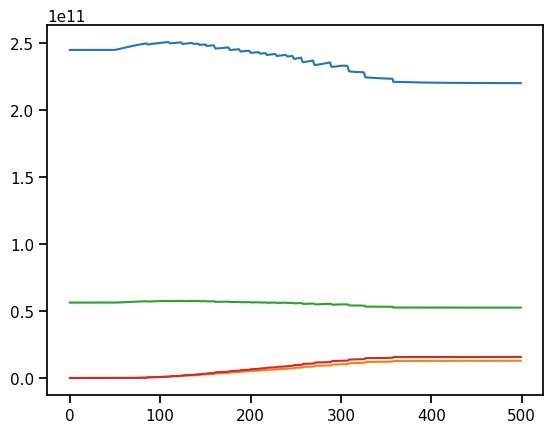

In [21]:
plt.plot(ds_lin['melt_on_glacier'].isel(time=slice(0,500)), label='melt_on_glacier')
plt.plot(ds_lin['melt_off_glacier'].isel(time=slice(0,500)), label='melt_off_glacier')
plt.plot(ds_lin['liq_prcp_on_glacier'].isel(time=slice(0,500)), label='liq_prcp_on_glacier')
plt.plot(ds_lin['liq_prcp_off_glacier'].isel(time=slice(0,500)), label='liq_prcp_off_glacier')

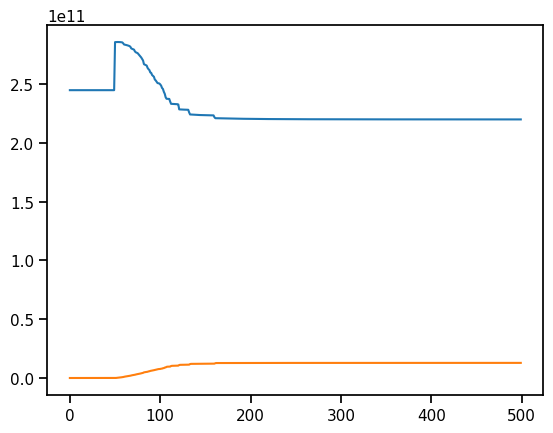

In [19]:
plt.plot(ds_step['melt_on_glacier'].isel(time=slice(0,500)))
plt.plot(ds_step['melt_off_glacier'].isel(time=slice(0,500)))

In [ ]:

    
for _d,_f in zip([ds,ds_lin,ds_step],
                 [df_runoff_d,df_step_runoff_d,df_lin_runoff_d]):


    df_annual = _d[sel_vars].to_dataframe()
    # Select only the runoff variables
    # Convert them to megatonnes (instead of kg)
    df_runoff = df_annual[runoff_vars] * 1e-9
    # We smooth the output, which is otherwize noisy because of area discretization
    df_runoff = df_runoff.rolling(roll, center=True, min_periods=1).mean()
    df_runoff = df_runoff.rename(columns=labels_nice_dict)

    _f[gdir.rgi_id] = df_runoff

for _d,_f in zip([ds,ds_lin,ds_step],
             [df_runoff_d_dry,df_step_runoff_d_dry,df_lin_runoff_d_dry]):   
    # todo change the numbers 
    m_last = dry_last_month_glacier_d[gdir.rgi_id]
    m_first = m_last-2
    print(gdir.rgi_id, m_first, m_last)
    df_summer = _d[sel_vars_m].sel(month_2d=slice(m_first,m_last)).sum(dim='month_2d').to_dataframe()
    # Convert them to megatonnes (instead of kg)
    df_runoff_sum = df_summer[runoff_vars_monthly] * 1e-9
    # We smooth the output, which is otherwize noisy because of area discretization
    df_runoff_sum = df_runoff_sum.rolling(roll, center=True, min_periods=1).mean()
    _f[gdir.rgi_id] = df_runoff_sum#.sum(axis=1)
#df_runoff_d[gdir.rgi_id] = df_runoff
#df_step_runoff_d[gdir.rgi_id] = df_step_runoff
#df_lin_runoff_d[gdir.rgi_id] = df_lin_runoff

**Old**

In [ ]:
#plt.legend()
m = 2
axs[m].text(0.98, 0.88, 'Melt-season runoff',
         ha='right', va='top', transform=axs[m].transAxes, 
        fontsize=22, color='C4')
df_runoff_sum_step.sum(axis=1).plot(ax=axs[m], c='C4', ls=':');
df_runoff_sum_lin.sum(axis=1).plot(ax=axs[m],  c='C4', ls='--');
df_runoff_sum.sum(axis=1).plot(ax=axs[m], c='C4', ls='-', lw=3);
axs[m].fill_between(df_runoff_sum.sum(axis=1).index,
                    df_runoff_sum.sum(axis=1).iloc[0], df_runoff_sum.sum(axis=1).values, alpha = 0.3, color='C4')
#leg = axs[3].legend(title='Melt-season glacier runoff', title_fontsize=22, frameon=False)#, fontsize=20)
#leg.get_title().set_color('C4')


#plt.ylabel('Melt-season runoff'); plt.xlabel('Years'); #plt.title(f'Total annual runoff for {rgi_id}');
#plt.plot(df_runoff_sum.index, np.repeat(df_runoff_sum.sum(axis=1).iloc[0], len(df_runoff_sum)),
#         c='cyan', ls='-.',lw=0.4)
#ax.set_xticks([])
num_text_x = 0.01
num_text_y = 0.9
for j,ax in enumerate(axs):
    ax.set_yticks([]);
    ax.set_xticks([],[])
    ax.text(num_text_x, num_text_y,
            num_dict[j], fontsize=24, transform=ax.transAxes)
    ax.axvline(300, ls='-', lw=0.5, alpha =0.4, color='grey', zorder=0)
    ax.axvline(50, ls='-', lw=0.5, alpha =0.4, color='grey', zorder=0)
axs[2].set_xlabel('Time', fontsize=22); #axs[0].set_ylabel('Temperature bias (°C)');
plt.tight_layout();
#plt.savefig('figures/overshoot_conceptual_model_2.pdf')